# Прогнозирование временных рядов ETNA

План ноутбука:

1. Вводные по задаче.

2. Библиотеки.

3. Блок функций.

4. Загрузка и подготовка данных.

5. Анализ данных.

6. Naive and Linear first models.

7. Transforms.

8. Catboost.

Feature importances

9. SeasonalMovingAverageModel.

10. Prophet.

11. Sarimax.

12. Результаты и выводы.

## Вводные по задаче.

Цели практической работы

Научиться:

    прогнозировать мультивременной ряд о продажах товаров в магазине с помощью библиотеки ETNA, используя:
        авторегрессионные модели;
        фичи и классические регрессионные модели — линейную регрессию бустинги;
    оценивать качество моделей при помощи метрики SMAPE;
    оценивать временные ряды с помощью методов кросс-валидации для временных рядов.

### Задание
-  Добейтесь значения метрики **SMAPE** меньше 12% (метрика на тесте, отложенной выборке).
-  Оцените качество моделей на backtest-е.
-  Сравните рассмотренные модели между собой, объединив результаты в таблицу `res`, как это было сделано выше.
-  Опишите проделанную работу и сделайте выводы о том, как выбирали гиперпараметры, с какими сложностями столкнулись, какие модели оказались лучше и почему.
-  Используйте и подберите параметры для моделей Prophet, ARIMA, Catboost.


### `Pipeline`

`Pipeline` используется для создания обработки данных от начала до конца, включая подготовку данных, трансформации и обучение модели. Это может включать в себя:

- **Преобразование данных**: например, обработка пропусков, нормализация или агрегация временных рядов.
- **Указание модели**: выбор модели, которая будет использоваться для прогнозирования.
- **Оценка модели**: можно использовать кросс-валидацию и другие методы для оценки качества модели.

### Когда применять `Pipeline`:

1. **Подготовка данных**: Когда вам нужно выполнить несколько этапов обработки данных и вы хотите автоматизировать этот процесс.
2. **Разнообразие моделей**: Если вы планируете использовать разные подходы (например, разные модели для разных временных рядов), `Pipeline` позволяет легко управлять этим процессом.
3. **Кросс-валидация**: Если вы хотите проводить кросс-валидацию для оценки модели, `Pipeline` может упростить этот процесс.

### `AutoRegressivePipeline`

`AutoRegressivePipeline` ориентирован на использование авторегрессионных моделей, которые предсказывают значения временного ряда на основе прошлых значений самого ряда. Это может включать такие модели, как ARIMA, SARIMA и другие.

### Когда применять `AutoRegressivePipeline`:

1. **Сильная авторегрессионная структура данных**: Если ваши данные хорошо описываются авторегрессионными зависимостями (то есть значения временного ряда зависят от своих прошлых значений).
2. **Сезонные модели**: Если данные имеют ярко выраженную сезонность и тренды, это может быть хорошим выбором.
3. **Нет внешних факторов**: Если вы считаете, что внешние факторы (например, климат, экономические показатели) не влияют на ваши данные, и вы хотите построить модель на основе прошлых значений.

### Заключение

Выбор между `Pipeline` и `AutoRegressivePipeline` зависит от ваших данных и целей прогнозирования. Если ваше время ряда имеет сильные авторегрессионные свойства и вы хотите сосредоточиться на этих характеристиках, то лучше использовать `AutoRegressivePipeline`. В случае, когда вам нужно больше гибкости в обработке, трансформации и использовании различных моделей, `Pipeline` будет более подходящим вариантом.

## Библиотеки.

In [72]:
#pip install "etna[all]@git+https://github.com/etna-team/etna.git@master"

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#pip show etna

In [3]:
#from etna import models
#print(dir(models))

In [4]:
#import etna.transforms
#print("Поддерживаемые трансформации в ETNA:")
#for attr in dir(etna.transforms):
#    print(attr)

In [5]:
import pandas as pd
import numpy as np
import random
import copy
import seaborn as sns
import matplotlib.pyplot as plt
#import optuna
from scipy.signal import periodogram
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from etna.datasets.tsdataset import TSDataset
from etna.transforms import (
    StandardScalerTransform,
    MeanTransform,
    LagTransform,
    DateFlagsTransform,
    LinearTrendTransform,
    LogTransform,
    DifferencingTransform,
    FourierTransform,
    HolidayTransform,
    TimeSeriesImputerTransform,
    BoxCoxTransform,
    IQROutlierTransform
    )

from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.metrics import SMAPE, MAE, MSE

import warnings
warnings.filterwarnings('ignore')

from etna.analysis import plot_forecast
from etna.analysis import acf_plot
from etna.analysis import stl_plot
from etna.analysis import plot_backtest
from etna.analysis import plot_correlation_matrix

from etna.models import NaiveModel, SeasonalMovingAverageModel
from etna.models import ElasticPerSegmentModel, LinearPerSegmentModel
from catboost import CatBoostClassifier
from etna.models import CatBoostPerSegmentModel, CatBoostMultiSegmentModel
from etna.models import ProphetModel
from etna.models import SARIMAXModel, AutoARIMAModel # чистой arima нет

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

/home/leostuchchi/anaconda3/envs/etna_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
smape = SMAPE() # Настройка метрики SMAPE
HORIZON = 90  # Горизонт прогнозирования (90 дней)
CONSIDER_SHOP = [1, 2, 3]  # Список магазинов для рассмотрения
SEGMENTS_TO_SHOW = ['3 + 27', '1 + 47']  # Сегменты для построения графика прогноза

HORIZON: Количество дней, на которые делается прогноз.

CONSIDER_SHOP: Список магазинов, которые будут рассмотрены в эксперименте.

SEGMENTS_TO_SHOW: Сегменты, для которых будут построены графики прогнозов.


## Блок функций.

In [7]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)


smape = SMAPE()

In [8]:
def plot_feature_importance(importance, names, top_k=None):
    if top_k is None:
        top_k = len(names)
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    fi_df = pd.DataFrame({'feature_names' : feature_names,
                          'feature_importance' : feature_importance})
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_k], y=fi_df['feature_names'][:top_k])
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')



In [9]:


def plot_transformed_data(original_ts, transformed_ts, segments_to_show=3):
    """Визуализация трансформаций для случайных сегментов."""
    # Выбираем случайные сегменты для визуализации
    segments = np.random.choice(original_ts.segments, segments_to_show, replace=False)

    plt.figure(figsize=(20, 5*len(segments)))

    for i, segment in enumerate(segments, 1):
        # Получаем данные для сегмента
        original = original_ts[:, segment, "target"]
        transformed = transformed_ts[:, segment, "target"]

        # График временного ряда
        plt.subplot(len(segments), 2, 2*i-1)
        plt.plot(original, label='Original', alpha=0.7)
        plt.plot(transformed, label='Transformed', color='orange')
        plt.title(f"Segment {segment} - Target")
        plt.legend()

        # Распределение значений
        plt.subplot(len(segments), 2, 2*i)
        sns.kdeplot(original, label='Original', fill=True)
        sns.kdeplot(transformed, label='Transformed', fill=True, color='orange')
        plt.title(f"Segment {segment} - Distribution")
        plt.legend()

    plt.tight_layout()
    plt.show()



In [10]:


def objective(trial):
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    alpha = trial.suggest_float('alpha', 0, 1)

    model = ElasticPerSegmentModel(l1_ratio=l1_ratio, alpha=alpha, random_state=42)
    pipe = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

    metrics_df, _, _ = pipe.backtest(
        mode='expand',
        n_folds=5,
        ts=ts,
        metrics=[smape],
        aggregate_metrics=True,
        joblib_params=dict(backend='loky'),
        n_jobs=-1
    )

    return metrics_df['SMAPE'].mean()

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)

#print(f"Best parameters: {study.best_params}")

In [11]:
#Функция для обучения и оценки модел
def train_and_evaluate_model(ts, model, transforms, horizon, metrics, is_auto_regressive=False, print_metrics=True, return_forecast=False, n_train_samples=360 * 2, segments_to_plot=SEGMENTS_TO_SHOW):
    """Обучает модель, вычисляет прогнозы для тестовой выборки и строит график прогнозов."""

    ts_copy = copy.deepcopy(ts)
    train_ts, test_ts = ts_copy.train_test_split(test_size=horizon)

    if not is_auto_regressive:
        pipe = Pipeline(model=model, transforms=transforms, horizon=horizon)
    else:
        pipe = AutoRegressivePipeline(model=model, transforms=transforms, horizon=horizon)

    pipe.fit(train_ts)
    #forecast_ts = pipe.forecast()
    forecast_ts = pipe.forecast()  # Используем test_ts для прогнозирования


    # оцениваем качество прогнозов по сегментам
    segment_metrics = metrics(test_ts, forecast_ts)
    segment_metrics = pd.Series(segment_metrics)

    avg_metric = sum(segment_metrics) / len(segment_metrics)

    if print_metrics:
        print(f"Avg (by segments) metric {metrics} is: {avg_metric}")

    if segments_to_plot:
        plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=n_train_samples, segments=segments_to_plot)

    if return_forecast:
        return segment_metrics, avg_metric, forecast_ts

    return segment_metrics, avg_metric
'''
  - Функция `train_and_evaluate_model` обучает модель на обучающих данных, делает прогноз на тестовых данных и оценивает качество модели с помощью метрики `SMAPE`.
  - Если `is_auto_regressive=True`, используется `AutoRegressivePipeline`, который подходит для моделей с авторегрессией.
  - Результаты визуализируются с помощью `plot_forecast`.'''

'\n  - Функция `train_and_evaluate_model` обучает модель на обучающих данных, делает прогноз на тестовых данных и оценивает качество модели с помощью метрики `SMAPE`.\n  - Если `is_auto_regressive=True`, используется `AutoRegressivePipeline`, который подходит для моделей с авторегрессией.\n  - Результаты визуализируются с помощью `plot_forecast`.'

In [12]:
def plot_feature_importance(importance, names, top_k=None):
    if top_k is None:
        top_k = len(names)
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    fi_df = pd.DataFrame({'feature_names' : feature_names,
                          'feature_importance' : feature_importance})
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_k], y=fi_df['feature_names'][:top_k])
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## Data.



Загружает обучающие и тестовые данные.

Уменьшает размер данных, оставляя только выбранные магазины.

Создаёт столбец сегментов.

Преобразует столбцы store и item в категориальные.

Подготавливает экзогенные переменные.

Добавляет признаки, связанные с кварталами.

Преобразует данные в формат TSDataset.


In [13]:
df = pd.read_csv('data/HW_train.csv', parse_dates=['date'])

df.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)
df

timestamp  store  item  target
0      2013-01-01      1     1      13
1      2013-01-02      1     1      11
2      2013-01-03      1     1      14
3      2013-01-04      1     1      13
4      2013-01-05      1     1      10
...           ...    ...   ...     ...
912995 2017-12-27     10    50      63
912996 2017-12-28     10    50      59
912997 2017-12-29     10    50      74
912998 2017-12-30     10    50      62
912999 2017-12-31     10    50      82

[913000 rows x 4 columns]

In [14]:
# уменьшаем размер данных, чтобы не тратить много времени на обучение
before_shape = df.shape
print('before', before_shape)
df = df[df.store.isin(CONSIDER_SHOP)]
print('before', df.shape)

print(f"Current dataset size {df.shape[0] * 100 / before_shape[0]}%")

before (913000, 4)
before (273900, 4)
Current dataset size 30.0%


In [15]:
df_new = pd.read_csv('data/HW_test.csv', parse_dates=['date'])
df_new = df_new[df_new.store.isin(CONSIDER_SHOP)]

df_new.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)


df_new.drop(columns='id', inplace=True)

df_new

timestamp  store  item
0     2018-01-01      1     1
1     2018-01-02      1     1
2     2018-01-03      1     1
3     2018-01-04      1     1
4     2018-01-05      1     1
...          ...    ...   ...
44365 2018-03-27      3    50
44366 2018-03-28      3    50
44367 2018-03-29      3    50
44368 2018-03-30      3    50
44369 2018-03-31      3    50

[13500 rows x 3 columns]

In [16]:
# Создаём столбец сегментов
df['segment'] = (df['store'].astype(str) + ' + '
                 + df['item'].astype(str))

df_new['segment'] = (df_new['store'].astype(str) + ' + '
                     + df_new['item'].astype(str))

df.head()

timestamp  store  item  target segment
0 2013-01-01      1     1      13   1 + 1
1 2013-01-02      1     1      11   1 + 1
2 2013-01-03      1     1      14   1 + 1
3 2013-01-04      1     1      13   1 + 1
4 2013-01-05      1     1      10   1 + 1

In [17]:
# Преобразуем столбцы store и item в категориальные
for col in ['store', 'item']:
    df[col] = df[col].astype('category')
    df_new[col] = df_new[col].astype('category')

In [18]:
# Подготавливаем экзогенные переменные
regressor_df = df[['timestamp', 'segment', 'store', 'item']].copy()
regressor_df

timestamp segment store item
0      2013-01-01   1 + 1     1    1
1      2013-01-02   1 + 1     1    1
2      2013-01-03   1 + 1     1    1
3      2013-01-04   1 + 1     1    1
4      2013-01-05   1 + 1     1    1
...           ...     ...   ...  ...
900213 2017-12-27  3 + 50     3   50
900214 2017-12-28  3 + 50     3   50
900215 2017-12-29  3 + 50     3   50
900216 2017-12-30  3 + 50     3   50
900217 2017-12-31  3 + 50     3   50

[273900 rows x 4 columns]

In [19]:
# экзогенные переменные store и item
regressor_df_new = df_new.copy()
regressor_df_new

timestamp store item segment
0     2018-01-01     1    1   1 + 1
1     2018-01-02     1    1   1 + 1
2     2018-01-03     1    1   1 + 1
3     2018-01-04     1    1   1 + 1
4     2018-01-05     1    1   1 + 1
...          ...   ...  ...     ...
44365 2018-03-27     3   50  3 + 50
44366 2018-03-28     3   50  3 + 50
44367 2018-03-29     3   50  3 + 50
44368 2018-03-30     3   50  3 + 50
44369 2018-03-31     3   50  3 + 50

[13500 rows x 4 columns]

In [20]:
regressor_df = regressor_df.sort_index(
    axis=1, ascending=False)

regressor_df_new = regressor_df_new.sort_index(
    axis=1, ascending=False)

In [21]:
regressor_df.shape, regressor_df_new.shape, regressor_df.shape[0] + regressor_df_new.shape[0]

((273900, 4), (13500, 4), 287400)

In [22]:
regressor_df.columns, regressor_df_new.columns

(Index(['timestamp', 'store', 'segment', 'item'], dtype='object'),
 Index(['timestamp', 'store', 'segment', 'item'], dtype='object'))

In [23]:
# Добавляем признаки, связанные с кварталами и месяцам
regressor_df = pd.concat([regressor_df, regressor_df_new], axis=0)

regressor_df['quarter'] = regressor_df['timestamp'].dt.quarter
regressor_df['quarter_start'] = regressor_df['timestamp'].dt.is_quarter_start
regressor_df['quarter_end'] = regressor_df['timestamp'].dt.is_quarter_end

regressor_df['month'] = regressor_df['timestamp'].dt.month
regressor_df['month_start'] = regressor_df['timestamp'].dt.is_month_start
regressor_df['month_end'] = regressor_df['timestamp'].dt.is_month_end

regressor_df['sin365'] = np.sin(2 * np.pi * regressor_df['timestamp'].dt.dayofyear / 365.25)
regressor_df['cos365'] = np.cos(2 * np.pi * regressor_df['timestamp'].dt.dayofyear / 365.25)

regressor_df['sin365_2'] = np.sin(4 * np.pi * regressor_df['timestamp'].dt.dayofyear / 365.25)
regressor_df['cos365_2'] = np.cos(4 * np.pi * regressor_df['timestamp'].dt.dayofyear / 365.25)

# День недели и бинарный признак выходного
#regressor_df['day_of_week'] = regressor_df['timestamp'].dt.dayofweek  # 0-6 (пн-вс)
#regressor_df['is_weekend'] = regressor_df['day_of_week'].isin([5, 6]).astype(int)

# Сезон (например, 0-3 для зимы, весны, лета, осени)
#regressor_df['season'] = regressor_df['timestamp'].dt.month % 12 // 3

# Номер недели в году и день в году
#regressor_df['week_of_year'] = regressor_df['timestamp'].dt.isocalendar().week
#regressor_df['day_of_year'] = regressor_df['timestamp'].dt.dayofyear

regressor_df

timestamp store segment item  quarter  quarter_start  quarter_end  \
0     2013-01-01     1   1 + 1    1        1           True        False   
1     2013-01-02     1   1 + 1    1        1          False        False   
2     2013-01-03     1   1 + 1    1        1          False        False   
3     2013-01-04     1   1 + 1    1        1          False        False   
4     2013-01-05     1   1 + 1    1        1          False        False   
...          ...   ...     ...  ...      ...            ...          ...   
44365 2018-03-27     3  3 + 50   50        1          False        False   
44366 2018-03-28     3  3 + 50   50        1          False        False   
44367 2018-03-29     3  3 + 50   50        1          False        False   
44368 2018-03-30     3  3 + 50   50        1          False        False   
44369 2018-03-31     3  3 + 50   50        1          False         True   

       month  month_start  month_end    sin365    cos365  sin365_2  cos365_2  
0          1         True      False  0.017202  0.999852  0.034398  0.999408  
1          1        False      False  0.034398  0.999408  0.068755  0.997634  
2          1        False      False  0.051584  0.998669  0.103031  0.994678  
3          1        False      False  0.068755  0.997634  0.137185  0.990545  
4          1        False      False  0.085906  0.996303  0.171177  0.985240  
...      ...          ...        ...       ...       ...       ...       ...  
44365      3        False      False  0.995827  0.091261  0.181760 -0.983343  
44366      3        False      False  0.997250  0.074117  0.147827 -0.989013  
44367      3        False      False  0.998377  0.056952  0.113720 -0.993513  
44368      3        False      False  0.999209  0.039770  0.079477 -0.996837  
44369      3        False       True  0.999745  0.022576  0.045141 -0.998981  

[287400 rows x 14 columns]

In [24]:
# подготавливаем исторический набор эндогенных переменных
# Подготавливаем эндогенные переменные
df.drop(['store', 'item'], axis=1, inplace=True)
df

timestamp  target segment
0      2013-01-01      13   1 + 1
1      2013-01-02      11   1 + 1
2      2013-01-03      14   1 + 1
3      2013-01-04      13   1 + 1
4      2013-01-05      10   1 + 1
...           ...     ...     ...
900213 2017-12-27      52  3 + 50
900214 2017-12-28      75  3 + 50
900215 2017-12-29      68  3 + 50
900216 2017-12-30      62  3 + 50
900217 2017-12-31      77  3 + 50

[273900 rows x 3 columns]

In [25]:
# Преобразуем данные в формат TSDataset
df = TSDataset.to_dataset(df)
df

segment     1 + 1 1 + 10 1 + 11 1 + 12 1 + 13 1 + 14 1 + 15 1 + 16 1 + 17  \
feature    target target target target target target target target target   
timestamp                                                                   
2013-01-01     13     37     37     33     37     22     42     14     13   
2013-01-02     11     34     43     35     31     35     33     11     18   
2013-01-03     14     32     34     41     50     26     45     12     15   
2013-01-04     13     45     52     45     45     32     39     15     19   
2013-01-05     10     35     45     46     49     31     47     22     16   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27     14     55     43     47     49     42     62     16     29   
2017-12-28     19     63     64     49     68     51     82     24     13   
2017-12-29     15     56     60     58     73     42     65     11     27   
2017-12-30     27     78     66     52     70     57     77     28     32   
2017-12-31     23     74     44     60     75     52     64     38     37   

segment    1 + 18  ... 3 + 46 3 + 47 3 + 48 3 + 49  3 + 5 3 + 50  3 + 6  \
feature    target  ... target target target target target target target   
timestamp          ...                                                    
2013-01-01     38  ...     33     10     28     21     13     45     34   
2013-01-02     51  ...     46     12     32     14      9     47     38   
2013-01-03     42  ...     37     13     40     22     10     39     32   
2013-01-04     50  ...     32      5     39     26     20     48     36   
2013-01-05     56  ...     41     14     47     22     13     46     36   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27     54  ...     60     21     42     23     17     52     53   
2017-12-28     69  ...     72     19     52     38     21     75     55   
2017-12-29     66  ...     44     19     55     32     24     68     45   
2017-12-30     67  ...     67     21     61     48     15     62     64   
2017-12-31     88  ...     71     26     59     25     21     77     65   

segment     3 + 7  3 + 8  3 + 9  
feature    target target target  
timestamp                        
2013-01-01     40     54     28  
2013-01-02     36     34     16  
2013-01-03     36     61     32  
2013-01-04     38     38     40  
2013-01-05     31     54     44  
...           ...    ...    ...  
2017-12-27     53     67     46  
2017-12-28     53     80     61  
2017-12-29     51     71     54  
2017-12-30     61     87     48  
2017-12-31     73     76     58  

[1826 rows x 150 columns]

In [26]:
# 2 Преобразуем данные в формат TSDataset
regressor_df = TSDataset.to_dataset(regressor_df)
regressor_df

segment        1 + 1                                                     \
feature       cos365  cos365_2 item month month_end month_start quarter   
timestamp                                                                 
2013-01-01  0.999852  0.999408    1     1     False        True       1   
2013-01-02  0.999408  0.997634    1     1     False       False       1   
2013-01-03  0.998669  0.994678    1     1     False       False       1   
2013-01-04  0.997634  0.990545    1     1     False       False       1   
2013-01-05  0.996303  0.985240    1     1     False       False       1   
...              ...       ...  ...   ...       ...         ...     ...   
2018-03-27  0.091261 -0.983343    1     3     False       False       1   
2018-03-28  0.074117 -0.989013    1     3     False       False       1   
2018-03-29  0.056952 -0.993513    1     3     False       False       1   
2018-03-30  0.039770 -0.996837    1     3     False       False       1   
2018-03-31  0.022576 -0.998981    1     3      True       False       1   

segment                                         ... 3 + 9                  \
feature    quarter_end quarter_start    sin365  ...  item month month_end   
timestamp                                       ...                         
2013-01-01       False          True  0.017202  ...     9     1     False   
2013-01-02       False         False  0.034398  ...     9     1     False   
2013-01-03       False         False  0.051584  ...     9     1     False   
2013-01-04       False         False  0.068755  ...     9     1     False   
2013-01-05       False         False  0.085906  ...     9     1     False   
...                ...           ...       ...  ...   ...   ...       ...   
2018-03-27       False         False  0.995827  ...     9     3     False   
2018-03-28       False         False  0.997250  ...     9     3     False   
2018-03-29       False         False  0.998377  ...     9     3     False   
2018-03-30       False         False  0.999209  ...     9     3     False   
2018-03-31        True         False  0.999745  ...     9     3      True   

segment                                                                       \
feature    month_start quarter quarter_end quarter_start    sin365  sin365_2   
timestamp                                                                      
2013-01-01        True       1       False          True  0.017202  0.034398   
2013-01-02       False       1       False         False  0.034398  0.068755   
2013-01-03       False       1       False         False  0.051584  0.103031   
2013-01-04       False       1       False         False  0.068755  0.137185   
2013-01-05       False       1       False         False  0.085906  0.171177   
...                ...     ...         ...           ...       ...       ...   
2018-03-27       False       1       False         False  0.995827  0.181760   
2018-03-28       False       1       False         False  0.997250  0.147827   
2018-03-29       False       1       False         False  0.998377  0.113720   
2018-03-30       False       1       False         False  0.999209  0.079477   
2018-03-31       False       1        True         False  0.999745  0.045141   

segment           
feature    store  
timestamp         
2013-01-01     3  
2013-01-02     3  
2013-01-03     3  
2013-01-04     3  
2013-01-05     3  
...          ...  
2018-03-27     3  
2018-03-28     3  
2018-03-29     3  
2018-03-30     3  
2018-03-31     3  

[1916 rows x 1800 columns]

In [27]:
# создаём объединённый набор
ts = TSDataset(df=df, freq='D', df_exog=regressor_df,
               known_future='all')
# создаем NO EXOG
ts_no_exog = TSDataset(df=df, freq='D')
ts

segment        1 + 1                                                     \
feature       cos365  cos365_2 item month month_end month_start quarter   
timestamp                                                                 
2013-01-01  0.999852  0.999408    1     1     False        True       1   
2013-01-02  0.999408  0.997634    1     1     False       False       1   
2013-01-03  0.998669  0.994678    1     1     False       False       1   
2013-01-04  0.997634  0.990545    1     1     False       False       1   
2013-01-05  0.996303  0.985240    1     1     False       False       1   
...              ...       ...  ...   ...       ...         ...     ...   
2017-12-27  0.997329  0.989329    1    12     False       False       4   
2017-12-28  0.998438  0.993755    1    12     False       False       4   
2017-12-29  0.999251  0.997005    1    12     False       False       4   
2017-12-30  0.999769  0.999075    1    12     False       False       4   
2017-12-31  0.999991  0.999963    1    12      True       False       4   

segment                                         ... 3 + 9            \
feature    quarter_end quarter_start    sin365  ... month month_end   
timestamp                                       ...                   
2013-01-01       False          True  0.017202  ...     1     False   
2013-01-02       False         False  0.034398  ...     1     False   
2013-01-03       False         False  0.051584  ...     1     False   
2013-01-04       False         False  0.068755  ...     1     False   
2013-01-05       False         False  0.085906  ...     1     False   
...                ...           ...       ...  ...   ...       ...   
2017-12-27       False         False -0.073045  ...    12     False   
2017-12-28       False         False -0.055879  ...    12     False   
2017-12-29       False         False -0.038696  ...    12     False   
2017-12-30       False         False -0.021501  ...    12     False   
2017-12-31        True         False -0.004301  ...    12      True   

segment                                                                       \
feature    month_start quarter quarter_end quarter_start    sin365  sin365_2   
timestamp                                                                      
2013-01-01        True       1       False          True  0.017202  0.034398   
2013-01-02       False       1       False         False  0.034398  0.068755   
2013-01-03       False       1       False         False  0.051584  0.103031   
2013-01-04       False       1       False         False  0.068755  0.137185   
2013-01-05       False       1       False         False  0.085906  0.171177   
...                ...     ...         ...           ...       ...       ...   
2017-12-27       False       4       False         False -0.073045 -0.145700   
2017-12-28       False       4       False         False -0.055879 -0.111583   
2017-12-29       False       4       False         False -0.038696 -0.077334   
2017-12-30       False       4       False         False -0.021501 -0.042993   
2017-12-31       False       4        True         False -0.004301 -0.008601   

segment                  
feature    store target  
timestamp                
2013-01-01     3   28.0  
2013-01-02     3   16.0  
2013-01-03     3   32.0  
2013-01-04     3   40.0  
2013-01-05     3   44.0  
...          ...    ...  
2017-12-27     3   46.0  
2017-12-28     3   61.0  
2017-12-29     3   54.0  
2017-12-30     3   48.0  
2017-12-31     3   58.0  

[1826 rows x 1950 columns]

## Data Analysis

! НЕ ПРЕОБРАЗОВАННЫЕ ДАННЫЕ

In [28]:
# смотрим сырые данные
data = pd.read_csv('data/HW_train.csv', parse_dates=['date'])
# берем один магазин
data = data[data.store.isin(CONSIDER_SHOP)]

In [29]:
data.rename(columns={'date': 'timestamp',
                   'sales': 'target'}, inplace=True)
data = data['target']

In [30]:
# Вычисление автокорреляции
acf_values = acf(data, nlags=100)

# Поиск значимых лагов
significant_lags = np.where(acf_values > 0.5)[0]  # Порог можно настроить
print("Значимые лаги:", significant_lags)


# Вычисление периодограммы
frequencies, power = periodogram(data)

# Поиск доминирующих частот
dominant_frequencies = frequencies[np.argsort(power)[-5:]]  # Топ-5 частот
print("Доминирующие частоты:", dominant_frequencies)

Значимые лаги: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
Доминирующие частоты: [1.82548375e-04 7.30193501e-05 5.11135451e-05 5.47645126e-05
 2.73822563e-03]


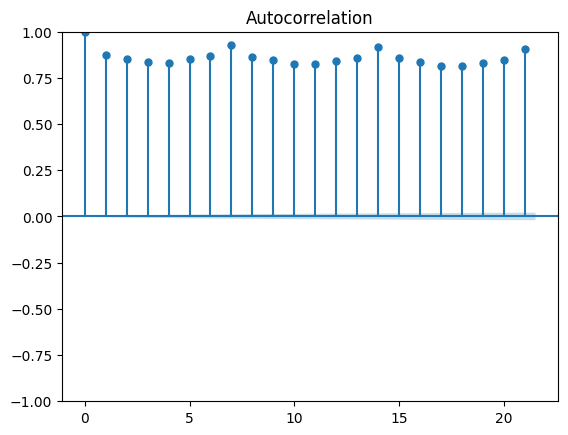

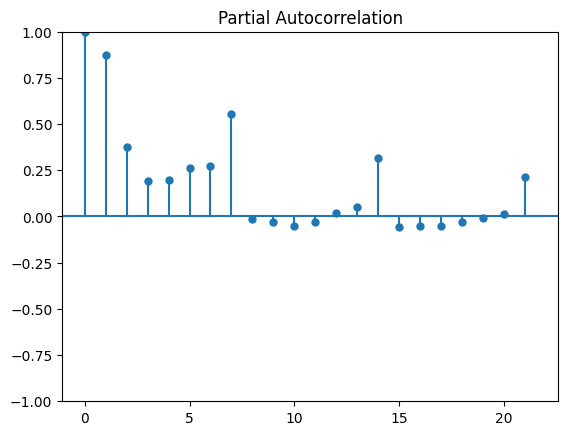

In [31]:
# смотрим количество лагов
plot_acf(data, lags=21)
plt.show()

plot_pacf(data, lags=21)
plt.show()

! ПРЕОБРАЗОВАННЫЕ ДАННЫЕ

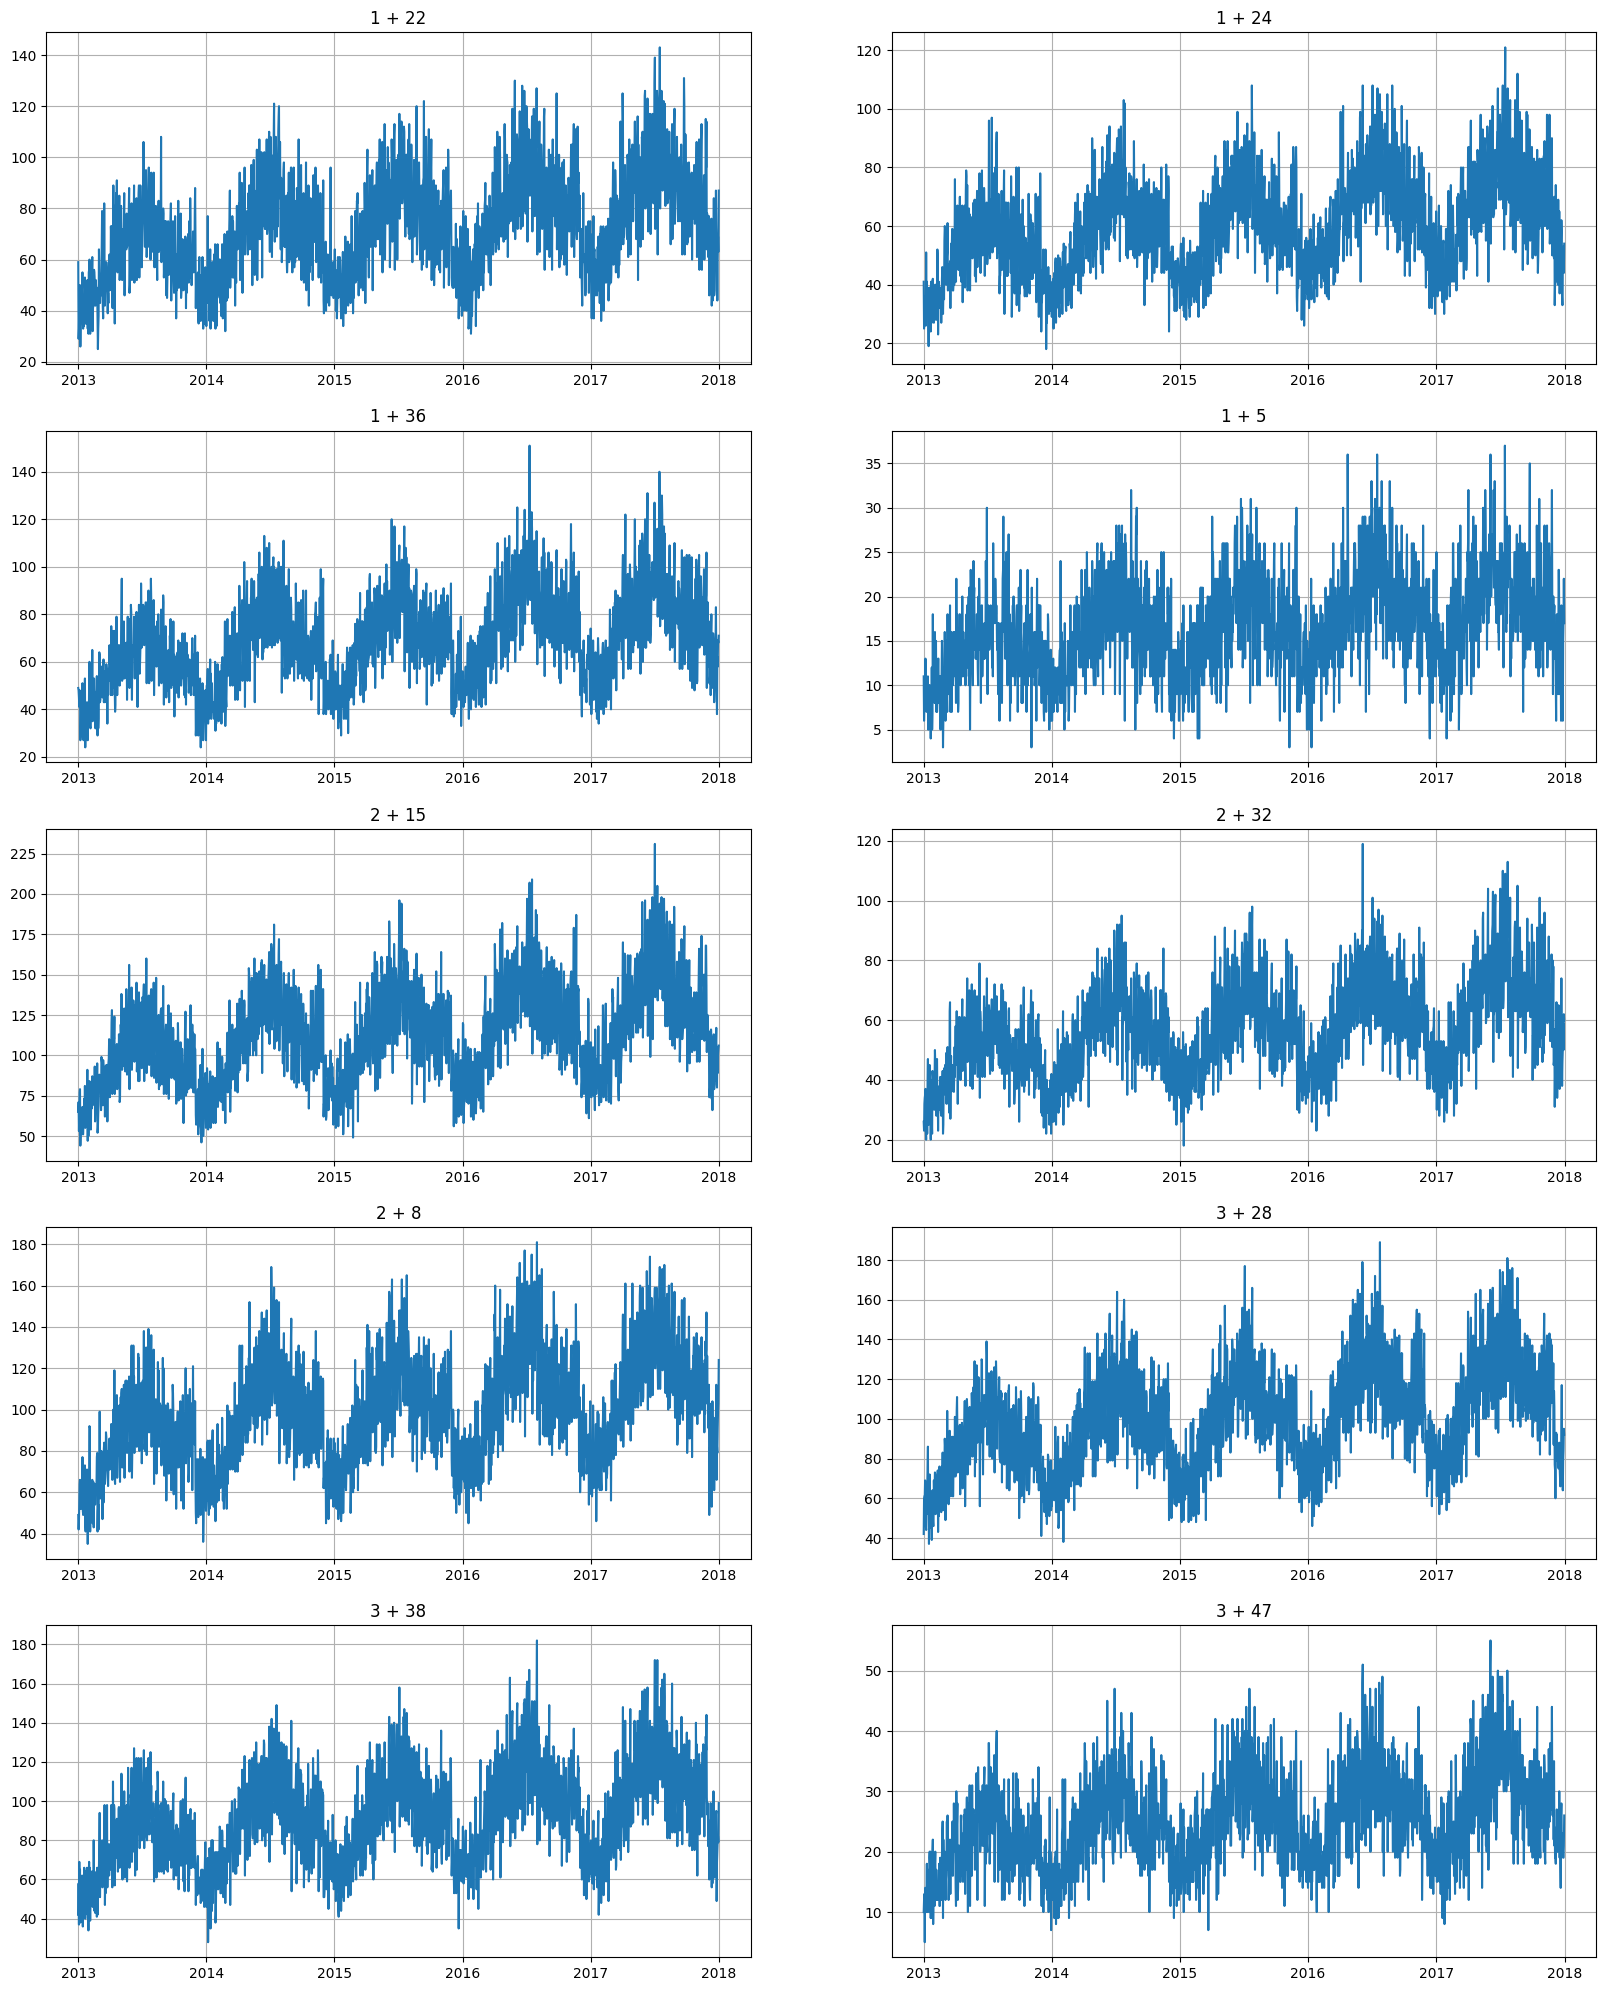

In [32]:
ts.plot()

In [33]:
ts.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
1 + 1         2013-01-01    2017-12-31    1826            0           150   
1 + 10        2013-01-01    2017-12-31    1826            0           150   
1 + 11        2013-01-01    2017-12-31    1826            0           150   
1 + 12        2013-01-01    2017-12-31    1826            0           150   
1 + 13        2013-01-01    2017-12-31    1826            0           150   
...                  ...           ...     ...          ...           ...   
3 + 50        2013-01-01    2017-12-31    1826            0           150   
3 + 6         2013-01-01    2017-12-31    1826            0           150   
3 + 7         2013-01-01    2017-12-31    1826            0           150   
3 + 8         2013-01-01    2017-12-31    1826            0           150   
3 + 9         2013-01-01    2017-12-31    1826            0           150   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
1 + 1            12              12                12    D  
1 + 10           12              12                12    D  
1 + 11           12              12                12    D  
1 + 12           12              12                12    D  
1 + 13           12              12                12    D  
...             ...             ...               ...  ...  
3 + 50           12              12                12    D  
3 + 6            12              12                12    D  
3 + 7            12              12                12    D  
3 + 8            12              12                12    D  
3 + 9            12              12                12    D  

[150 rows x 9 columns]

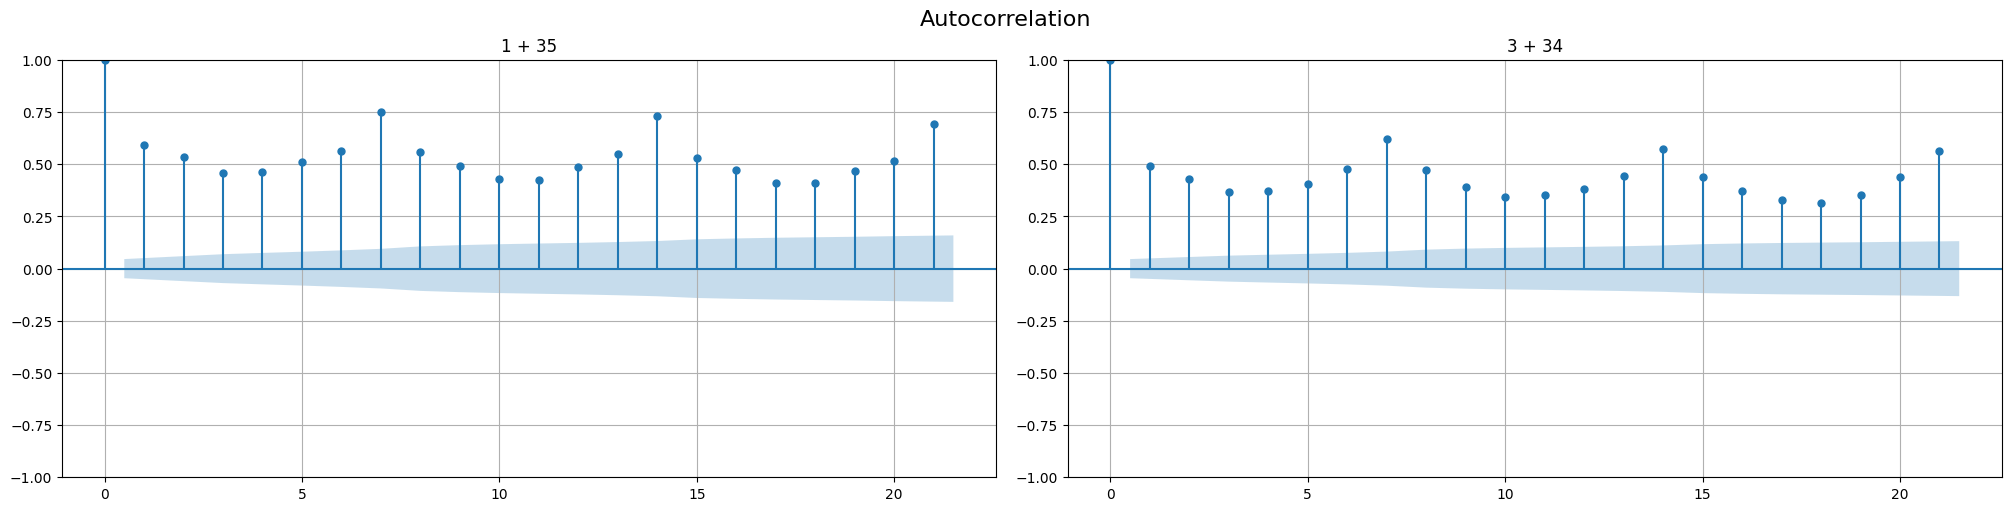

In [34]:
# Построение графиков ACF и PACF
acf_plot(ts, lags=21, n_segments=2)

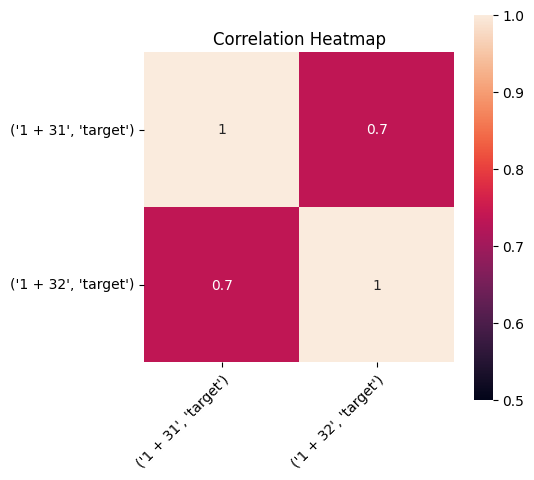

In [35]:
plot_correlation_matrix(ts, columns=['target'], segments=['1 + 31', "1 + 32", "10 + 49"],
                        method="spearman", vmin=0.5, vmax=1, figsize=(5,5))

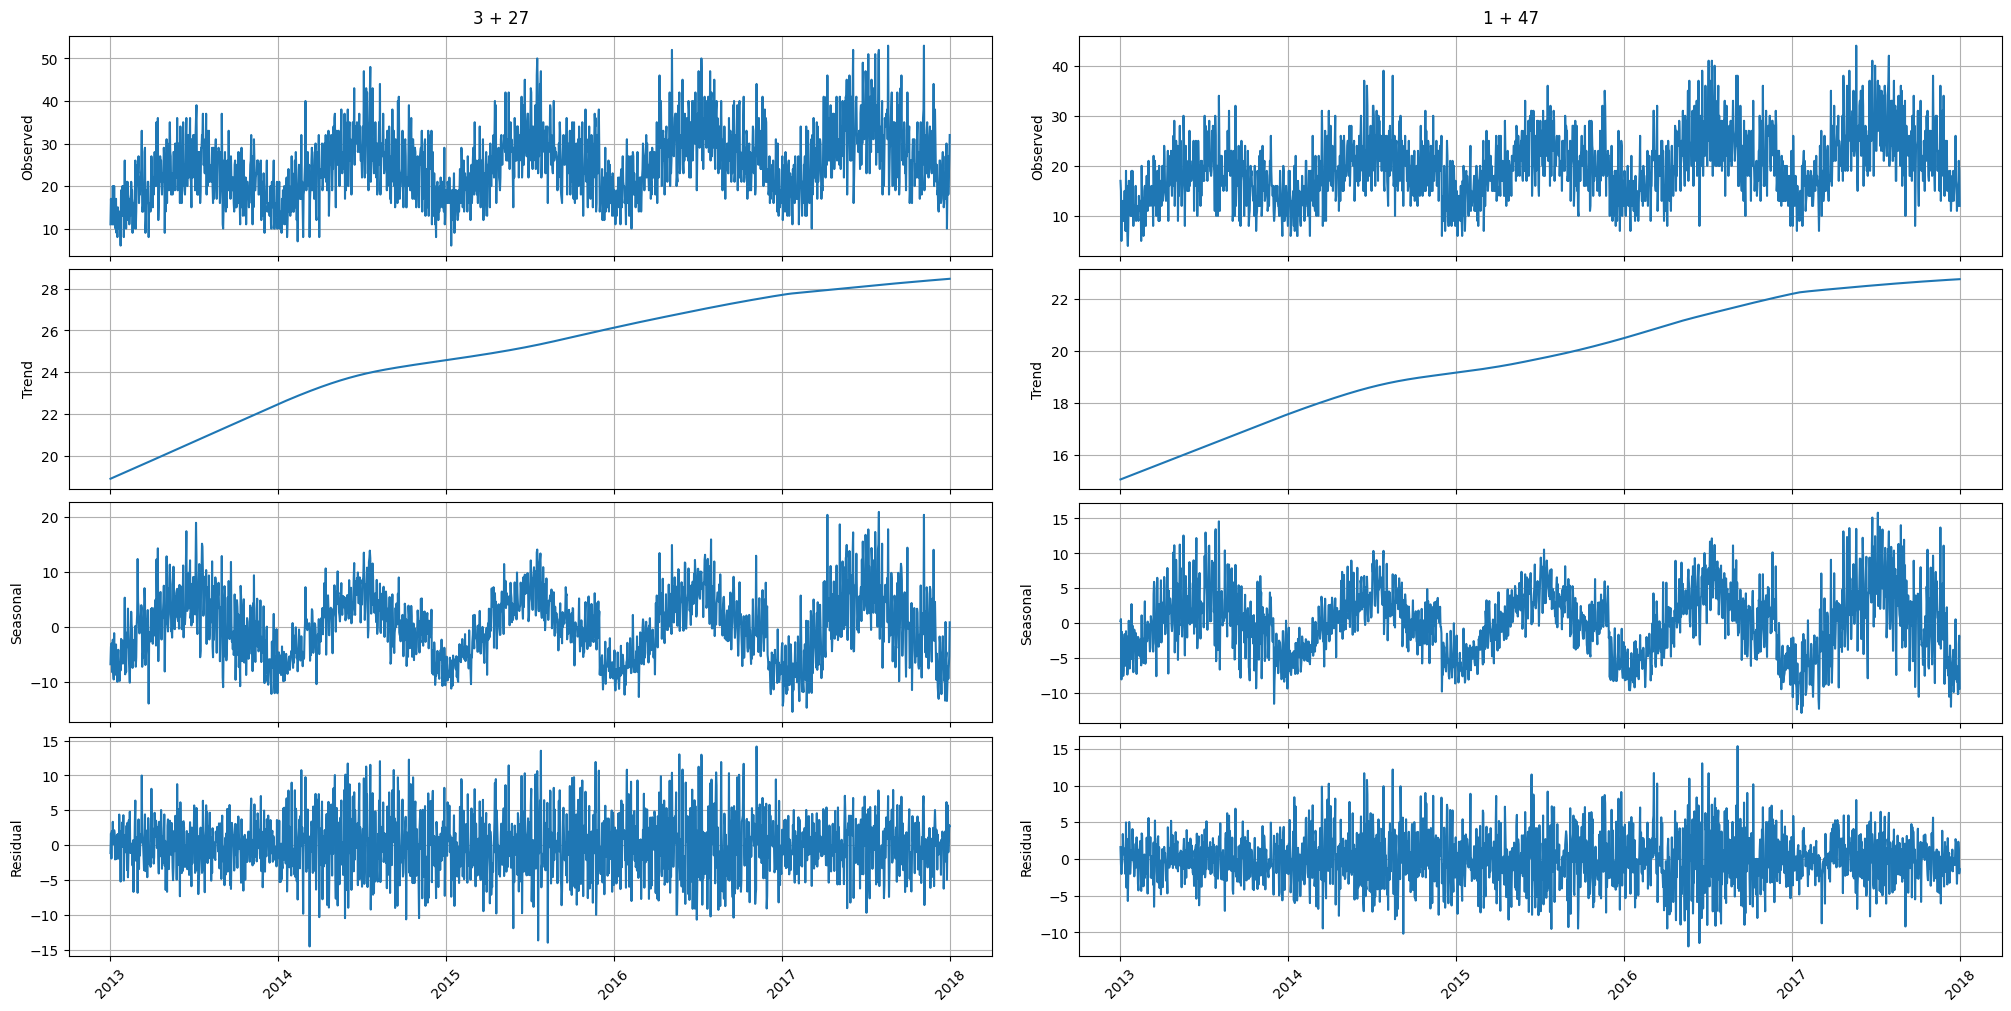

In [36]:
stl_plot(ts=ts, period=365, segments=SEGMENTS_TO_SHOW)

## Naive and Linear first models.

NaiveModel с рекурсивным прогнозированием.

NaiveModel без рекурсивного прогнозирования.

ElasticPerSegmentModel с рекурсивным прогнозированием и дополнительными преобразованиями данных.


Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 27.94174347082239


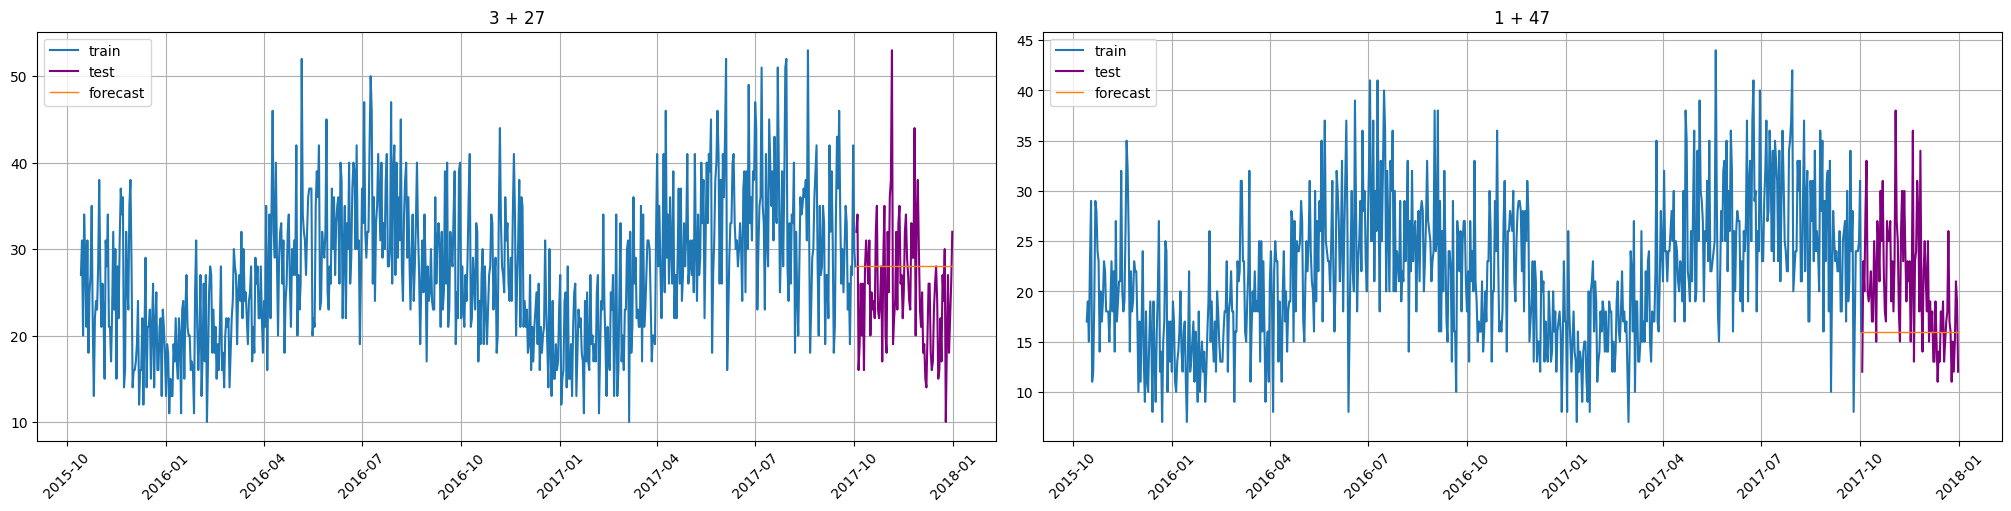

In [37]:
# Обучение и оценка модели Naive с рекурсивным прогнозированием
naive_model_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True,
    )

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 27.94174347082239


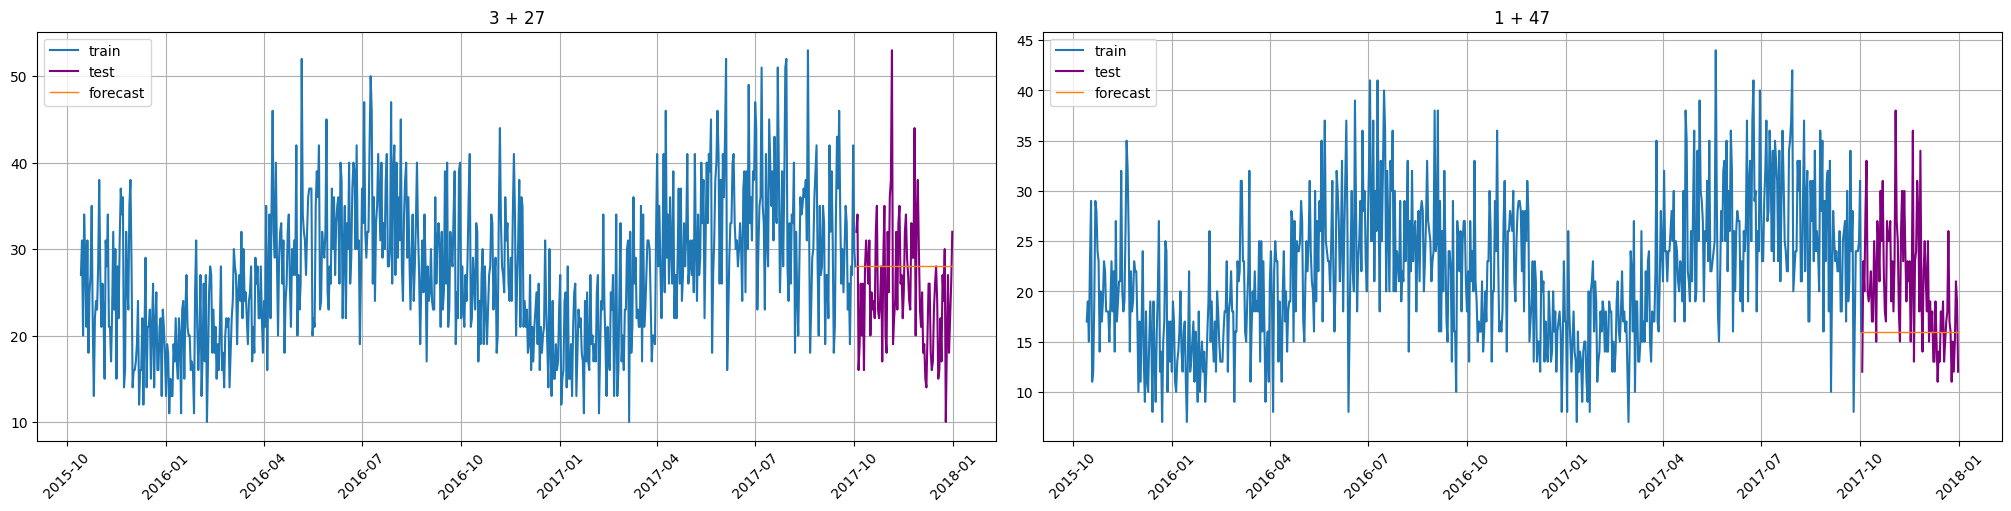

In [38]:
# Обучение и оценка модели Naive без рекурсивного прогнозирования
naive_model_NON_recursive_metrics = train_and_evaluate_model(
    ts=ts,
    model=NaiveModel(),
    transforms=[],
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

### Linear Model

In [39]:
standardscaler = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target',
                      window=7,
                      out_column='mean_7')


lags = LagTransform(in_column='target',
                    lags=[1],
                    out_column='lag')

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 20.709192527097827


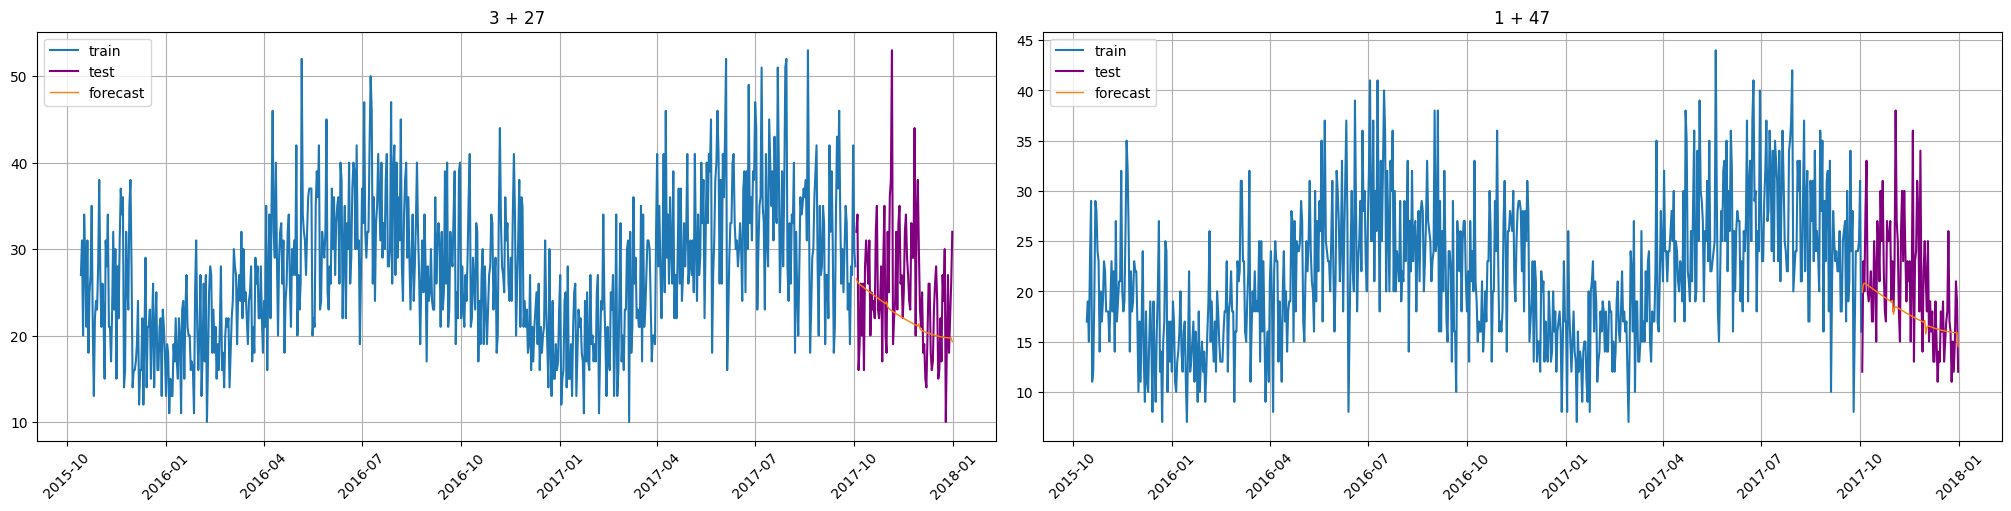

In [40]:
# Обучение и оценка модели ElasticPerSegment с рекурсивным прогнозированием
# занимает ~10 минут, так как мы используем рекурсивный пайплайн (который работает медленно)

elast_transforms = [lags, mean7, standardscaler]


linear_model_metrics = train_and_evaluate_model(
    ts=ts,
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
                                 random_state=42),
    transforms=elast_transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=True,
    print_metrics=True
    )

### Conclusion

In [41]:
# Сравнение результатов моделей
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...

### Backtest

Этот блок кода выполняет кросс-валидацию модели ElasticPerSegmentModel с рекурсивным прогнозированием и дополнительными преобразованиями данных. Используется метод backtest для оценки качества прогнозов на разных фолдах.

### тоже выполняется порядка 10 минут
pipe = AutoRegressivePipeline(
    model=ElasticPerSegmentModel(l1_ratio=0, alpha=0,
                                 random_state=42),
    transforms=elast_transforms,

    horizon=HORIZON)

metrics_df, _, _ = pipe.backtest(
    mode='expand',
    n_folds=5,
    ts=ts,
    metrics=[smape],
    aggregate_metrics=True,
    joblib_params=dict(backend='loky'),
    n_jobs=-1
)

In [42]:
#metrics_df.head(8)
#metric = metrics_df['SMAPE'].mean()
#print(f'mean SMAPE: {metric:.4f}')

## Transforms.

In [43]:
std = StandardScalerTransform(in_column=None)

mean7 = MeanTransform(in_column='target',
                      window=7,
                      out_column='mean_7',
                      seasonality=1)


lags = LagTransform(in_column='target',
                    lags=list(range(HORIZON, HORIZON+7)),
                    #lags=[1],
                    out_column='lag')

flag = DateFlagsTransform(day_number_in_week=True,
                    day_number_in_month=True, out_column='dateflag')

# Автоматическая импутация всех колонок
imp = TimeSeriesImputerTransform()

#transforms = [lags, mean7, standardscaler]
#transforms = [lags, mean7, flag, standardscaler]
#transforms = [lags, mean7, flag]
#transforms = [lags, mean7, flag, imp] # prophet 11.4
#transforms = [lags, mean7, flag, boxcox]
transforms = [imp, std, lags, mean7, flag]


In [44]:
# 2. Применение трансформаций
original = ts_no_exog.to_pandas()

transformed_ts = copy.deepcopy(ts_no_exog)
transformed_ts.fit_transform(transforms)
transformed = transformed_ts.to_pandas()


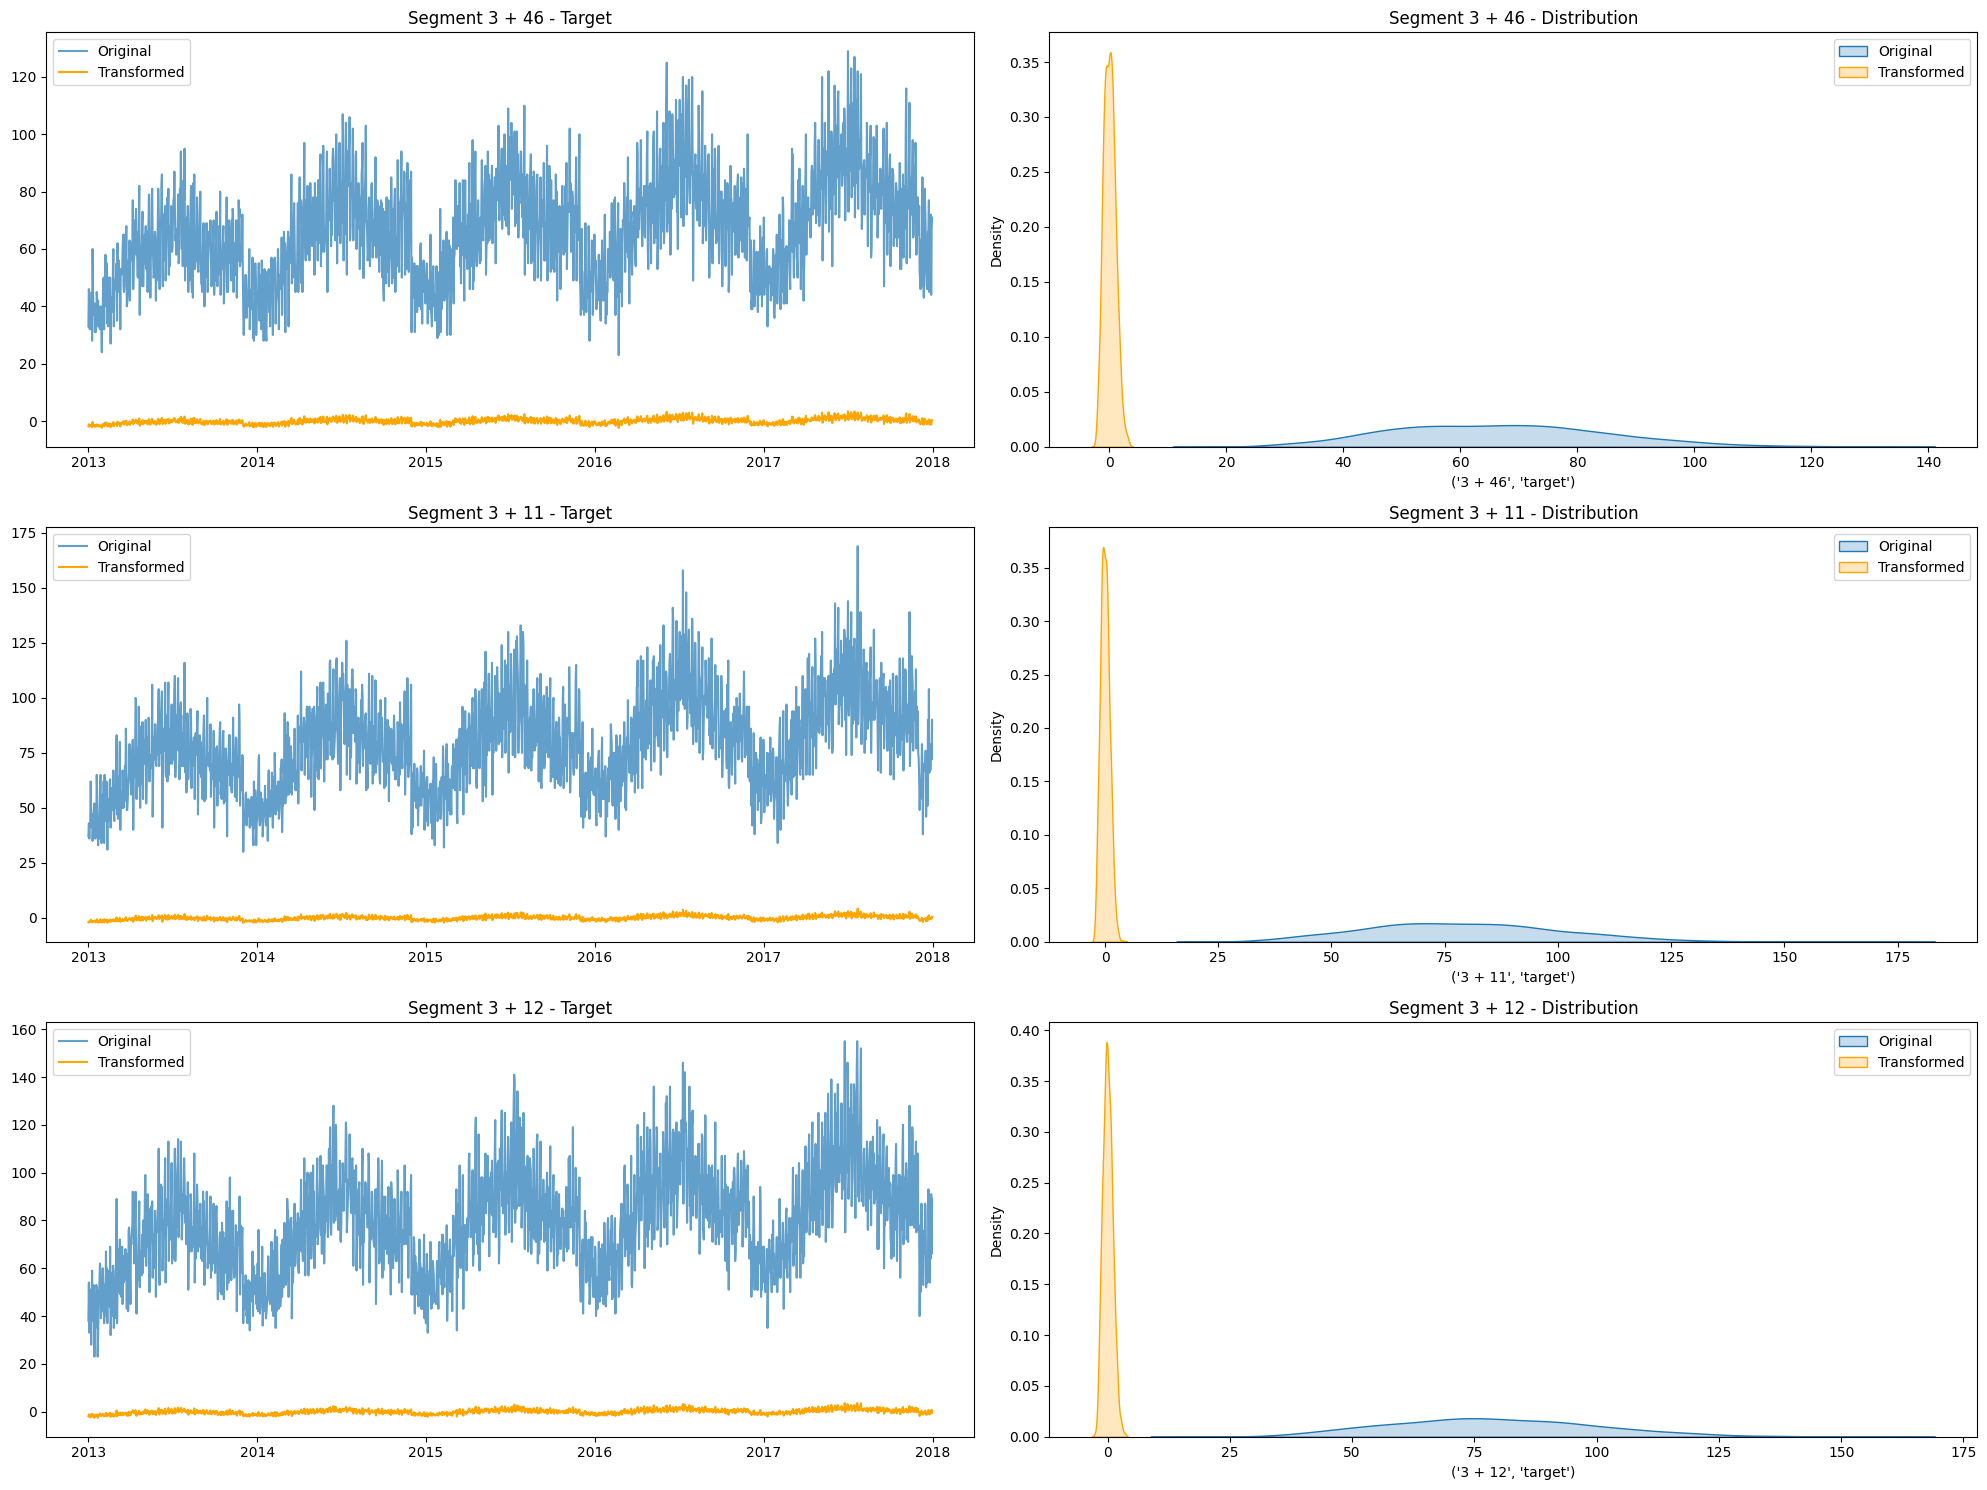

In [45]:
# Запуск визуализации
plot_transformed_data(ts_no_exog, transformed_ts)

In [46]:

from etna.transforms import *
### 1. Трансформации временных меток

# Дата-флаги
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    out_column='dateflag'
)

# Праздники
holidays = HolidayTransform(iso_code="US", out_column="holiday_flag"),

# Временные флаги
time_flags = TimeFlagsTransform(
    minute_in_hour_number=True,
    hour_number=True
)

### 2. Статистические трансформации


# Лаги
#lags = LagTransform(
#    in_column='target',
#    lags=[1, 7, 30],
#    out_column='lag'
#)

lags = LagTransform(in_column='target',
                    lags=list(range(HORIZON, HORIZON+7)),
                    #lags=[1],
                    out_column='lag')

# Скользящее среднее
mean_transform = MeanTransform(
    in_column='target',
    window=7,
    out_column='mean_7'
)

# Стандартизация
scaler = StandardScalerTransform(in_column='target')


### 3. Преобразования распределения


# Box-Cox
boxcox = BoxCoxTransform(
    in_column='target',
    out_column='boxcox',
    mode='per-segment'
)

yoj = YeoJohnsonTransform(
    in_column="target"
)

# Логарифмирование
log_transform = LogTransform(
    in_column='target',
    out_column='log_target',
    inplace=False
)


### 4. Обработка выбросов


# Межквартильный размах
iqr_outliers = IQROutlierTransform(
    in_column='target',
    #window=30,
    seasonality=7
)

# Изоляционный лес
iforest_outliers = IForestOutlierTransform(
    in_column='target',
    contamination=0.05
)


### 5. Работа с пропусками


# Импутация
imputer = TimeSeriesImputerTransform(
    strategy='running_mean',
    window=7
)


### 6. Декомпозиция ряда


# STL декомпозиция
stl = STLTransform(
    in_column='target',
    period=7,
    robust=True
)

# Фурье-трансформация
fourier = FourierTransform(
    period=7,
    order=3,
    out_column='fourier'
)

minmax_scaler = MinMaxScalerTransform(in_column='target')



# Создаем список трансформаций для эксперимента

transforms = [
    imputer,          # Сначала импутация
    #holidays,
    iqr_outliers,     # Затем обработка выбросов
    date_flags,
    lags,
    mean_transform,
    #minmax_scaler,    # Или StandardScalerTransform
    fourier
]


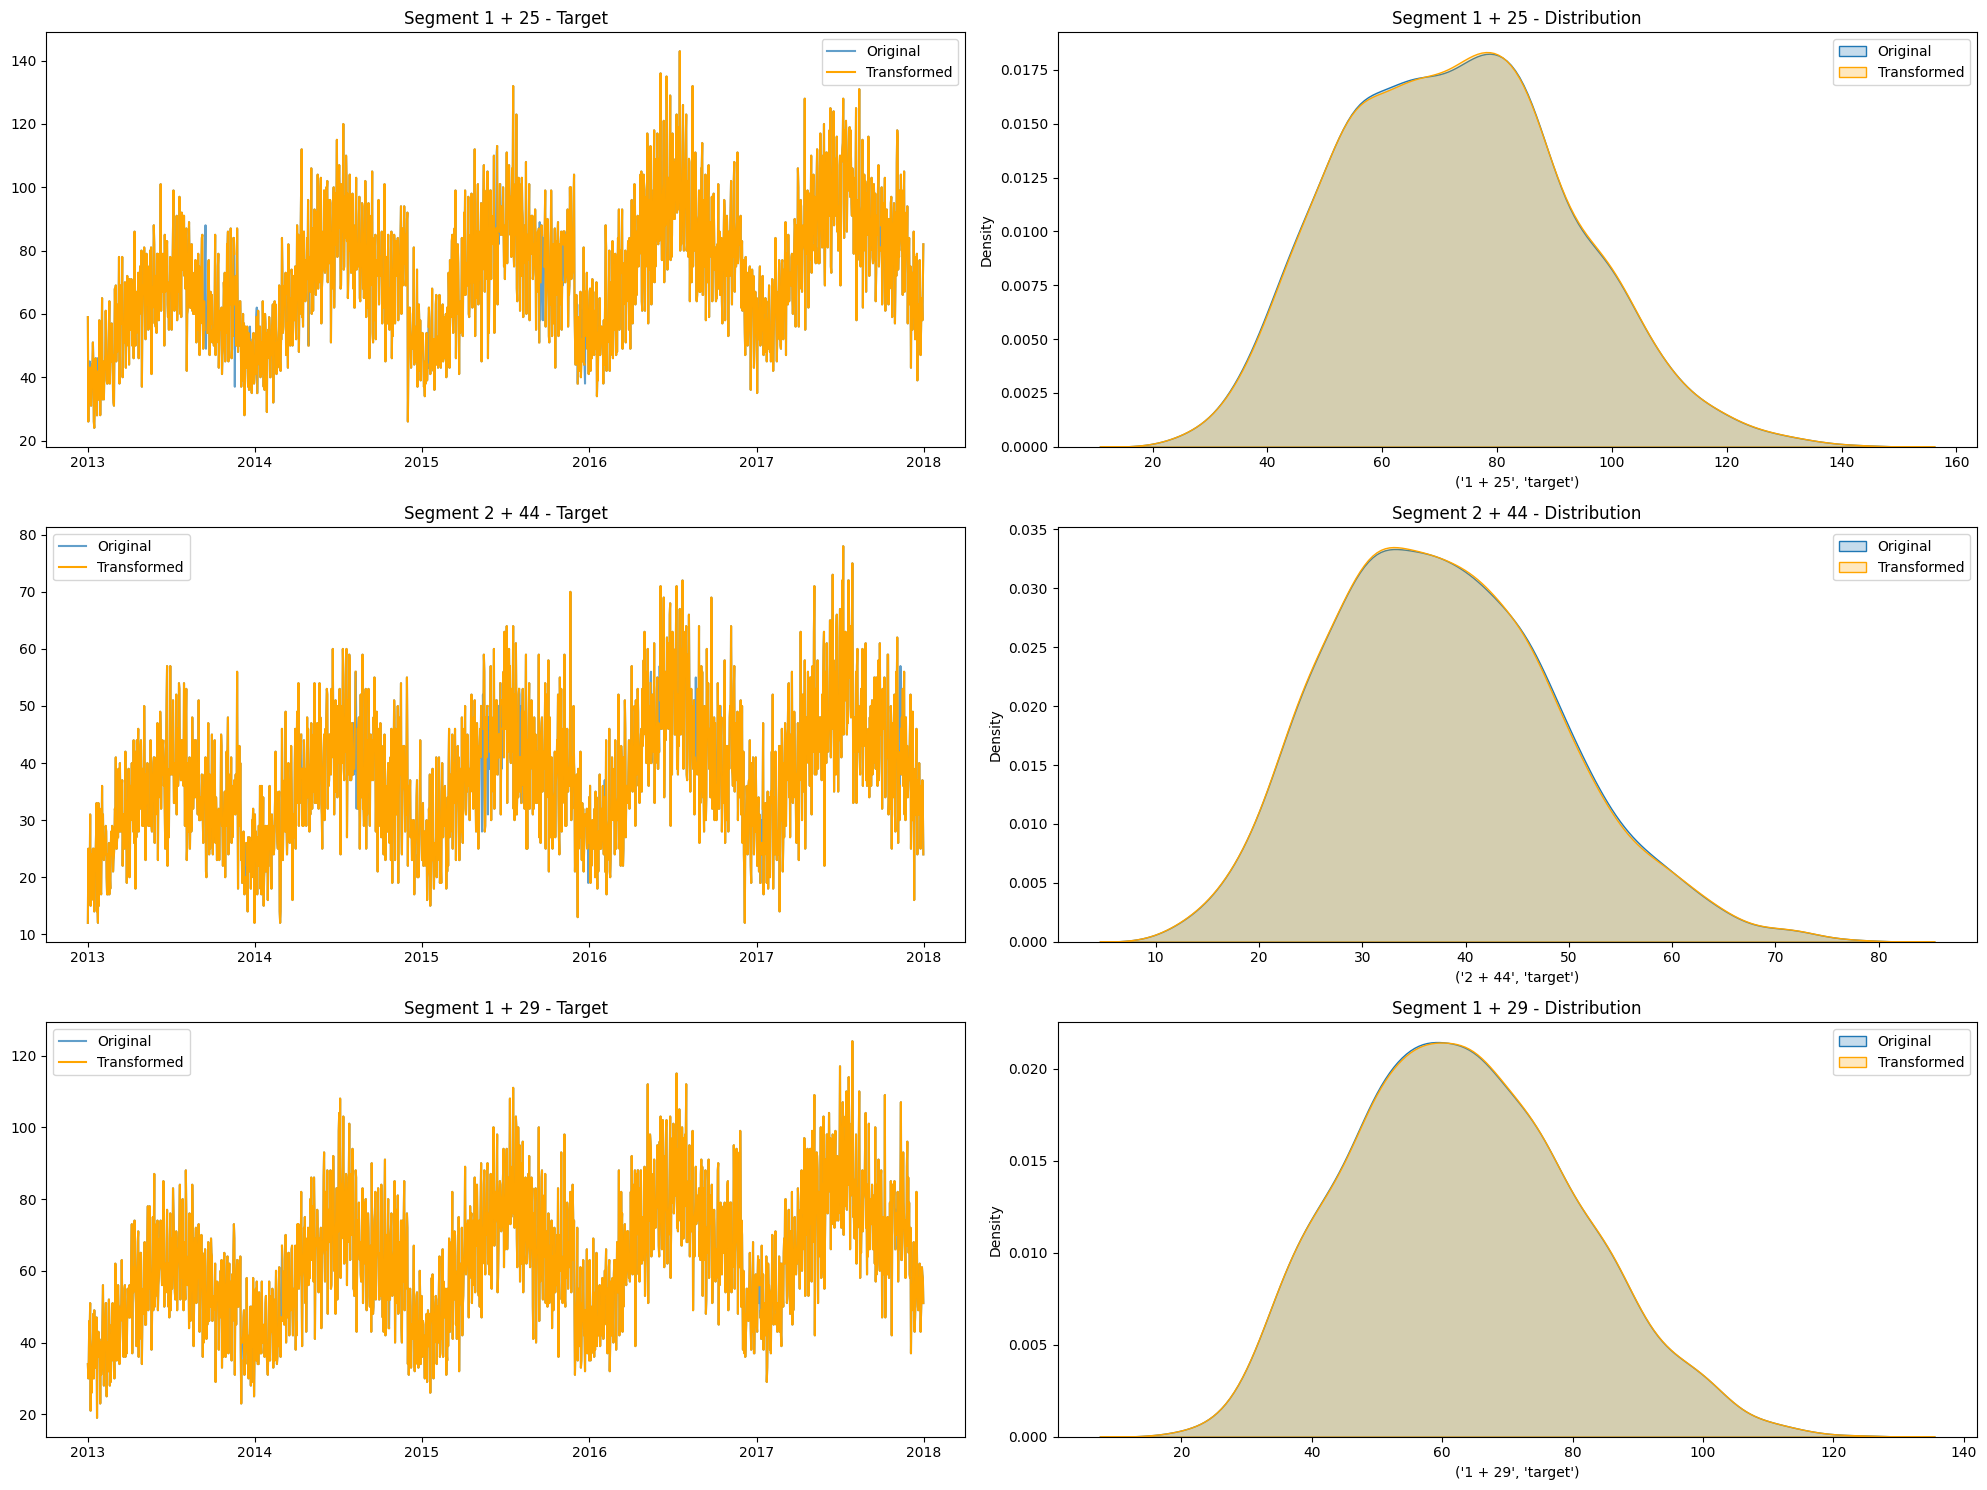

In [47]:
# 2. Применение трансформаций
original = ts_no_exog.to_pandas()

transformed_ts = copy.deepcopy(ts_no_exog)
transformed_ts.fit_transform(transforms)
transformed = transformed_ts.to_pandas()

# Запуск визуализации
plot_transformed_data(ts_no_exog, transformed_ts)

## Catboost

In [48]:
transforms = [
    MeanTransform(in_column="target", window=7),

    LagTransform(in_column='target',
                    lags=list(range(HORIZON, HORIZON+7)),
                    out_column='lag'),

    DateFlagsTransform(day_number_in_week=True,
                       day_number_in_month=True,
                       out_column='dateflag')
]

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 38.80779779542282


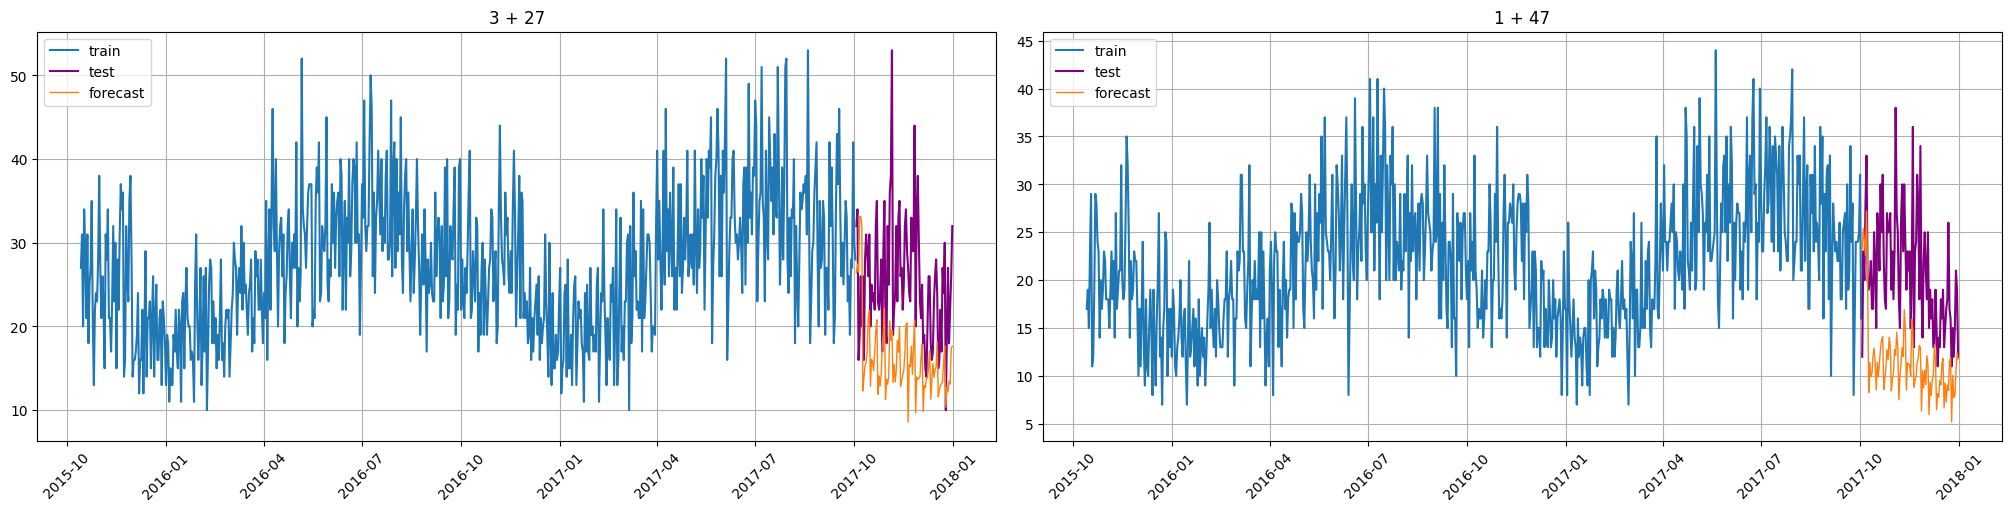

In [49]:
catboost_with_transform = train_and_evaluate_model(
    ts=ts,
    model=CatBoostPerSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 43.49493046781347


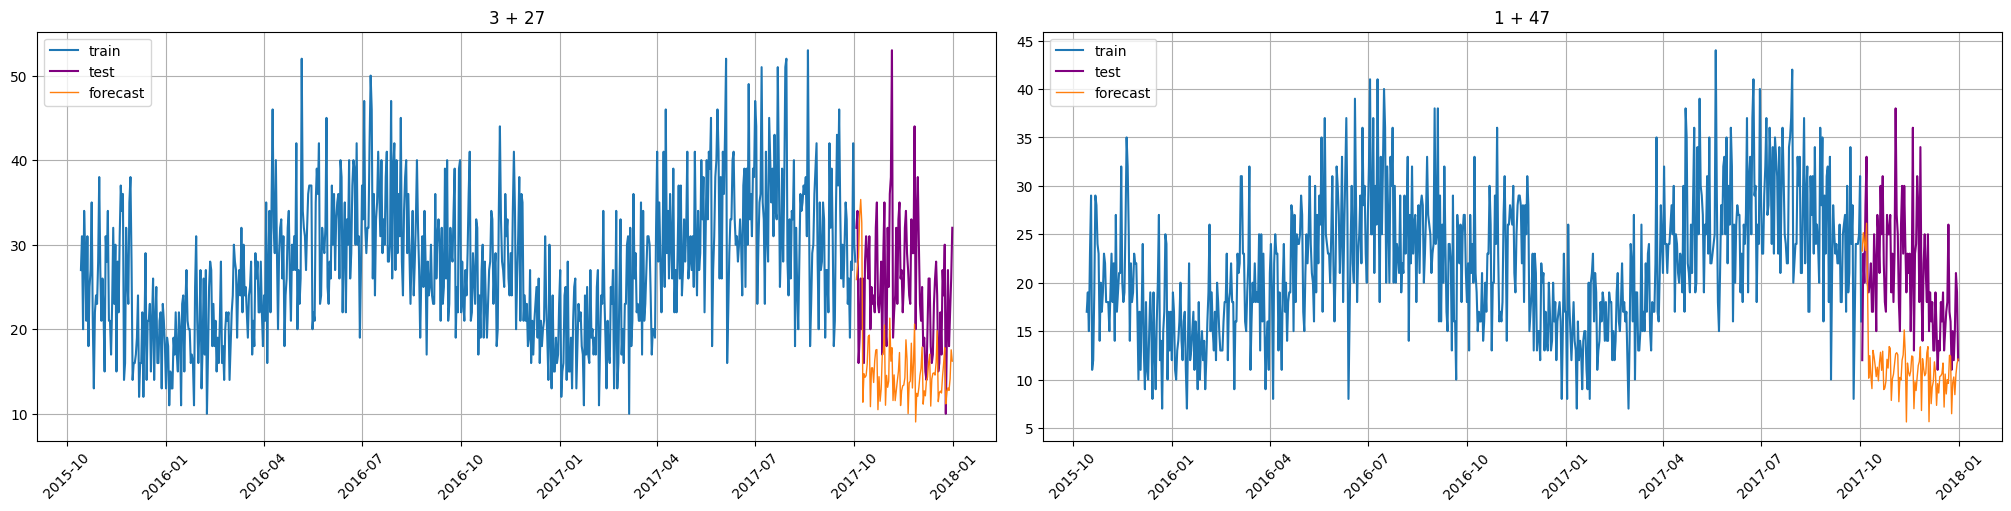

In [50]:
catboost_no_exog = train_and_evaluate_model(
    ts=ts_no_exog,
    model=CatBoostPerSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

In [51]:
# Сравнение результатов моделей
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
    'catboost_with_transform': catboost_with_transform,
    'catboost_no_exog': catboost_no_exog,
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...

## Feature importances

CatBoostMultiSegmentModel:

Преимущества: Может учиться на всех доступных данных, что может улучшить общие показатели модели.

Недостатки: Может не учитывать уникальные характеристики каждого сегмента.

CatBoostPerSegmentModel:

Преимущества: Может адаптироваться к специфике каждого сегмента, что может улучшить точность прогнозов для каждого сегмента.

Недостатки: Требует больше ресурсов для обучения и хранения моделей.


In [52]:
model=CatBoostMultiSegmentModel() # сменил модель
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [53]:
metrics, forecasts, _ = pipeline.backtest(ts_no_exog, metrics=[SMAPE()], aggregate_metrics=True, n_folds=3)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.2min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s


In [54]:
print("SMAPE(mean): ",metrics.mean()["SMAPE"])

SMAPE(mean):  111.81356837526829


In [55]:
pipeline.fit(ts_no_exog)

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [MeanTransform(in_column = 'target', window = 7, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = None, ), LagTransform(in_column = 'target', lags = [90, 91, 92, 93, 94, 95, 96], out_column = 'lag', ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = 'dateflag', in_column = None, )], horizon = 90, )

In [56]:
model = pipeline.model._base_model.model

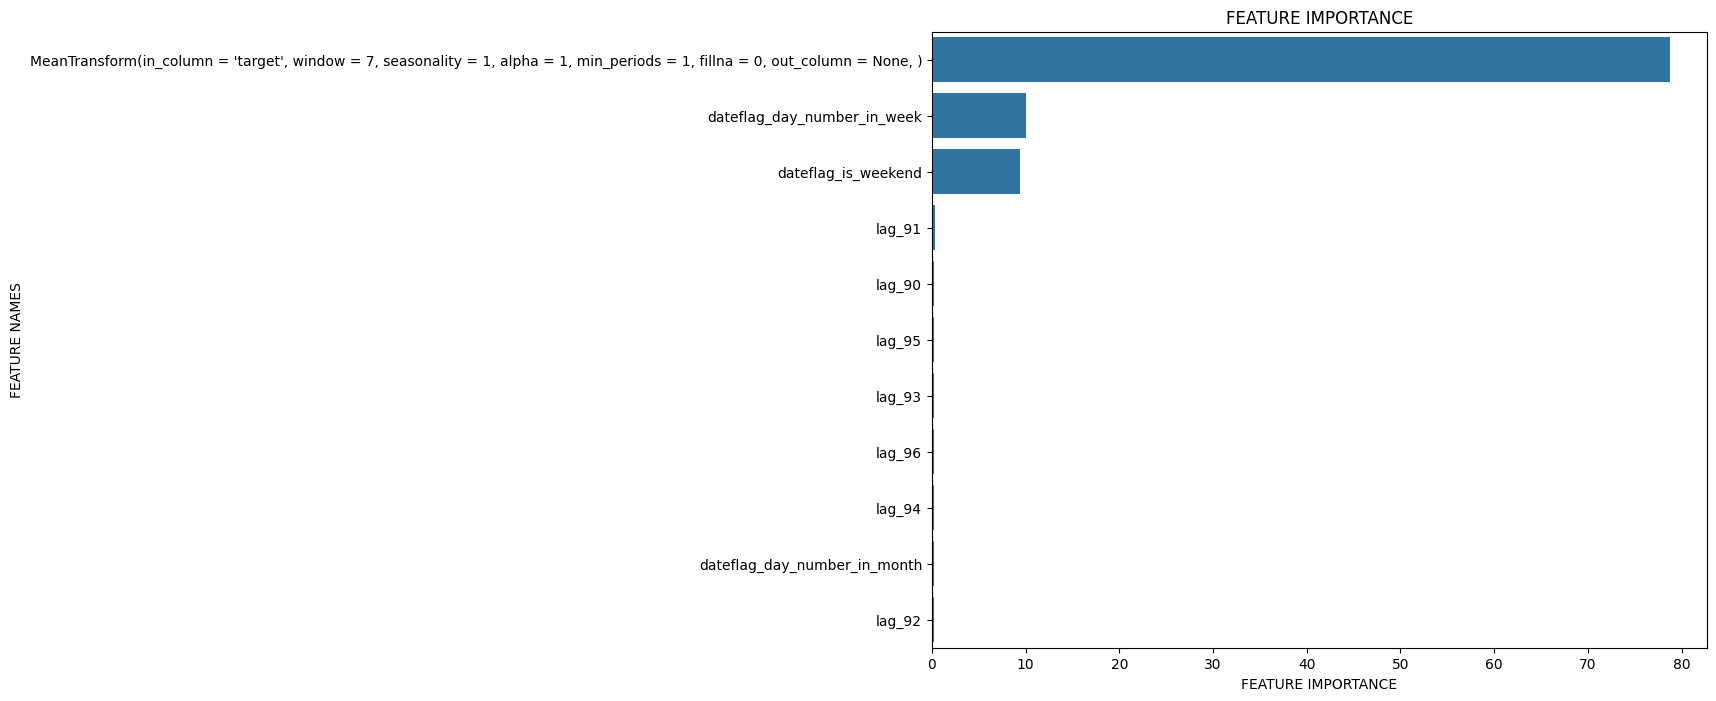

In [57]:
plot_feature_importance(model.get_feature_importance(), model.feature_names_)

In [58]:
#Трансформации
transforms = [
    HolidayTransform(iso_code="US", out_column="holiday_flag"),
    
    LagTransform(in_column='target',
                    lags=list(range(HORIZON, HORIZON+7)),
                    out_column='lag'
    ),

    MeanTransform(
        in_column="target",
        window=7,
        out_column="mean_7"
    ),
    MeanTransform(
        in_column="target",
        window=2,
        out_column="mean_2"
    ),


   

    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        day_number_in_year=True,
        week_number_in_month=True,
        out_column='dateflag'
    )
]

In [59]:
#model=CatBoostMultiSegmentModel() # сменил модель
#pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

#metrics, forecasts, _ = pipeline.backtest(ts_no_exog, metrics=[SMAPE()], aggregate_metrics=True, n_folds=3)
#print("SMAPE(mean): ",metrics.mean()["SMAPE"])

#pipeline.fit(ts_no_exog)

#model = pipeline.model._base_model.model

#plot_feature_importance(model.get_feature_importance(), model.feature_names_)

## SeasonalMovingAverageModel

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 19.8754626911


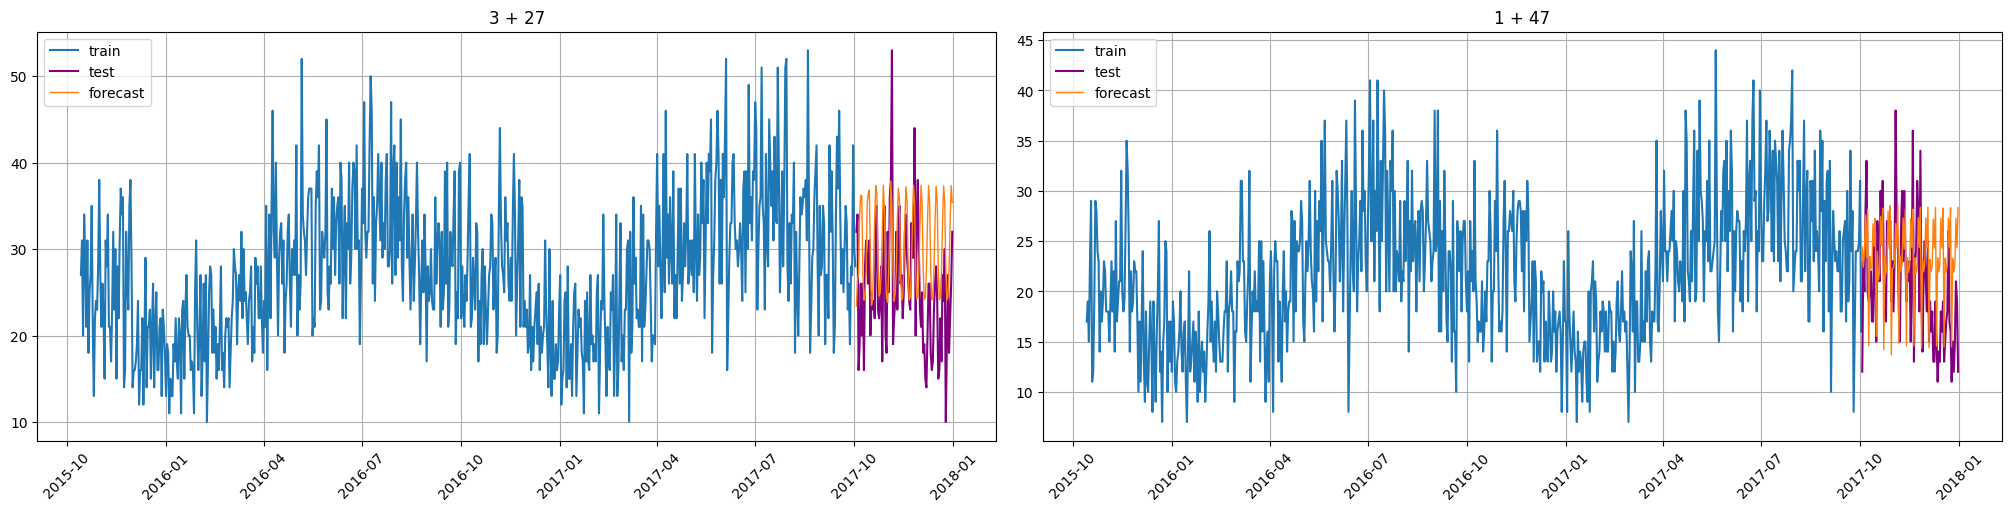

In [60]:
seasonal_moving_average = train_and_evaluate_model(
    ts=ts,
    model=SeasonalMovingAverageModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 19.8754626911


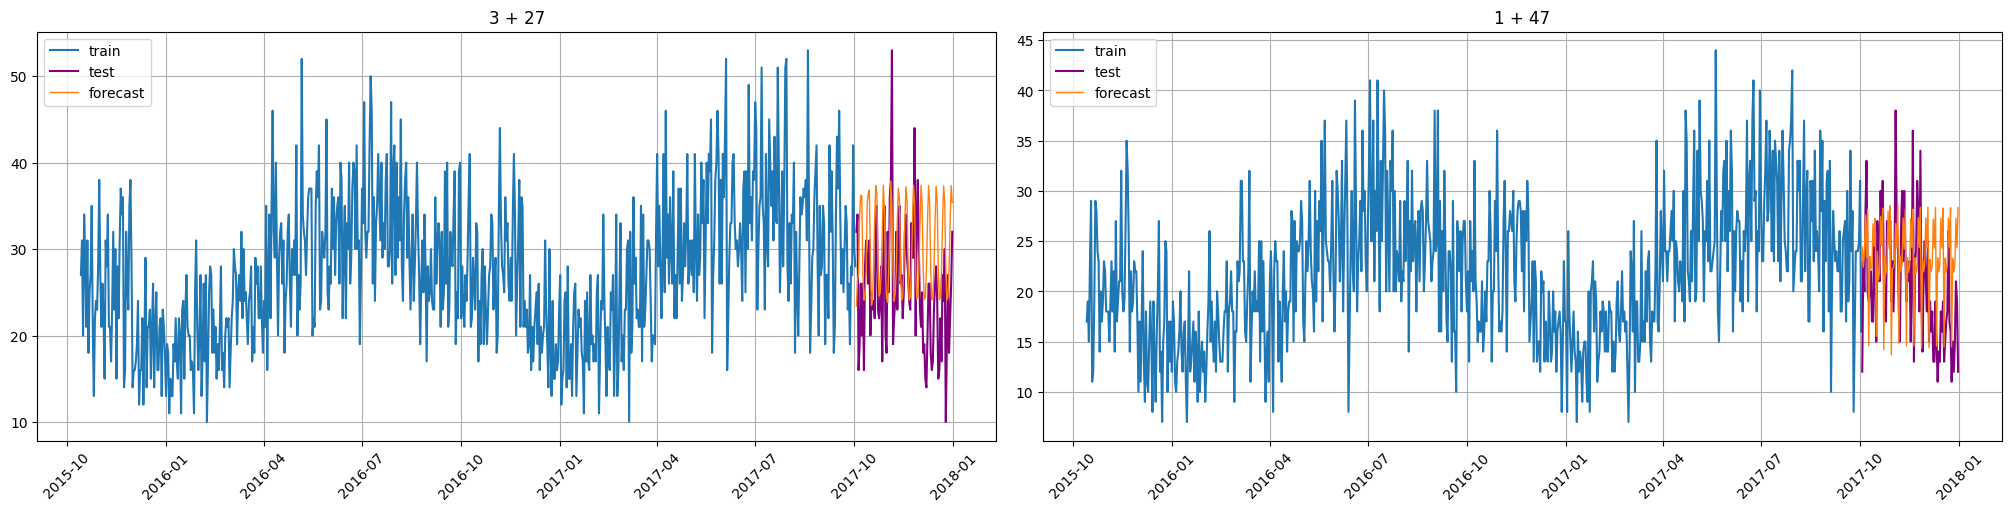

In [61]:
# Праздники
seasonal_no_exog = HolidayTransform(iso_code="US", out_column="holiday_flag"),

seasonal_holidays = train_and_evaluate_model(
    ts=ts,
    model=SeasonalMovingAverageModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    )

In [62]:
# Сравнение результатов моделей
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
    'catboost_with_transform': catboost_with_transform,
    'catboost_no_exog': catboost_no_exog,
    'seasonal_moving_average': seasonal_moving_average,
    #'seasonal_no_exog': seasonal_no_exog,
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   
4        seasonal_moving_average   19.875463   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...  
4  1 + 1     28.479271
1 + 10    19.638362
1 + 11...

## Prophet

в итоге убраны экзогенные переменные из трансформаций только флаги

In [63]:
# создаем NO EXOG
ts_no_exog = TSDataset(df=df, freq='D', known_future='all')

In [64]:
#Трансформации
transforms = [
    #HolidayTransform(iso_code="US", out_column="holiday_flag"),
    
    #LagTransform(in_column='target',
     #               lags=list(range(HORIZON, HORIZON+7)),
      #              out_column='lag'
    #),

    #MeanTransform(
     #   in_column="target",
      #  window=7,
       # out_column="mean_7"
    #),
    #MeanTransform(
     #   in_column="target",
      #  window=2,
       # out_column="mean_2"
    #),


   DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    day_number_in_year=True,
    week_number_in_month=True,
    month_number_in_year=True,  # добавление месяца
    season_number=True,  # добавление сезона
    out_column='dateflag'
)

]

10:46:07 - cmdstanpy - INFO - Chain [1] start processing
10:46:08 - cmdstanpy - INFO - Chain [1] done processing
10:46:08 - cmdstanpy - INFO - Chain [1] start processing
10:46:09 - cmdstanpy - INFO - Chain [1] done processing
10:46:09 - cmdstanpy - INFO - Chain [1] start processing
10:46:10 - cmdstanpy - INFO - Chain [1] done processing
10:46:10 - cmdstanpy - INFO - Chain [1] start processing
10:46:11 - cmdstanpy - INFO - Chain [1] done processing
10:46:11 - cmdstanpy - INFO - Chain [1] start processing
10:46:12 - cmdstanpy - INFO - Chain [1] done processing
10:46:13 - cmdstanpy - INFO - Chain [1] start processing
10:46:13 - cmdstanpy - INFO - Chain [1] done processing
10:46:14 - cmdstanpy - INFO - Chain [1] start processing
10:46:14 - cmdstanpy - INFO - Chain [1] done processing
10:46:15 - cmdstanpy - INFO - Chain [1] start processing
10:46:15 - cmdstanpy - INFO - Chain [1] done processing
10:46:16 - cmdstanpy - INFO - Chain [1] start processing
10:46:16 - cmdstanpy - INFO - Chain [1]

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 11.969184394846938


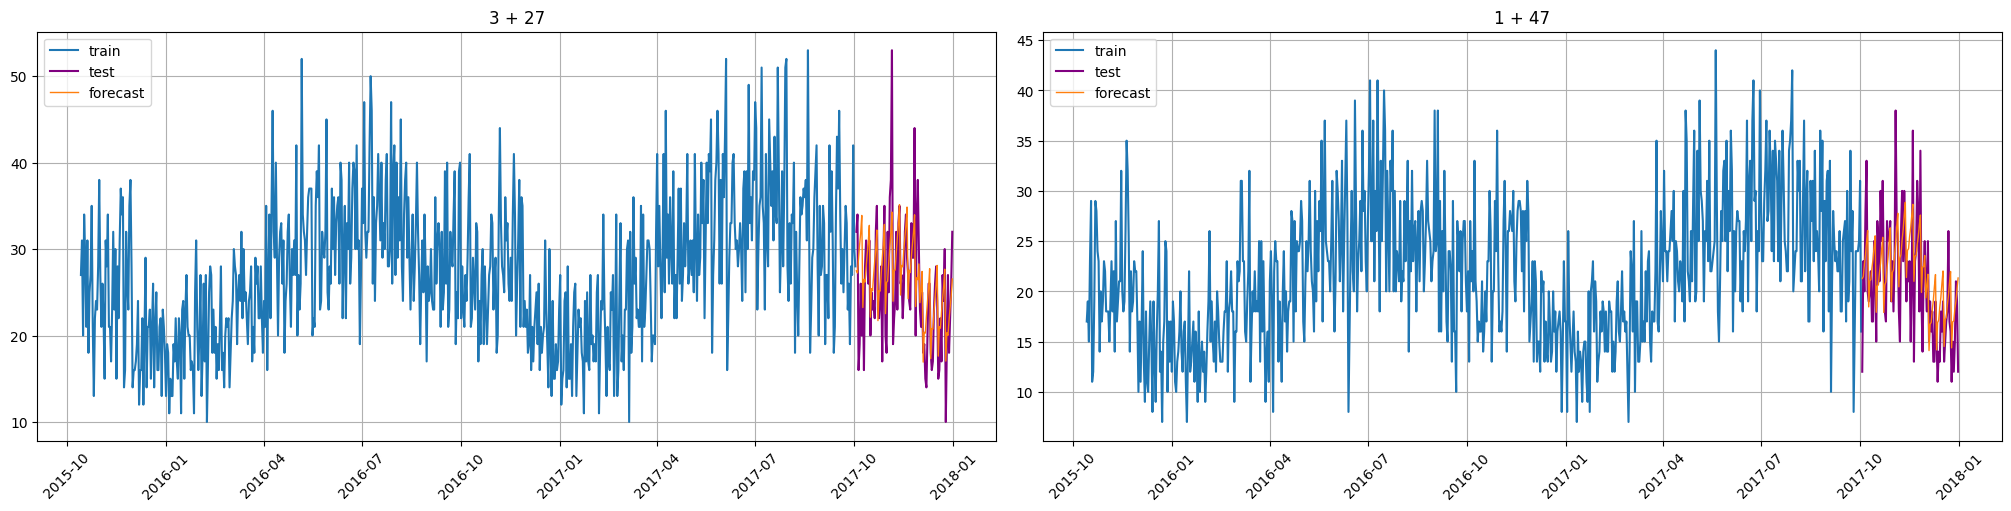

In [65]:
# !!! no exog !!!
prophet_no_exog_transform = train_and_evaluate_model(
    ts=ts_no_exog,
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    ) # no_exog 12.02(91)falg&mean 11.96(90) +holidays and lag 11.99, lag 11.98, flag&mean&holidays  11.97
    # mean&flag no mean7 11.968, just flag 11.968
    # нет mean убираю флаги по одному -day_number_in_week 11.968
    # -day_number_in_month 11.968
    # -day_number_in_year 11.969  
    # del prophet_no_exog_transform 11.969
    # week_number_in_month 11.976
    # вернул week_number_in_month - month_number_in_year 11.967
    # -season_number 12.541
    # только season_number 11.974
    # только season_number + holidays 11.981
    # season_number + mean7 11.974
    # season_number + mean2 11.974
    # season_number + mean2 + mean7 11.974
    # season_number + lag 19.81
    # season_number + day_number_in_week 11.974
    # season_number +day_number_in_year 11.974
    # все флаги 11.968

10:49:31 - cmdstanpy - INFO - Chain [1] start processing
10:49:32 - cmdstanpy - INFO - Chain [1] done processing
10:49:33 - cmdstanpy - INFO - Chain [1] start processing
10:49:34 - cmdstanpy - INFO - Chain [1] done processing
10:49:34 - cmdstanpy - INFO - Chain [1] start processing
10:49:36 - cmdstanpy - INFO - Chain [1] done processing
10:49:36 - cmdstanpy - INFO - Chain [1] start processing
10:49:39 - cmdstanpy - INFO - Chain [1] done processing
10:49:39 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:43 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:45 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:49 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1]

Avg (by segments) metric SMAPE(mode = 'per-segment', missing_mode = 'error', ) is: 11.995517247471545


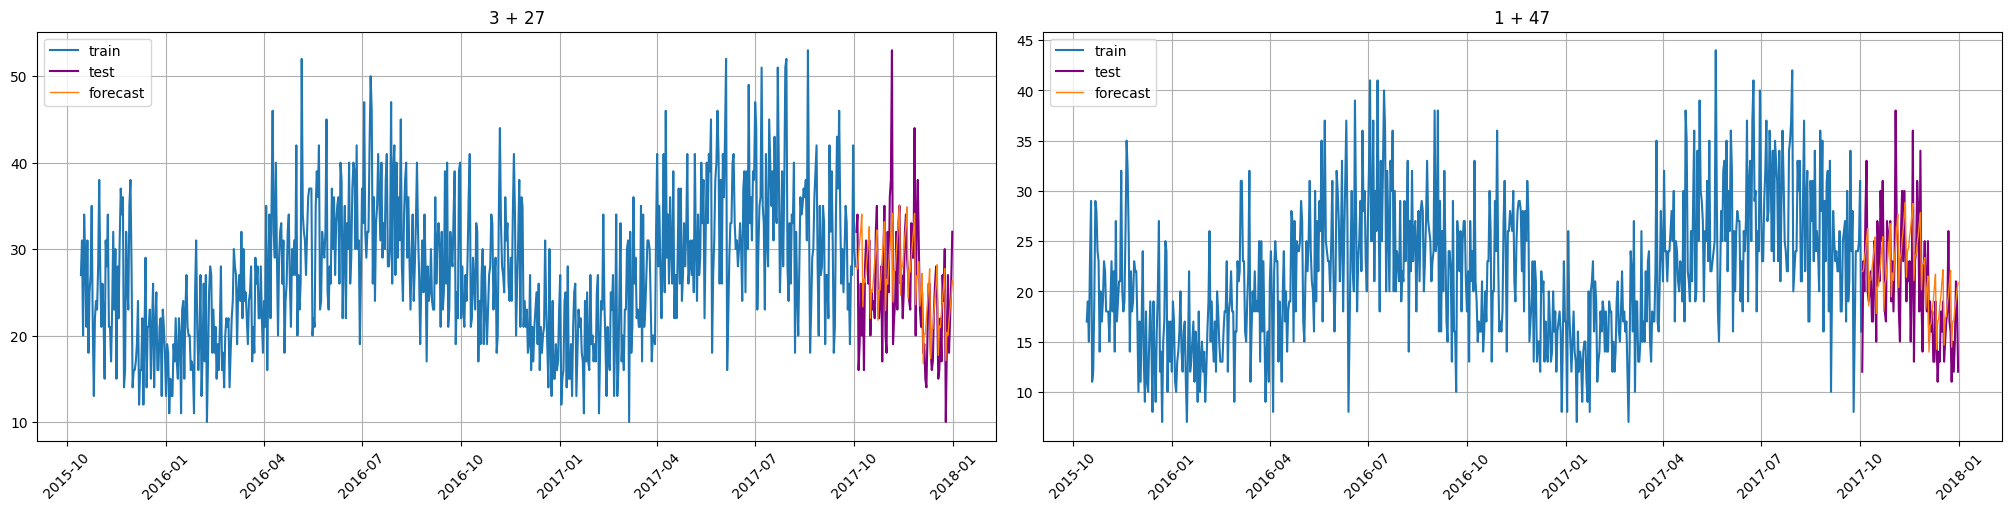

In [66]:
# !!! exog !!!
prophet_with_exog_transform = train_and_evaluate_model(
    ts=ts,
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True,
    ) # no_exog 12.02(91)falg&mean 11.96(90) +holidays and lag 11.99, lag 11.98, flag&mean&holidays  11.97
    # mean&flag no mean7 11.968, just flag 11.968
    # нет mean убираю флаги по одному -day_number_in_week 11.968
    # -day_number_in_month 11.968
    # -day_number_in_year 11.969  
    # del prophet_no_exog_transform 11.969
    # week_number_in_month 11.976
    # вернул week_number_in_month - month_number_in_year 11.967
    # -season_number 12.541
    # только season_number 11.974
    # только season_number + holidays 11.981
    # season_number + mean7 11.974
    # season_number + mean2 11.974
    # season_number + mean2 + mean7 11.974
    # season_number + lag 19.81
    # season_number + day_number_in_week 11.974
    # season_number +day_number_in_year 11.974
    # все флаги 11.968

In [67]:
# Сравнение результатов моделей
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
    'catboost_with_transform': catboost_with_transform,
    'catboost_no_exog': catboost_no_exog,
    'seasonal_moving_average': seasonal_moving_average,
    #'seasonal_no_exog': seasonal_no_exog,
    'prophet_no_exog_transform': prophet_no_exog_transform,
    'prophet_with_exog_transform': prophet_with_exog_transform
    
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   
4        seasonal_moving_average   19.875463   
5      prophet_no_exog_transform   11.969184   
6    prophet_with_exog_transform   11.995517   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...  
4  1 + 1     28.479271
1 + 10    19.638362
1 + 11...  
5  1 + 1     19.591706
1 + 10    11.179655
1 + 11...  
6  1 + 1     19.668700
1 + 10    11.291183
1 + 11...

## SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97642D+00    |proj g|=  1.59349D-01


 This problem is unconstrained.



At iterate    5    f=  2.96111D+00    |proj g|=  5.38034D-01

At iterate   10    f=  2.95405D+00    |proj g|=  7.49802D-02

At iterate   15    f=  2.95210D+00    |proj g|=  8.12449D-03

At iterate   20    f=  2.95173D+00    |proj g|=  1.35119D-01

At iterate   25    f=  2.95078D+00    |proj g|=  2.66352D-02

At iterate   30    f=  2.94934D+00    |proj g|=  5.35198D-02

At iterate   35    f=  2.94513D+00    |proj g|=  4.06241D-02

At iterate   40    f=  2.94505D+00    |proj g|=  1.54089D-02

At iterate   45    f=  2.94464D+00    |proj g|=  5.41628D-02

At iterate   50    f=  2.94076D+00    |proj g|=  1.63162D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67320D+00    |proj g|=  1.24881D-01

At iterate    5    f=  3.65934D+00    |proj g|=  2.04534D-01

At iterate   10    f=  3.65457D+00    |proj g|=  2.83716D-02

At iterate   15    f=  3.64491D+00    |proj g|=  1.73874D-02

At iterate   20    f=  3.64193D+00    |proj g|=  5.43110D-02

At iterate   25    f=  3.63312D+00    |proj g|=  6.27404D-03

At iterate   30    f=  3.63273D+00    |proj g|=  2.41121D-03

At iterate   35    f=  3.63234D+00    |proj g|=  3.33425D-03

At iterate   40    f=  3.63108D+00    |proj g|=  1.94097D-02

At iterate   45    f=  3.63101D+00    |proj g|=  1.75458D-04

At iterate   50    f=  3.63100D+00    |proj g|=  4.46944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.59726D+00    |proj g|=  9.75324D-03

At iterate   10    f=  3.59060D+00    |proj g|=  3.96150D-02

At iterate   15    f=  3.58798D+00    |proj g|=  1.39368D-01

At iterate   20    f=  3.58063D+00    |proj g|=  1.68775D-02

At iterate   25    f=  3.57864D+00    |proj g|=  1.78497D-02

At iterate   30    f=  3.57767D+00    |proj g|=  1.92746D-02

At iterate   35    f=  3.57748D+00    |proj g|=  2.18232D-03

At iterate   40    f=  3.57726D+00    |proj g|=  2.05435D-02

At iterate   45    f=  3.57570D+00    |proj g|=  4.83643D-03

At iterate   50    f=  3.57553D+00    |proj g|=  5.16045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62698D+00    |proj g|=  1.58485D-01

At iterate    5    f=  3.60463D+00    |proj g|=  1.37701D-01

At iterate   10    f=  3.60261D+00    |proj g|=  3.96016D-02

At iterate   15    f=  3.59977D+00    |proj g|=  8.69758D-03

At iterate   20    f=  3.59748D+00    |proj g|=  2.76875D-02

At iterate   25    f=  3.59494D+00    |proj g|=  2.31441D-03

At iterate   30    f=  3.59388D+00    |proj g|=  7.81177D-03

At iterate   35    f=  3.59327D+00    |proj g|=  1.99621D-04

At iterate   40    f=  3.59327D+00    |proj g|=  5.17768D-04

At iterate   45    f=  3.59326D+00    |proj g|=  7.24101D-04

At iterate   50    f=  3.59326D+00    |proj g|=  1.17776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34113D+01    |proj g|=  2.27850D+01

At iterate    5    f=  3.88280D+00    |proj g|=  4.72589D-01

At iterate   10    f=  3.74446D+00    |proj g|=  5.99580D-01

At iterate   15    f=  3.71221D+00    |proj g|=  8.31951D-02

At iterate   20    f=  3.69895D+00    |proj g|=  2.35823D-02

At iterate   25    f=  3.69576D+00    |proj g|=  2.30387D-02

At iterate   30    f=  3.69380D+00    |proj g|=  4.58258D-02

At iterate   35    f=  3.68900D+00    |proj g|=  3.74586D-02

At iterate   40    f=  3.68858D+00    |proj g|=  4.14102D-03

At iterate   45    f=  3.68854D+00    |proj g|=  6.01717D-03

At iterate   50    f=  3.68757D+00    |proj g|=  8.51338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55251D+00    |proj g|=  1.57744D-01

At iterate    5    f=  3.52582D+00    |proj g|=  3.83653D-02

At iterate   10    f=  3.52385D+00    |proj g|=  5.29427D-02

At iterate   15    f=  3.51999D+00    |proj g|=  2.38909D-02

At iterate   20    f=  3.51533D+00    |proj g|=  5.06838D-02

At iterate   25    f=  3.51458D+00    |proj g|=  1.68567D-02

At iterate   30    f=  3.51420D+00    |proj g|=  2.25170D-02

At iterate   35    f=  3.51311D+00    |proj g|=  1.74735D-02

At iterate   40    f=  3.51178D+00    |proj g|=  5.56790D-03

At iterate   45    f=  3.51147D+00    |proj g|=  2.25662D-02

At iterate   50    f=  3.51131D+00    |proj g|=  5.82238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.76498D+00    |proj g|=  9.37605D-03

At iterate   10    f=  3.75785D+00    |proj g|=  1.83285D-02

At iterate   15    f=  3.75301D+00    |proj g|=  4.73999D-02

At iterate   20    f=  3.75108D+00    |proj g|=  2.19665D-02

At iterate   25    f=  3.75017D+00    |proj g|=  1.59688D-03

At iterate   30    f=  3.75010D+00    |proj g|=  1.03036D-03

At iterate   35    f=  3.74998D+00    |proj g|=  1.07232D-02

At iterate   40    f=  3.74921D+00    |proj g|=  2.93786D-02

At iterate   45    f=  3.74807D+00    |proj g|=  6.54839D-03

At iterate   50    f=  3.74805D+00    |proj g|=  1.49226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07862D+00    |proj g|=  1.99643D-01

At iterate    5    f=  3.06834D+00    |proj g|=  2.23016D-01

At iterate   10    f=  3.05256D+00    |proj g|=  6.15412D-03

At iterate   15    f=  3.05181D+00    |proj g|=  1.35078D-02

At iterate   20    f=  3.05146D+00    |proj g|=  6.00891D-02

At iterate   25    f=  3.05091D+00    |proj g|=  2.70134D-02

At iterate   30    f=  3.04980D+00    |proj g|=  4.05844D-02

At iterate   35    f=  3.04972D+00    |proj g|=  2.29002D-03

At iterate   40    f=  3.04969D+00    |proj g|=  1.48128D-02

At iterate   45    f=  3.04965D+00    |proj g|=  8.72377D-03

At iterate   50    f=  3.04960D+00    |proj g|=  2.11768D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.38317D+00    |proj g|=  1.56794D+00

At iterate   10    f=  3.27362D+00    |proj g|=  1.41412D-01

At iterate   15    f=  3.26721D+00    |proj g|=  3.54425D-01

At iterate   20    f=  3.20996D+00    |proj g|=  1.99227D-01

At iterate   25    f=  3.18957D+00    |proj g|=  2.40595D-02

At iterate   30    f=  3.17903D+00    |proj g|=  5.94333D-02

At iterate   35    f=  3.17847D+00    |proj g|=  4.77469D-03

At iterate   40    f=  3.17652D+00    |proj g|=  3.81907D-02

At iterate   45    f=  3.17629D+00    |proj g|=  6.54439D-03

At iterate   50    f=  3.17616D+00    |proj g|=  2.62174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75301D+00    |proj g|=  1.25831D-01

At iterate    5    f=  3.72525D+00    |proj g|=  1.07856D-02

At iterate   10    f=  3.72064D+00    |proj g|=  3.26480D-03

At iterate   15    f=  3.71575D+00    |proj g|=  4.31011D-02

At iterate   20    f=  3.71561D+00    |proj g|=  2.80022D-03

At iterate   25    f=  3.71469D+00    |proj g|=  4.40856D-03

At iterate   30    f=  3.71393D+00    |proj g|=  2.12239D-03

At iterate   35    f=  3.71390D+00    |proj g|=  4.10668D-04

At iterate   40    f=  3.71389D+00    |proj g|=  4.73743D-04

At iterate   45    f=  3.71388D+00    |proj g|=  1.73346D-03

At iterate   50    f=  3.71387D+00    |proj g|=  3.57980D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.71090D+00    |proj g|=  3.20312D+00

At iterate   10    f=  3.42761D+00    |proj g|=  1.35096D-01

At iterate   15    f=  3.39806D+00    |proj g|=  1.34501D+00

At iterate   20    f=  3.34564D+00    |proj g|=  1.81829D-01

At iterate   25    f=  3.34114D+00    |proj g|=  1.74856D-01

At iterate   30    f=  3.32926D+00    |proj g|=  2.50444D-01

At iterate   35    f=  3.32585D+00    |proj g|=  1.00049D-01

At iterate   40    f=  3.32282D+00    |proj g|=  3.35966D-03

At iterate   45    f=  3.32275D+00    |proj g|=  7.59894D-03

At iterate   50    f=  3.32188D+00    |proj g|=  7.70279D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.52015D+00    |proj g|=  7.13666D-02

At iterate   10    f=  3.51814D+00    |proj g|=  1.14954D-02

At iterate   15    f=  3.51432D+00    |proj g|=  1.62567D-02

At iterate   20    f=  3.50985D+00    |proj g|=  5.97844D-03

At iterate   25    f=  3.50971D+00    |proj g|=  1.26135D-03

At iterate   30    f=  3.50947D+00    |proj g|=  5.07490D-02

At iterate   35    f=  3.50762D+00    |proj g|=  1.91912D-02

At iterate   40    f=  3.50757D+00    |proj g|=  6.50128D-04

At iterate   45    f=  3.50757D+00    |proj g|=  1.26448D-03

At iterate   50    f=  3.50755D+00    |proj g|=  1.70296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69302D+01    |proj g|=  2.75275D+01

At iterate    5    f=  3.47748D+00    |proj g|=  7.51064D-01

At iterate   10    f=  3.43236D+00    |proj g|=  4.00881D-01

At iterate   15    f=  3.39006D+00    |proj g|=  3.82286D-02

At iterate   20    f=  3.36503D+00    |proj g|=  8.02081D-02

At iterate   25    f=  3.36293D+00    |proj g|=  4.81005D-03

At iterate   30    f=  3.36152D+00    |proj g|=  4.69006D-02

At iterate   35    f=  3.36013D+00    |proj g|=  1.83806D-03

At iterate   40    f=  3.35964D+00    |proj g|=  2.20603D-02

At iterate   45    f=  3.35806D+00    |proj g|=  2.88415D-03

At iterate   50    f=  3.35803D+00    |proj g|=  3.09295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.31738D+00    |proj g|=  4.17199D-02

At iterate   10    f=  3.31692D+00    |proj g|=  6.34830D-02

At iterate   15    f=  3.31308D+00    |proj g|=  6.84283D-02

At iterate   20    f=  3.31206D+00    |proj g|=  1.52335D-01

At iterate   25    f=  3.30416D+00    |proj g|=  4.20819D-02

At iterate   30    f=  3.30333D+00    |proj g|=  8.80857D-02

At iterate   35    f=  3.30319D+00    |proj g|=  8.42259D-03

At iterate   40    f=  3.30301D+00    |proj g|=  1.48113D-02

At iterate   45    f=  3.30280D+00    |proj g|=  2.20955D-02

At iterate   50    f=  3.30022D+00    |proj g|=  1.37319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.72139D+00    |proj g|=  7.21180D-02

At iterate   10    f=  3.72005D+00    |proj g|=  5.17328D-02

At iterate   15    f=  3.71515D+00    |proj g|=  1.35101D-02

At iterate   20    f=  3.71437D+00    |proj g|=  6.51727D-02

At iterate   25    f=  3.70907D+00    |proj g|=  1.27002D-02

At iterate   30    f=  3.70693D+00    |proj g|=  7.02557D-03

At iterate   35    f=  3.70586D+00    |proj g|=  9.72117D-04

At iterate   40    f=  3.70574D+00    |proj g|=  1.48125D-02

At iterate   45    f=  3.70435D+00    |proj g|=  1.22919D-02

At iterate   50    f=  3.70421D+00    |proj g|=  1.33563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.54303D+00    |proj g|=  6.35022D+00

At iterate   10    f=  3.23499D+00    |proj g|=  1.09534D+00

At iterate   15    f=  3.21844D+00    |proj g|=  9.98238D-02

At iterate   20    f=  3.15751D+00    |proj g|=  1.19308D-01

At iterate   25    f=  3.15361D+00    |proj g|=  1.53996D-02

At iterate   30    f=  3.15136D+00    |proj g|=  6.87957D-03

At iterate   35    f=  3.15133D+00    |proj g|=  7.38204D-03

At iterate   40    f=  3.15125D+00    |proj g|=  1.77696D-02

At iterate   45    f=  3.15087D+00    |proj g|=  3.10380D-02

At iterate   50    f=  3.15071D+00    |proj g|=  2.66519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.74575D+00    |proj g|=  1.59482D-01

At iterate   10    f=  3.63779D+00    |proj g|=  2.41451D-01

At iterate   15    f=  3.61414D+00    |proj g|=  3.20797D-02

At iterate   20    f=  3.59999D+00    |proj g|=  1.43303D-01

At iterate   25    f=  3.59357D+00    |proj g|=  9.91025D-02

At iterate   30    f=  3.59102D+00    |proj g|=  5.49727D-03

At iterate   35    f=  3.59037D+00    |proj g|=  4.80880D-02

At iterate   40    f=  3.58956D+00    |proj g|=  2.92337D-02

At iterate   45    f=  3.58802D+00    |proj g|=  3.55137D-03

At iterate   50    f=  3.58794D+00    |proj g|=  3.68818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53828D+01    |proj g|=  2.68627D+01

At iterate    5    f=  3.84388D+00    |proj g|=  5.83164D-01

At iterate   10    f=  3.71324D+00    |proj g|=  6.01165D-01

At iterate   15    f=  3.67403D+00    |proj g|=  1.93254D-02

At iterate   20    f=  3.66704D+00    |proj g|=  9.23729D-02

At iterate   25    f=  3.65603D+00    |proj g|=  7.28633D-02

At iterate   30    f=  3.65335D+00    |proj g|=  1.17748D-02

At iterate   35    f=  3.65307D+00    |proj g|=  3.92777D-02

At iterate   40    f=  3.65198D+00    |proj g|=  5.60756D-03

At iterate   45    f=  3.65086D+00    |proj g|=  1.90868D-02

At iterate   50    f=  3.64995D+00    |proj g|=  1.30398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.38939D+00    |proj g|=  4.99669D-02

At iterate   10    f=  3.38642D+00    |proj g|=  3.41543D-02

At iterate   15    f=  3.38493D+00    |proj g|=  2.96041D-02

At iterate   20    f=  3.38303D+00    |proj g|=  1.27329D-02

At iterate   25    f=  3.38134D+00    |proj g|=  1.43640D-03

At iterate   30    f=  3.38132D+00    |proj g|=  5.60923D-03

At iterate   35    f=  3.38125D+00    |proj g|=  1.81100D-02

At iterate   40    f=  3.38051D+00    |proj g|=  1.76996D-02

At iterate   45    f=  3.38050D+00    |proj g|=  2.60391D-04

At iterate   50    f=  3.38050D+00    |proj g|=  2.90230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.99462D+00    |proj g|=  2.63482D-01

At iterate   10    f=  2.97132D+00    |proj g|=  9.69831D-03

At iterate   15    f=  2.97089D+00    |proj g|=  1.12431D-02

At iterate   20    f=  2.96976D+00    |proj g|=  2.01494D-01

At iterate   25    f=  2.96915D+00    |proj g|=  2.57274D-02

At iterate   30    f=  2.96902D+00    |proj g|=  7.63662D-03

At iterate   35    f=  2.96843D+00    |proj g|=  1.37649D-02

At iterate   40    f=  2.96842D+00    |proj g|=  3.16786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     43     49      1     0     0   1.805D-04   2.968D+00
  F =   2.96842176900

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76912D+00    |proj g|=  1.26066D-01

At iterate    5    f=  3.74521D+00    |proj g|=  2.25149D-02

At iterate   10    f=  3.74199D+00    |proj g|=  3.06524D-02

At iterate   15    f=  3.73516D+00    |proj g|=  2.72586D-02

At iterate   20    f=  3.73027D+00    |proj g|=  1.71334D-02

At iterate   25    f=  3.72880D+00    |proj g|=  1.09743D-03

At iterate   30    f=  3.72846D+00    |proj g|=  1.36451D-02

At iterate   35    f=  3.72711D+00    |proj g|=  4.02909D-02

At iterate   40    f=  3.72675D+00    |proj g|=  9.85589D-04

At iterate   45    f=  3.72675D+00    |proj g|=  9.00245D-04

At iterate   50    f=  3.72674D+00    |proj g|=  2.46424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58265D+00    |proj g|=  2.27395D-01

At iterate    5    f=  3.55877D+00    |proj g|=  1.26470D-02

At iterate   10    f=  3.55672D+00    |proj g|=  7.97556D-02

At iterate   15    f=  3.55454D+00    |proj g|=  7.27814D-03

At iterate   20    f=  3.55369D+00    |proj g|=  1.77658D-02

At iterate   25    f=  3.55116D+00    |proj g|=  9.38770D-04

At iterate   30    f=  3.55115D+00    |proj g|=  2.72043D-03

At iterate   35    f=  3.55100D+00    |proj g|=  1.98523D-02

At iterate   40    f=  3.55077D+00    |proj g|=  1.00336D-02

At iterate   45    f=  3.55041D+00    |proj g|=  1.42783D-03

At iterate   50    f=  3.55040D+00    |proj g|=  2.90515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28489D+00    |proj g|=  1.13927D-01

At iterate    5    f=  3.26600D+00    |proj g|=  8.66607D-02

At iterate   10    f=  3.26437D+00    |proj g|=  1.20813D-01

At iterate   15    f=  3.26263D+00    |proj g|=  1.23606D-01

At iterate   20    f=  3.25544D+00    |proj g|=  2.69739D-02

At iterate   25    f=  3.25331D+00    |proj g|=  2.95877D-02

At iterate   30    f=  3.25236D+00    |proj g|=  4.45118D-02

At iterate   35    f=  3.25224D+00    |proj g|=  6.54799D-03

At iterate   40    f=  3.25195D+00    |proj g|=  9.63988D-03

At iterate   45    f=  3.25063D+00    |proj g|=  9.80010D-02

At iterate   50    f=  3.24947D+00    |proj g|=  4.62149D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.30442D+00    |proj g|=  2.83214D-01

At iterate   10    f=  3.29765D+00    |proj g|=  1.30307D-02

At iterate   15    f=  3.29464D+00    |proj g|=  4.66659D-03

At iterate   20    f=  3.29389D+00    |proj g|=  3.45018D-02

At iterate   25    f=  3.29197D+00    |proj g|=  5.43833D-02

At iterate   30    f=  3.29162D+00    |proj g|=  9.24273D-03

At iterate   35    f=  3.29159D+00    |proj g|=  9.07387D-03

At iterate   40    f=  3.29155D+00    |proj g|=  5.29793D-03

At iterate   45    f=  3.29123D+00    |proj g|=  1.66359D-02

At iterate   50    f=  3.29095D+00    |proj g|=  9.30370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52891D+00    |proj g|=  1.24795D-01

At iterate    5    f=  3.51780D+00    |proj g|=  2.54993D-01

At iterate   10    f=  3.51199D+00    |proj g|=  5.29018D-02

At iterate   15    f=  3.50681D+00    |proj g|=  1.22212D-01

At iterate   20    f=  3.50505D+00    |proj g|=  2.04123D-01

At iterate   25    f=  3.49430D+00    |proj g|=  7.15687D-02

At iterate   30    f=  3.49306D+00    |proj g|=  1.01214D-02

At iterate   35    f=  3.49300D+00    |proj g|=  2.74517D-03

At iterate   40    f=  3.49267D+00    |proj g|=  1.14792D-02

At iterate   45    f=  3.49089D+00    |proj g|=  6.82823D-04

At iterate   50    f=  3.49089D+00    |proj g|=  4.22414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37729D+00    |proj g|=  2.04339D-01

At iterate    5    f=  3.35591D+00    |proj g|=  1.77596D-01

At iterate   10    f=  3.35087D+00    |proj g|=  1.21686D-02

At iterate   15    f=  3.34807D+00    |proj g|=  2.42685D-02

At iterate   20    f=  3.34727D+00    |proj g|=  7.39341D-02

At iterate   25    f=  3.34589D+00    |proj g|=  8.08668D-03

At iterate   30    f=  3.34561D+00    |proj g|=  3.60005D-02

At iterate   35    f=  3.34541D+00    |proj g|=  6.24013D-02

At iterate   40    f=  3.34502D+00    |proj g|=  3.30712D-03

At iterate   45    f=  3.34445D+00    |proj g|=  3.16105D-03

At iterate   50    f=  3.34438D+00    |proj g|=  3.22858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.60276D+00    |proj g|=  1.21912D-01

At iterate   10    f=  3.60070D+00    |proj g|=  2.34335D-02

At iterate   15    f=  3.59793D+00    |proj g|=  7.30200D-03

At iterate   20    f=  3.59430D+00    |proj g|=  1.97865D-02

At iterate   25    f=  3.59318D+00    |proj g|=  2.14975D-02

At iterate   30    f=  3.59310D+00    |proj g|=  8.56183D-03

At iterate   35    f=  3.59199D+00    |proj g|=  2.47697D-02

At iterate   40    f=  3.59081D+00    |proj g|=  4.03285D-04

At iterate   45    f=  3.59080D+00    |proj g|=  4.16895D-04

At iterate   50    f=  3.59080D+00    |proj g|=  5.89767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06080D+00    |proj g|=  2.59019D-01

At iterate    5    f=  3.05471D+00    |proj g|=  4.63640D-01

At iterate   10    f=  3.04332D+00    |proj g|=  1.03540D-02

At iterate   15    f=  3.04242D+00    |proj g|=  2.37008D-01

At iterate   20    f=  3.04161D+00    |proj g|=  2.03265D-02

At iterate   25    f=  3.04109D+00    |proj g|=  1.78937D-01

At iterate   30    f=  3.04063D+00    |proj g|=  2.56196D-02

At iterate   35    f=  3.03877D+00    |proj g|=  6.13174D-02

At iterate   40    f=  3.03758D+00    |proj g|=  2.73883D-03

At iterate   45    f=  3.03714D+00    |proj g|=  5.68475D-02

At iterate   50    f=  3.03441D+00    |proj g|=  3.86178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58934D+00    |proj g|=  1.53078D-01

At iterate    5    f=  3.57510D+00    |proj g|=  3.66784D-02

At iterate   10    f=  3.57164D+00    |proj g|=  3.60848D-02

At iterate   15    f=  3.56826D+00    |proj g|=  6.33629D-02

At iterate   20    f=  3.56081D+00    |proj g|=  7.45786D-03

At iterate   25    f=  3.56030D+00    |proj g|=  1.93532D-02

At iterate   30    f=  3.56019D+00    |proj g|=  4.03061D-03

At iterate   35    f=  3.55994D+00    |proj g|=  1.72390D-02

At iterate   40    f=  3.55800D+00    |proj g|=  3.39384D-03

At iterate   45    f=  3.55794D+00    |proj g|=  1.48557D-03

At iterate   50    f=  3.55787D+00    |proj g|=  1.96523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24688D+01    |proj g|=  2.10472D+01

At iterate    5    f=  3.82626D+00    |proj g|=  6.13816D-01

At iterate   10    f=  3.68501D+00    |proj g|=  6.58797D-01

At iterate   15    f=  3.65391D+00    |proj g|=  3.74727D-02

At iterate   20    f=  3.63738D+00    |proj g|=  7.92148D-02

At iterate   25    f=  3.63510D+00    |proj g|=  3.56415D-03

At iterate   30    f=  3.63107D+00    |proj g|=  2.88204D-03

At iterate   35    f=  3.63051D+00    |proj g|=  6.09193D-02

At iterate   40    f=  3.63007D+00    |proj g|=  2.25573D-03

At iterate   45    f=  3.63005D+00    |proj g|=  5.40562D-03

At iterate   50    f=  3.62965D+00    |proj g|=  6.67638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.14810D+00    |proj g|=  2.75244D-01

At iterate   10    f=  3.13484D+00    |proj g|=  8.24670D-03

At iterate   15    f=  3.13297D+00    |proj g|=  3.36753D-02

At iterate   20    f=  3.13180D+00    |proj g|=  7.81515D-02

At iterate   25    f=  3.13109D+00    |proj g|=  1.52029D-03

At iterate   30    f=  3.13087D+00    |proj g|=  2.02471D-02

At iterate   35    f=  3.13021D+00    |proj g|=  8.06957D-03

At iterate   40    f=  3.13010D+00    |proj g|=  2.94249D-03

At iterate   45    f=  3.13010D+00    |proj g|=  6.28902D-04

At iterate   50    f=  3.13009D+00    |proj g|=  5.74837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.70059D+00    |proj g|=  1.92132D-02

At iterate   10    f=  3.69803D+00    |proj g|=  1.53448D-01

At iterate   15    f=  3.69699D+00    |proj g|=  2.09841D-02

At iterate   20    f=  3.69347D+00    |proj g|=  6.99362D-02

At iterate   25    f=  3.68942D+00    |proj g|=  7.29130D-02

At iterate   30    f=  3.68799D+00    |proj g|=  9.85967D-03

At iterate   35    f=  3.68787D+00    |proj g|=  7.90485D-04

At iterate   40    f=  3.68779D+00    |proj g|=  8.00398D-03

At iterate   45    f=  3.68660D+00    |proj g|=  7.41397D-03

At iterate   50    f=  3.68641D+00    |proj g|=  1.35378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.34409D+00    |proj g|=  1.46494D-01

At iterate   10    f=  3.34104D+00    |proj g|=  2.68070D-02

At iterate   15    f=  3.33935D+00    |proj g|=  1.13434D-02

At iterate   20    f=  3.33823D+00    |proj g|=  1.79409D-02

At iterate   25    f=  3.33681D+00    |proj g|=  2.68748D-03

At iterate   30    f=  3.33642D+00    |proj g|=  1.84380D-02

At iterate   35    f=  3.33504D+00    |proj g|=  2.18843D-02

At iterate   40    f=  3.33495D+00    |proj g|=  8.39361D-04

At iterate   45    f=  3.33495D+00    |proj g|=  4.60536D-04

At iterate   50    f=  3.33492D+00    |proj g|=  6.61952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.99571D+00    |proj g|=  4.29444D-01

At iterate   10    f=  2.98110D+00    |proj g|=  7.76414D-03

At iterate   15    f=  2.98029D+00    |proj g|=  8.21605D-02

At iterate   20    f=  2.97859D+00    |proj g|=  2.07266D-02

At iterate   25    f=  2.97727D+00    |proj g|=  2.58624D-02

At iterate   30    f=  2.97714D+00    |proj g|=  6.17245D-03

At iterate   35    f=  2.97690D+00    |proj g|=  1.44669D-02

At iterate   40    f=  2.97545D+00    |proj g|=  4.95421D-02

At iterate   45    f=  2.97413D+00    |proj g|=  2.74853D-03

At iterate   50    f=  2.97380D+00    |proj g|=  4.33633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.11174D+00    |proj g|=  2.17258D-01

At iterate   10    f=  3.10553D+00    |proj g|=  5.20220D-02

At iterate   15    f=  3.10379D+00    |proj g|=  5.44412D-03

At iterate   20    f=  3.10229D+00    |proj g|=  3.82962D-02

At iterate   25    f=  3.10018D+00    |proj g|=  1.58188D-01

At iterate   30    f=  3.09760D+00    |proj g|=  8.99279D-03

At iterate   35    f=  3.09751D+00    |proj g|=  3.14897D-03

At iterate   40    f=  3.09471D+00    |proj g|=  5.87311D-02

At iterate   45    f=  3.09329D+00    |proj g|=  6.06433D-03

At iterate   50    f=  3.09285D+00    |proj g|=  1.14806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.45243D+00    |proj g|=  5.29918D+00

At iterate   10    f=  3.03822D+00    |proj g|=  6.32588D-01

At iterate   15    f=  3.00876D+00    |proj g|=  1.25244D-01

At iterate   20    f=  2.97143D+00    |proj g|=  5.32875D-02

At iterate   25    f=  2.96826D+00    |proj g|=  4.63236D-02

At iterate   30    f=  2.96594D+00    |proj g|=  1.80447D-01

At iterate   35    f=  2.96509D+00    |proj g|=  1.48012D-02

At iterate   40    f=  2.96355D+00    |proj g|=  1.17677D-01

At iterate   45    f=  2.96290D+00    |proj g|=  7.94860D-03

At iterate   50    f=  2.96282D+00    |proj g|=  1.59652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.20114D+00    |proj g|=  7.47852D-02

At iterate   10    f=  3.19983D+00    |proj g|=  1.32911D-01

At iterate   15    f=  3.19865D+00    |proj g|=  1.23823D-02

At iterate   20    f=  3.19567D+00    |proj g|=  6.12855D-02

At iterate   25    f=  3.19227D+00    |proj g|=  2.04201D-02

At iterate   30    f=  3.18974D+00    |proj g|=  8.45160D-02

At iterate   35    f=  3.18944D+00    |proj g|=  2.40765D-03

At iterate   40    f=  3.18931D+00    |proj g|=  6.10666D-03

At iterate   45    f=  3.18660D+00    |proj g|=  3.40761D-02

At iterate   50    f=  3.18571D+00    |proj g|=  2.83522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.42461D+00    |proj g|=  4.16008D-02

At iterate   10    f=  3.42182D+00    |proj g|=  3.10683D-02

At iterate   15    f=  3.42157D+00    |proj g|=  3.25661D-02

At iterate   20    f=  3.41635D+00    |proj g|=  4.30785D-02

At iterate   25    f=  3.41429D+00    |proj g|=  8.16273D-03

At iterate   30    f=  3.41404D+00    |proj g|=  1.19448D-02

At iterate   35    f=  3.41393D+00    |proj g|=  2.02827D-02

At iterate   40    f=  3.41281D+00    |proj g|=  2.07397D-02

At iterate   45    f=  3.41191D+00    |proj g|=  2.85016D-03

At iterate   50    f=  3.41187D+00    |proj g|=  3.62349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23875D+01    |proj g|=  1.89375D+01

At iterate    5    f=  3.59377D+00    |proj g|=  6.71218D+00

At iterate   10    f=  3.21613D+00    |proj g|=  1.06739D+00

At iterate   15    f=  3.18539D+00    |proj g|=  1.34293D-01

At iterate   20    f=  3.12428D+00    |proj g|=  7.19972D-02

At iterate   25    f=  3.12204D+00    |proj g|=  5.92453D-02

At iterate   30    f=  3.12060D+00    |proj g|=  2.15724D-02

At iterate   35    f=  3.11774D+00    |proj g|=  2.74584D-02

At iterate   40    f=  3.11752D+00    |proj g|=  1.67632D-03

At iterate   45    f=  3.11745D+00    |proj g|=  9.21948D-03

At iterate   50    f=  3.11675D+00    |proj g|=  5.61789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70428D+00    |proj g|=  1.73785D-01

At iterate    5    f=  3.68338D+00    |proj g|=  4.31256D-02

At iterate   10    f=  3.68251D+00    |proj g|=  3.10725D-02

At iterate   15    f=  3.67728D+00    |proj g|=  1.93448D-02

At iterate   20    f=  3.67433D+00    |proj g|=  2.35435D-02

At iterate   25    f=  3.67278D+00    |proj g|=  4.96077D-02

At iterate   30    f=  3.67156D+00    |proj g|=  1.37569D-03

At iterate   35    f=  3.67144D+00    |proj g|=  2.00511D-02

At iterate   40    f=  3.67054D+00    |proj g|=  2.05819D-02

At iterate   45    f=  3.67001D+00    |proj g|=  9.00124D-03

At iterate   50    f=  3.66961D+00    |proj g|=  1.61711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.50906D+00    |proj g|=  3.75592D-02

At iterate   10    f=  3.50506D+00    |proj g|=  8.02829D-03

At iterate   15    f=  3.50069D+00    |proj g|=  8.21760D-03

At iterate   20    f=  3.50033D+00    |proj g|=  3.55747D-02

At iterate   25    f=  3.50024D+00    |proj g|=  8.32839D-04

At iterate   30    f=  3.50022D+00    |proj g|=  7.95552D-03

At iterate   35    f=  3.50017D+00    |proj g|=  5.38461D-03

At iterate   40    f=  3.49950D+00    |proj g|=  2.45830D-02

At iterate   45    f=  3.49916D+00    |proj g|=  4.47018D-03

At iterate   50    f=  3.49916D+00    |proj g|=  2.71872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96082D+00    |proj g|=  1.79943D-01

At iterate    5    f=  2.94754D+00    |proj g|=  4.12286D-01

At iterate   10    f=  2.93579D+00    |proj g|=  1.30705D-02

At iterate   15    f=  2.93504D+00    |proj g|=  1.17779D-01

At iterate   20    f=  2.93411D+00    |proj g|=  1.83637D-02

At iterate   25    f=  2.93390D+00    |proj g|=  1.98482D-02

At iterate   30    f=  2.93277D+00    |proj g|=  8.77741D-02

At iterate   35    f=  2.93247D+00    |proj g|=  2.37017D-03

At iterate   40    f=  2.93240D+00    |proj g|=  7.00728D-03

At iterate   45    f=  2.93222D+00    |proj g|=  1.79251D-02

At iterate   50    f=  2.93177D+00    |proj g|=  4.43275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.44287D+00    |proj g|=  1.56847D-01

At iterate   10    f=  3.43726D+00    |proj g|=  3.62667D-02

At iterate   15    f=  3.43504D+00    |proj g|=  1.79271D-02

At iterate   20    f=  3.43480D+00    |proj g|=  5.56252D-02

At iterate   25    f=  3.43231D+00    |proj g|=  2.28008D-02

At iterate   30    f=  3.43078D+00    |proj g|=  5.21357D-02

At iterate   35    f=  3.43071D+00    |proj g|=  2.19628D-03

At iterate   40    f=  3.43053D+00    |proj g|=  2.52309D-02

At iterate   45    f=  3.42994D+00    |proj g|=  9.96190D-03

At iterate   50    f=  3.42982D+00    |proj g|=  3.32449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.48842D+00    |proj g|=  1.08754D+01

At iterate   10    f=  3.20466D+00    |proj g|=  1.78821D+00

At iterate   15    f=  3.19736D+00    |proj g|=  2.87813D-01

At iterate   20    f=  3.16874D+00    |proj g|=  2.10640D+00

At iterate   25    f=  3.13099D+00    |proj g|=  5.91698D-02

At iterate   30    f=  3.12622D+00    |proj g|=  3.40878D-02

At iterate   35    f=  3.11227D+00    |proj g|=  1.18193D-01

At iterate   40    f=  3.10966D+00    |proj g|=  2.69902D-02

At iterate   45    f=  3.10885D+00    |proj g|=  8.30440D-02

At iterate   50    f=  3.10785D+00    |proj g|=  4.56841D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00321D+01    |proj g|=  1.47790D+01

At iterate    5    f=  3.14266D+00    |proj g|=  5.16872D+00

At iterate   10    f=  2.91797D+00    |proj g|=  8.88840D-01

At iterate   15    f=  2.91061D+00    |proj g|=  1.07800D-01

At iterate   20    f=  2.85993D+00    |proj g|=  6.34483D-02

At iterate   25    f=  2.84929D+00    |proj g|=  1.45624D-02

At iterate   30    f=  2.84767D+00    |proj g|=  2.61246D-02

At iterate   35    f=  2.84728D+00    |proj g|=  2.11299D-03

At iterate   40    f=  2.84700D+00    |proj g|=  5.65908D-03

At iterate   45    f=  2.84653D+00    |proj g|=  1.93925D-02

At iterate   50    f=  2.84649D+00    |proj g|=  1.08885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.56878D+00    |proj g|=  2.62518D-02

At iterate   10    f=  3.56530D+00    |proj g|=  3.01444D-02

At iterate   15    f=  3.56441D+00    |proj g|=  5.38996D-02

At iterate   20    f=  3.56066D+00    |proj g|=  2.66159D-03

At iterate   25    f=  3.56040D+00    |proj g|=  1.87973D-03

At iterate   30    f=  3.55963D+00    |proj g|=  7.66866D-03

At iterate   35    f=  3.55827D+00    |proj g|=  2.72967D-03

At iterate   40    f=  3.55827D+00    |proj g|=  2.02556D-04

At iterate   45    f=  3.55825D+00    |proj g|=  1.71135D-03

At iterate   50    f=  3.55822D+00    |proj g|=  3.56810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53024D+00    |proj g|=  2.53298D-01

At iterate    5    f=  3.50708D+00    |proj g|=  1.02415D-01

At iterate   10    f=  3.50374D+00    |proj g|=  3.46987D-02

At iterate   15    f=  3.50094D+00    |proj g|=  7.55280D-03

At iterate   20    f=  3.49875D+00    |proj g|=  3.79405D-02

At iterate   25    f=  3.49744D+00    |proj g|=  7.70426D-03

At iterate   30    f=  3.49734D+00    |proj g|=  9.52810D-03

At iterate   35    f=  3.49662D+00    |proj g|=  1.43374D-02

At iterate   40    f=  3.49635D+00    |proj g|=  8.22678D-03

At iterate   45    f=  3.49613D+00    |proj g|=  3.08906D-03

At iterate   50    f=  3.49612D+00    |proj g|=  1.07982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53680D+00    |proj g|=  1.86540D-01

At iterate    5    f=  3.52126D+00    |proj g|=  3.53382D-02

At iterate   10    f=  3.52026D+00    |proj g|=  9.24338D-02

At iterate   15    f=  3.51474D+00    |proj g|=  1.73674D-02

At iterate   20    f=  3.50865D+00    |proj g|=  1.50698D-01

At iterate   25    f=  3.50494D+00    |proj g|=  1.75176D-02

At iterate   30    f=  3.50477D+00    |proj g|=  1.16527D-02

At iterate   35    f=  3.50434D+00    |proj g|=  6.62924D-02

At iterate   40    f=  3.50234D+00    |proj g|=  5.45688D-03

At iterate   45    f=  3.50171D+00    |proj g|=  3.03189D-03

At iterate   50    f=  3.50171D+00    |proj g|=  2.38387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.65164D+00    |proj g|=  6.84632D-02

At iterate   10    f=  3.64829D+00    |proj g|=  9.78257D-02

At iterate   15    f=  3.64690D+00    |proj g|=  2.21841D-02

At iterate   20    f=  3.64415D+00    |proj g|=  1.58170D-01

At iterate   25    f=  3.64003D+00    |proj g|=  1.93240D-02

At iterate   30    f=  3.63978D+00    |proj g|=  2.38841D-03

At iterate   35    f=  3.63957D+00    |proj g|=  1.81626D-02

At iterate   40    f=  3.63757D+00    |proj g|=  1.20425D-02

At iterate   45    f=  3.63749D+00    |proj g|=  4.93729D-03

At iterate   50    f=  3.63748D+00    |proj g|=  6.29101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44547D+00    |proj g|=  2.35982D-01

At iterate    5    f=  3.42351D+00    |proj g|=  1.05782D-01

At iterate   10    f=  3.41915D+00    |proj g|=  1.13450D-02

At iterate   15    f=  3.41561D+00    |proj g|=  2.26006D-02

At iterate   20    f=  3.41288D+00    |proj g|=  2.97788D-02

At iterate   25    f=  3.41117D+00    |proj g|=  2.58232D-03

At iterate   30    f=  3.41108D+00    |proj g|=  4.99212D-03

At iterate   35    f=  3.40859D+00    |proj g|=  1.22949D-02

At iterate   40    f=  3.40857D+00    |proj g|=  2.85427D-04

At iterate   45    f=  3.40855D+00    |proj g|=  2.24496D-03

At iterate   50    f=  3.40847D+00    |proj g|=  3.14625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15348D+00    |proj g|=  3.11149D-01

At iterate    5    f=  3.14103D+00    |proj g|=  3.19165D-01

At iterate   10    f=  3.12499D+00    |proj g|=  7.55644D-03

At iterate   15    f=  3.12353D+00    |proj g|=  1.19992D-02

At iterate   20    f=  3.12189D+00    |proj g|=  4.67520D-02

At iterate   25    f=  3.12133D+00    |proj g|=  1.37972D-03

At iterate   30    f=  3.12123D+00    |proj g|=  1.21324D-02

At iterate   35    f=  3.12048D+00    |proj g|=  4.67853D-03

At iterate   40    f=  3.12047D+00    |proj g|=  2.46109D-04

At iterate   45    f=  3.12047D+00    |proj g|=  2.55644D-04

At iterate   50    f=  3.12047D+00    |proj g|=  2.28377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.82866D+00    |proj g|=  2.07068D-02

At iterate   10    f=  3.82672D+00    |proj g|=  2.12524D-02

At iterate   15    f=  3.82504D+00    |proj g|=  5.15877D-03

At iterate   20    f=  3.82299D+00    |proj g|=  1.65893D-02

At iterate   25    f=  3.82098D+00    |proj g|=  2.30887D-03

At iterate   30    f=  3.82094D+00    |proj g|=  7.91482D-04

At iterate   35    f=  3.82042D+00    |proj g|=  3.94754D-02

At iterate   40    f=  3.81972D+00    |proj g|=  4.84821D-03

At iterate   45    f=  3.81933D+00    |proj g|=  4.16484D-03

At iterate   50    f=  3.81918D+00    |proj g|=  1.08184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.78787D+00    |proj g|=  9.59886D-03

At iterate   10    f=  3.78304D+00    |proj g|=  3.51395D-03

At iterate   15    f=  3.78054D+00    |proj g|=  3.77416D-02

At iterate   20    f=  3.77479D+00    |proj g|=  1.25745D-02

At iterate   25    f=  3.77455D+00    |proj g|=  1.58441D-02

At iterate   30    f=  3.77427D+00    |proj g|=  2.77090D-03

At iterate   35    f=  3.77312D+00    |proj g|=  6.91131D-03

At iterate   40    f=  3.77284D+00    |proj g|=  5.13622D-04

At iterate   45    f=  3.77284D+00    |proj g|=  5.01387D-04

At iterate   50    f=  3.77282D+00    |proj g|=  2.70591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84506D+00    |proj g|=  1.57701D-01

At iterate    5    f=  3.82165D+00    |proj g|=  1.16988D-02

At iterate   10    f=  3.81729D+00    |proj g|=  1.09597D-02

At iterate   15    f=  3.81665D+00    |proj g|=  4.99516D-02

At iterate   20    f=  3.81528D+00    |proj g|=  1.65144D-02

At iterate   25    f=  3.81060D+00    |proj g|=  6.31149D-03

At iterate   30    f=  3.81047D+00    |proj g|=  2.82618D-03

At iterate   35    f=  3.81028D+00    |proj g|=  7.54571D-03

At iterate   40    f=  3.80831D+00    |proj g|=  1.02191D-02

At iterate   45    f=  3.80791D+00    |proj g|=  4.04079D-03

At iterate   50    f=  3.80786D+00    |proj g|=  1.01529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93174D+00    |proj g|=  1.29282D-01

At iterate    5    f=  3.90911D+00    |proj g|=  8.39966D-03

At iterate   10    f=  3.90395D+00    |proj g|=  2.32878D-02

At iterate   15    f=  3.90164D+00    |proj g|=  3.14909D-02

At iterate   20    f=  3.89831D+00    |proj g|=  2.50817D-02

At iterate   25    f=  3.89437D+00    |proj g|=  1.08971D-03

At iterate   30    f=  3.89430D+00    |proj g|=  8.33352D-03

At iterate   35    f=  3.89367D+00    |proj g|=  7.74822D-02

At iterate   40    f=  3.89161D+00    |proj g|=  4.98179D-03

At iterate   45    f=  3.89155D+00    |proj g|=  1.36622D-03

At iterate   50    f=  3.89155D+00    |proj g|=  6.52989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72153D+00    |proj g|=  1.68926D-01

At iterate    5    f=  3.70001D+00    |proj g|=  9.43612D-03

At iterate   10    f=  3.69506D+00    |proj g|=  1.23820D-02

At iterate   15    f=  3.68902D+00    |proj g|=  4.27599D-02

At iterate   20    f=  3.68627D+00    |proj g|=  3.07079D-03

At iterate   25    f=  3.68612D+00    |proj g|=  1.00244D-03

At iterate   30    f=  3.68604D+00    |proj g|=  1.84284D-03

At iterate   35    f=  3.68558D+00    |proj g|=  3.24436D-03

At iterate   40    f=  3.68451D+00    |proj g|=  3.68425D-03

At iterate   45    f=  3.68426D+00    |proj g|=  2.04177D-03

At iterate   50    f=  3.68425D+00    |proj g|=  3.93562D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.96147D+00    |proj g|=  7.91967D-03

At iterate   10    f=  3.95641D+00    |proj g|=  7.05883D-02

At iterate   15    f=  3.95209D+00    |proj g|=  1.89085D-02

At iterate   20    f=  3.94892D+00    |proj g|=  2.14280D-02

At iterate   25    f=  3.94177D+00    |proj g|=  4.48576D-03

At iterate   30    f=  3.94133D+00    |proj g|=  2.10707D-03

At iterate   35    f=  3.94122D+00    |proj g|=  3.59633D-03

At iterate   40    f=  3.93924D+00    |proj g|=  1.43827D-02

At iterate   45    f=  3.93887D+00    |proj g|=  8.80840D-03

At iterate   50    f=  3.93881D+00    |proj g|=  3.31902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.73646D+00    |proj g|=  7.10118D+00

At iterate   10    f=  3.33955D+00    |proj g|=  1.05165D+00

At iterate   15    f=  3.32624D+00    |proj g|=  3.84822D-01

At iterate   20    f=  3.24374D+00    |proj g|=  2.10994D-01

At iterate   25    f=  3.23919D+00    |proj g|=  1.59011D-01

At iterate   30    f=  3.23446D+00    |proj g|=  7.78579D-02

At iterate   35    f=  3.23139D+00    |proj g|=  2.08201D-02

At iterate   40    f=  3.22987D+00    |proj g|=  1.61500D-03

At iterate   45    f=  3.22984D+00    |proj g|=  2.16361D-03

At iterate   50    f=  3.22982D+00    |proj g|=  1.86314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42136D+00    |proj g|=  1.54881D-01

At iterate    5    f=  3.40293D+00    |proj g|=  1.30006D-01

At iterate   10    f=  3.39871D+00    |proj g|=  1.10065D-02

At iterate   15    f=  3.39604D+00    |proj g|=  8.96081D-03

At iterate   20    f=  3.39326D+00    |proj g|=  5.87678D-02

At iterate   25    f=  3.39078D+00    |proj g|=  1.87924D-03

At iterate   30    f=  3.39067D+00    |proj g|=  1.68858D-02

At iterate   35    f=  3.38904D+00    |proj g|=  1.99027D-02

At iterate   40    f=  3.38852D+00    |proj g|=  3.85996D-04

At iterate   45    f=  3.38852D+00    |proj g|=  6.01309D-04

At iterate   50    f=  3.38851D+00    |proj g|=  8.51214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95540D+00    |proj g|=  1.28835D-01

At iterate    5    f=  3.93047D+00    |proj g|=  8.51727D-03

At iterate   10    f=  3.92481D+00    |proj g|=  1.72196D-02

At iterate   15    f=  3.92230D+00    |proj g|=  1.63517D-01

At iterate   20    f=  3.91722D+00    |proj g|=  3.63047D-02

At iterate   25    f=  3.91272D+00    |proj g|=  1.03100D-02

At iterate   30    f=  3.91263D+00    |proj g|=  6.97563D-04

At iterate   35    f=  3.91257D+00    |proj g|=  3.45658D-03

At iterate   40    f=  3.91241D+00    |proj g|=  6.26887D-03

At iterate   45    f=  3.91132D+00    |proj g|=  2.63701D-03

At iterate   50    f=  3.91120D+00    |proj g|=  3.69963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.48109D+00    |proj g|=  1.75768D-01

At iterate   10    f=  3.47537D+00    |proj g|=  1.07706D-01

At iterate   15    f=  3.47330D+00    |proj g|=  3.54168D-02

At iterate   20    f=  3.46915D+00    |proj g|=  6.93251D-02

At iterate   25    f=  3.46817D+00    |proj g|=  3.42548D-02

At iterate   30    f=  3.46732D+00    |proj g|=  9.71978D-03

At iterate   35    f=  3.46725D+00    |proj g|=  7.19937D-03

At iterate   40    f=  3.46558D+00    |proj g|=  4.58846D-02

At iterate   45    f=  3.46482D+00    |proj g|=  4.59042D-04

At iterate   50    f=  3.46481D+00    |proj g|=  1.43459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.73729D+00    |proj g|=  4.30980D-02

At iterate   10    f=  3.73387D+00    |proj g|=  3.11711D-02

At iterate   15    f=  3.72992D+00    |proj g|=  1.73336D-02

At iterate   20    f=  3.72673D+00    |proj g|=  1.09836D-02

At iterate   25    f=  3.72475D+00    |proj g|=  8.43001D-04

At iterate   30    f=  3.72474D+00    |proj g|=  9.95587D-04

At iterate   35    f=  3.72437D+00    |proj g|=  7.05912D-02

At iterate   40    f=  3.72370D+00    |proj g|=  4.13840D-03

At iterate   45    f=  3.72348D+00    |proj g|=  9.48431D-04

At iterate   50    f=  3.72348D+00    |proj g|=  2.00111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.56341D+00    |proj g|=  2.51773D-02

At iterate   10    f=  3.55890D+00    |proj g|=  1.61081D-02

At iterate   15    f=  3.55695D+00    |proj g|=  2.00768D-02

At iterate   20    f=  3.55413D+00    |proj g|=  9.24759D-03

At iterate   25    f=  3.55326D+00    |proj g|=  1.91439D-03

At iterate   30    f=  3.55133D+00    |proj g|=  1.00524D-02

At iterate   35    f=  3.55110D+00    |proj g|=  2.25284D-04

At iterate   40    f=  3.55110D+00    |proj g|=  3.97415D-04

At iterate   45    f=  3.55106D+00    |proj g|=  5.95014D-03

At iterate   50    f=  3.55105D+00    |proj g|=  2.17439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.50848D+00    |proj g|=  8.12070D-02

At iterate   10    f=  3.50238D+00    |proj g|=  8.77847D-02

At iterate   15    f=  3.50102D+00    |proj g|=  8.80232D-02

At iterate   20    f=  3.49792D+00    |proj g|=  3.66049D-03

At iterate   25    f=  3.49780D+00    |proj g|=  3.26223D-03

At iterate   30    f=  3.49777D+00    |proj g|=  7.98983D-03

At iterate   35    f=  3.49740D+00    |proj g|=  1.24455D-02

At iterate   40    f=  3.49680D+00    |proj g|=  1.05007D-03

At iterate   45    f=  3.49680D+00    |proj g|=  1.18307D-04

At iterate   50    f=  3.49679D+00    |proj g|=  9.23187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.88369D+00    |proj g|=  1.82117D-02

At iterate   10    f=  3.88080D+00    |proj g|=  2.57934D-02

At iterate   15    f=  3.87834D+00    |proj g|=  4.58728D-03

At iterate   20    f=  3.87663D+00    |proj g|=  1.03834D-02

At iterate   25    f=  3.87142D+00    |proj g|=  3.27422D-03

At iterate   30    f=  3.87133D+00    |proj g|=  4.17355D-03

At iterate   35    f=  3.86996D+00    |proj g|=  1.55590D-02

At iterate   40    f=  3.86881D+00    |proj g|=  4.10689D-03

At iterate   45    f=  3.86880D+00    |proj g|=  1.37458D-04

At iterate   50    f=  3.86880D+00    |proj g|=  5.52967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37675D+00    |proj g|=  1.01821D-01

At iterate    5    f=  3.35814D+00    |proj g|=  2.04133D-02

At iterate   10    f=  3.35557D+00    |proj g|=  1.92856D-01

At iterate   15    f=  3.35234D+00    |proj g|=  2.19601D-01

At iterate   20    f=  3.34473D+00    |proj g|=  5.58367D-02

At iterate   25    f=  3.34385D+00    |proj g|=  7.37593D-02

At iterate   30    f=  3.34284D+00    |proj g|=  1.10198D-02

At iterate   35    f=  3.34271D+00    |proj g|=  4.13248D-02

At iterate   40    f=  3.34161D+00    |proj g|=  1.29921D-01

At iterate   45    f=  3.34094D+00    |proj g|=  5.72411D-03

At iterate   50    f=  3.34047D+00    |proj g|=  1.99587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.77343D+00    |proj g|=  2.51945D-02

At iterate   10    f=  3.76956D+00    |proj g|=  3.03257D-02

At iterate   15    f=  3.76739D+00    |proj g|=  6.88026D-03

At iterate   20    f=  3.76327D+00    |proj g|=  7.36049D-03

At iterate   25    f=  3.76267D+00    |proj g|=  6.49928D-03

At iterate   30    f=  3.76194D+00    |proj g|=  3.21242D-02

At iterate   35    f=  3.75997D+00    |proj g|=  2.17077D-03

At iterate   40    f=  3.75970D+00    |proj g|=  7.15210D-04

At iterate   45    f=  3.75969D+00    |proj g|=  6.99192D-04

At iterate   50    f=  3.75968D+00    |proj g|=  1.61068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.88670D+00    |proj g|=  1.68836D-02

At iterate   10    f=  3.88286D+00    |proj g|=  1.38801D-02

At iterate   15    f=  3.88132D+00    |proj g|=  5.90530D-02

At iterate   20    f=  3.87447D+00    |proj g|=  7.17491D-03

At iterate   25    f=  3.87443D+00    |proj g|=  9.01235D-04

At iterate   30    f=  3.87381D+00    |proj g|=  3.40157D-02

At iterate   35    f=  3.87191D+00    |proj g|=  1.14315D-02

At iterate   40    f=  3.87178D+00    |proj g|=  3.97596D-04

At iterate   45    f=  3.87178D+00    |proj g|=  7.11437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     49     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59201D+00    |proj g|=  1.48298D-01

At iterate    5    f=  3.57283D+00    |proj g|=  4.94275D-02

At iterate   10    f=  3.57122D+00    |proj g|=  2.46433D-02

At iterate   15    f=  3.56875D+00    |proj g|=  4.92612D-03

At iterate   20    f=  3.56602D+00    |proj g|=  9.05279D-02

At iterate   25    f=  3.56329D+00    |proj g|=  3.16185D-02

At iterate   30    f=  3.56305D+00    |proj g|=  4.68412D-03

At iterate   35    f=  3.56247D+00    |proj g|=  4.07040D-02

At iterate   40    f=  3.56080D+00    |proj g|=  1.48011D-03

At iterate   45    f=  3.56080D+00    |proj g|=  2.78421D-04

At iterate   50    f=  3.56079D+00    |proj g|=  6.26720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.19563D+00    |proj g|=  3.65218D-01

At iterate   10    f=  3.18730D+00    |proj g|=  2.31083D-02

At iterate   15    f=  3.18412D+00    |proj g|=  7.24027D-02

At iterate   20    f=  3.18346D+00    |proj g|=  1.65588D-01

At iterate   25    f=  3.18265D+00    |proj g|=  1.42612D-02

At iterate   30    f=  3.17750D+00    |proj g|=  2.10557D-02

At iterate   35    f=  3.17741D+00    |proj g|=  8.77133D-03

At iterate   40    f=  3.17580D+00    |proj g|=  7.29385D-03

At iterate   45    f=  3.17399D+00    |proj g|=  1.80251D-03

At iterate   50    f=  3.17390D+00    |proj g|=  5.77184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95042D+00    |proj g|=  1.82091D-01

At iterate    5    f=  3.93018D+00    |proj g|=  8.34737D-03

At iterate   10    f=  3.92490D+00    |proj g|=  1.69553D-02

At iterate   15    f=  3.92221D+00    |proj g|=  4.12006D-02

At iterate   20    f=  3.91387D+00    |proj g|=  1.01782D-02

At iterate   25    f=  3.91337D+00    |proj g|=  5.08037D-03

At iterate   30    f=  3.91327D+00    |proj g|=  8.23735D-03

At iterate   35    f=  3.91262D+00    |proj g|=  1.37858D-02

At iterate   40    f=  3.91114D+00    |proj g|=  1.28280D-02

At iterate   45    f=  3.91083D+00    |proj g|=  2.78836D-04

At iterate   50    f=  3.91082D+00    |proj g|=  1.77227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.77296D+00    |proj g|=  1.75374D-02

At iterate   10    f=  3.77031D+00    |proj g|=  2.81524D-02

At iterate   15    f=  3.76861D+00    |proj g|=  3.15175D-03

At iterate   20    f=  3.76476D+00    |proj g|=  2.03137D-02

At iterate   25    f=  3.76310D+00    |proj g|=  8.83924D-04

At iterate   30    f=  3.76304D+00    |proj g|=  4.73694D-03

At iterate   35    f=  3.76204D+00    |proj g|=  2.19390D-03

At iterate   40    f=  3.76190D+00    |proj g|=  8.62125D-04

At iterate   45    f=  3.76190D+00    |proj g|=  5.58897D-04

At iterate   50    f=  3.76189D+00    |proj g|=  1.18910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.44155D+00    |proj g|=  7.13449D-02

At iterate   10    f=  3.43929D+00    |proj g|=  3.06000D-02

At iterate   15    f=  3.43465D+00    |proj g|=  3.55920D-02

At iterate   20    f=  3.42917D+00    |proj g|=  1.07894D-02

At iterate   25    f=  3.42820D+00    |proj g|=  4.72941D-03

At iterate   30    f=  3.42815D+00    |proj g|=  2.22136D-02

At iterate   35    f=  3.42625D+00    |proj g|=  5.57076D-02

At iterate   40    f=  3.42558D+00    |proj g|=  2.25734D-02

At iterate   45    f=  3.42553D+00    |proj g|=  1.61226D-03

At iterate   50    f=  3.42552D+00    |proj g|=  7.83790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52837D+00    |proj g|=  1.92779D-01

At iterate    5    f=  3.50936D+00    |proj g|=  4.33704D-02

At iterate   10    f=  3.50848D+00    |proj g|=  6.06432D-02

At iterate   15    f=  3.50527D+00    |proj g|=  5.08641D-03

At iterate   20    f=  3.50460D+00    |proj g|=  8.42192D-02

At iterate   25    f=  3.50003D+00    |proj g|=  1.20605D-02

At iterate   30    f=  3.49989D+00    |proj g|=  1.16401D-03

At iterate   35    f=  3.49945D+00    |proj g|=  5.01094D-03

At iterate   40    f=  3.49829D+00    |proj g|=  1.72768D-02

At iterate   45    f=  3.49814D+00    |proj g|=  4.16509D-03

At iterate   50    f=  3.49813D+00    |proj g|=  1.08078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.70548D+00    |proj g|=  1.03632D-02

At iterate   10    f=  3.70129D+00    |proj g|=  4.37114D-03

At iterate   15    f=  3.70002D+00    |proj g|=  5.91995D-02

At iterate   20    f=  3.69686D+00    |proj g|=  7.45814D-02

At iterate   25    f=  3.69519D+00    |proj g|=  2.94406D-03

At iterate   30    f=  3.69506D+00    |proj g|=  1.25101D-02

At iterate   35    f=  3.69321D+00    |proj g|=  6.17989D-03

At iterate   40    f=  3.69302D+00    |proj g|=  1.92429D-04

At iterate   45    f=  3.69302D+00    |proj g|=  7.69371D-04

At iterate   50    f=  3.69301D+00    |proj g|=  2.67604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23276D+01    |proj g|=  1.99532D+01

At iterate    5    f=  3.69616D+00    |proj g|=  1.32202D-01

At iterate   10    f=  3.66873D+00    |proj g|=  8.19788D-01

At iterate   15    f=  3.58225D+00    |proj g|=  1.21504D-01

At iterate   20    f=  3.56102D+00    |proj g|=  1.28288D-01

At iterate   25    f=  3.55179D+00    |proj g|=  4.46519D-02

At iterate   30    f=  3.54549D+00    |proj g|=  3.62933D-02

At iterate   35    f=  3.54495D+00    |proj g|=  4.90492D-03

At iterate   40    f=  3.54413D+00    |proj g|=  4.85397D-02

At iterate   45    f=  3.54355D+00    |proj g|=  2.91317D-03

At iterate   50    f=  3.54212D+00    |proj g|=  1.45087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83975D+00    |proj g|=  9.04183D-02

At iterate    5    f=  3.81945D+00    |proj g|=  6.34745D-02

At iterate   10    f=  3.81767D+00    |proj g|=  3.39873D-02

At iterate   15    f=  3.81079D+00    |proj g|=  2.55538D-02

At iterate   20    f=  3.80753D+00    |proj g|=  1.18304D-02

At iterate   25    f=  3.80177D+00    |proj g|=  4.90050D-02

At iterate   30    f=  3.80108D+00    |proj g|=  1.06013D-03

At iterate   35    f=  3.80058D+00    |proj g|=  1.70167D-02

At iterate   40    f=  3.79917D+00    |proj g|=  6.30013D-03

At iterate   45    f=  3.79908D+00    |proj g|=  4.01602D-03

At iterate   50    f=  3.79908D+00    |proj g|=  6.13538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25996D+00    |proj g|=  1.30482D-01

At iterate    5    f=  3.23880D+00    |proj g|=  2.76023D-01

At iterate   10    f=  3.23373D+00    |proj g|=  4.57563D-02

At iterate   15    f=  3.23251D+00    |proj g|=  2.50179D-02

At iterate   20    f=  3.23106D+00    |proj g|=  4.17806D-02

At iterate   25    f=  3.23068D+00    |proj g|=  2.51093D-03

At iterate   30    f=  3.23056D+00    |proj g|=  2.18221D-02

At iterate   35    f=  3.22990D+00    |proj g|=  1.69368D-03

At iterate   40    f=  3.22989D+00    |proj g|=  4.25289D-04

At iterate   45    f=  3.22988D+00    |proj g|=  1.19146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78029D+00    |proj g|=  1.77915D-01

At iterate    5    f=  3.75510D+00    |proj g|=  3.34464D-02

At iterate   10    f=  3.75346D+00    |proj g|=  2.03268D-02

At iterate   15    f=  3.75055D+00    |proj g|=  3.82109D-03

At iterate   20    f=  3.74920D+00    |proj g|=  1.07128D-02

At iterate   25    f=  3.74515D+00    |proj g|=  8.93693D-04

At iterate   30    f=  3.74500D+00    |proj g|=  2.88906D-03

At iterate   35    f=  3.74340D+00    |proj g|=  3.85805D-03

At iterate   40    f=  3.74335D+00    |proj g|=  2.56366D-03

At iterate   45    f=  3.74334D+00    |proj g|=  1.01270D-03

At iterate   50    f=  3.74334D+00    |proj g|=  3.40903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.87015D+00    |proj g|=  1.86905D-02

At iterate   10    f=  3.86805D+00    |proj g|=  2.99295D-02

At iterate   15    f=  3.86452D+00    |proj g|=  6.94847D-03

At iterate   20    f=  3.86077D+00    |proj g|=  1.08573D-02

At iterate   25    f=  3.85691D+00    |proj g|=  7.77536D-04

At iterate   30    f=  3.85678D+00    |proj g|=  7.48652D-03

At iterate   35    f=  3.85499D+00    |proj g|=  4.77470D-02

At iterate   40    f=  3.85475D+00    |proj g|=  3.25488D-04

At iterate   45    f=  3.85475D+00    |proj g|=  2.39471D-03

At iterate   50    f=  3.85472D+00    |proj g|=  4.39480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.41665D+00    |proj g|=  7.03177D-01

At iterate   10    f=  3.39113D+00    |proj g|=  1.03302D-01

At iterate   15    f=  3.30764D+00    |proj g|=  2.55228D-02

At iterate   20    f=  3.30304D+00    |proj g|=  9.32244D-02

At iterate   25    f=  3.28923D+00    |proj g|=  4.45755D-02

At iterate   30    f=  3.28710D+00    |proj g|=  4.05772D-03

At iterate   35    f=  3.28645D+00    |proj g|=  8.03242D-02

At iterate   40    f=  3.28489D+00    |proj g|=  1.28929D-02

At iterate   45    f=  3.28484D+00    |proj g|=  3.64745D-03

At iterate   50    f=  3.28468D+00    |proj g|=  4.62439D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90693D+00    |proj g|=  1.78397D-01

At iterate    5    f=  3.88478D+00    |proj g|=  1.59849D-02

At iterate   10    f=  3.87817D+00    |proj g|=  7.37522D-02

At iterate   15    f=  3.87453D+00    |proj g|=  6.05541D-02

At iterate   20    f=  3.86872D+00    |proj g|=  1.13539D-02

At iterate   25    f=  3.86381D+00    |proj g|=  9.46782D-03

At iterate   30    f=  3.86373D+00    |proj g|=  4.12773D-03

At iterate   35    f=  3.86147D+00    |proj g|=  2.38413D-02

At iterate   40    f=  3.86059D+00    |proj g|=  3.19886D-03

At iterate   45    f=  3.86057D+00    |proj g|=  2.05891D-04

At iterate   50    f=  3.86057D+00    |proj g|=  1.32736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.69942D+00    |proj g|=  1.48364D-01

At iterate   10    f=  3.67740D+00    |proj g|=  3.33654D-01

At iterate   15    f=  3.56837D+00    |proj g|=  7.75018D-02

At iterate   20    f=  3.56483D+00    |proj g|=  2.42607D-02

At iterate   25    f=  3.54620D+00    |proj g|=  1.38364D-02

At iterate   30    f=  3.54295D+00    |proj g|=  4.46865D-02

At iterate   35    f=  3.54268D+00    |proj g|=  8.80593D-03

At iterate   40    f=  3.54038D+00    |proj g|=  1.14208D-02

At iterate   45    f=  3.54011D+00    |proj g|=  1.63605D-02

At iterate   50    f=  3.53994D+00    |proj g|=  1.12050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17131D+00    |proj g|=  2.72893D-01

At iterate    5    f=  3.15670D+00    |proj g|=  2.95002D-01

At iterate   10    f=  3.13967D+00    |proj g|=  1.08419D-02

At iterate   15    f=  3.13753D+00    |proj g|=  1.36735D-02

At iterate   20    f=  3.13685D+00    |proj g|=  5.01002D-02

At iterate   25    f=  3.13470D+00    |proj g|=  9.61911D-03

At iterate   30    f=  3.13460D+00    |proj g|=  1.18352D-02

At iterate   35    f=  3.13442D+00    |proj g|=  1.30432D-02

At iterate   40    f=  3.13410D+00    |proj g|=  2.42315D-02

At iterate   45    f=  3.13370D+00    |proj g|=  4.03881D-03

At iterate   50    f=  3.13370D+00    |proj g|=  7.11601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.31828D+00    |proj g|=  1.39521D-01

At iterate   10    f=  3.31495D+00    |proj g|=  2.76916D-02

At iterate   15    f=  3.31190D+00    |proj g|=  3.62282D-02

At iterate   20    f=  3.30867D+00    |proj g|=  3.46116D-02

At iterate   25    f=  3.30811D+00    |proj g|=  1.71373D-02

At iterate   30    f=  3.30654D+00    |proj g|=  4.74882D-02

At iterate   35    f=  3.30533D+00    |proj g|=  1.03851D-02

At iterate   40    f=  3.30531D+00    |proj g|=  8.46370D-04

At iterate   45    f=  3.30531D+00    |proj g|=  1.89441D-03

At iterate   50    f=  3.30530D+00    |proj g|=  6.27146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.39767D+00    |proj g|=  4.59886D+00

At iterate   10    f=  3.22460D+00    |proj g|=  9.59517D-01

At iterate   15    f=  3.19909D+00    |proj g|=  1.40219D-01

At iterate   20    f=  3.14939D+00    |proj g|=  9.55182D-02

At iterate   25    f=  3.13124D+00    |proj g|=  6.12202D-02

At iterate   30    f=  3.11959D+00    |proj g|=  9.71719D-02

At iterate   35    f=  3.11747D+00    |proj g|=  1.01402D-02

At iterate   40    f=  3.11718D+00    |proj g|=  8.94323D-02

At iterate   45    f=  3.11695D+00    |proj g|=  9.48890D-03

At iterate   50    f=  3.11631D+00    |proj g|=  2.52196D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47369D+00    |proj g|=  1.52917D-01

At iterate    5    f=  3.45006D+00    |proj g|=  7.46043D-02

At iterate   10    f=  3.44707D+00    |proj g|=  3.07101D-02

At iterate   15    f=  3.44440D+00    |proj g|=  2.04006D-01

At iterate   20    f=  3.43953D+00    |proj g|=  1.16274D-02

At iterate   25    f=  3.43903D+00    |proj g|=  5.20884D-02

At iterate   30    f=  3.43861D+00    |proj g|=  1.66164D-02

At iterate   35    f=  3.43853D+00    |proj g|=  7.30709D-03

At iterate   40    f=  3.43732D+00    |proj g|=  7.07704D-02

At iterate   45    f=  3.43536D+00    |proj g|=  8.62881D-03

At iterate   50    f=  3.43527D+00    |proj g|=  1.12020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64384D+00    |proj g|=  1.53309D-01

At iterate    5    f=  3.61864D+00    |proj g|=  5.82710D-02

At iterate   10    f=  3.61664D+00    |proj g|=  4.79838D-02

At iterate   15    f=  3.61429D+00    |proj g|=  1.60668D-02

At iterate   20    f=  3.61213D+00    |proj g|=  3.46728D-02

At iterate   25    f=  3.61111D+00    |proj g|=  3.74185D-02

At iterate   30    f=  3.61023D+00    |proj g|=  7.99005D-03

At iterate   35    f=  3.61021D+00    |proj g|=  6.52830D-03

At iterate   40    f=  3.60987D+00    |proj g|=  9.80635D-03

At iterate   45    f=  3.60917D+00    |proj g|=  5.61181D-03

At iterate   50    f=  3.60848D+00    |proj g|=  2.12397D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.57893D+00    |proj g|=  2.55570D+00

At iterate   10    f=  3.40691D+00    |proj g|=  5.03651D-01

At iterate   15    f=  3.37500D+00    |proj g|=  1.25584D+00

At iterate   20    f=  3.32726D+00    |proj g|=  1.50497D-01

At iterate   25    f=  3.32514D+00    |proj g|=  5.40773D-02

At iterate   30    f=  3.30865D+00    |proj g|=  1.93374D-01

At iterate   35    f=  3.30477D+00    |proj g|=  2.00229D-02

At iterate   40    f=  3.30452D+00    |proj g|=  2.68083D-02

At iterate   45    f=  3.30307D+00    |proj g|=  1.32210D-02

At iterate   50    f=  3.30302D+00    |proj g|=  1.19304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.89488D+00    |proj g|=  9.97947D-03

At iterate   10    f=  3.89207D+00    |proj g|=  3.73051D-02

At iterate   15    f=  3.89017D+00    |proj g|=  3.64849D-02

At iterate   20    f=  3.88737D+00    |proj g|=  1.41645D-02

At iterate   25    f=  3.88235D+00    |proj g|=  4.34813D-03

At iterate   30    f=  3.88229D+00    |proj g|=  7.92684D-03

At iterate   35    f=  3.88082D+00    |proj g|=  9.70785D-03

At iterate   40    f=  3.87886D+00    |proj g|=  2.15559D-03

At iterate   45    f=  3.87882D+00    |proj g|=  1.53969D-04

At iterate   50    f=  3.87881D+00    |proj g|=  3.89285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.73594D+00    |proj g|=  3.44887D-02

At iterate   10    f=  3.73440D+00    |proj g|=  1.97184D-02

At iterate   15    f=  3.73006D+00    |proj g|=  7.35505D-03

At iterate   20    f=  3.72704D+00    |proj g|=  9.08725D-02

At iterate   25    f=  3.72388D+00    |proj g|=  2.13469D-02

At iterate   30    f=  3.72219D+00    |proj g|=  1.23424D-02

At iterate   35    f=  3.72196D+00    |proj g|=  9.98593D-03

At iterate   40    f=  3.71881D+00    |proj g|=  1.07423D-02

At iterate   45    f=  3.71873D+00    |proj g|=  2.81296D-03

At iterate   50    f=  3.71872D+00    |proj g|=  1.11932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16211D+00    |proj g|=  1.66870D-01

At iterate    5    f=  3.14457D+00    |proj g|=  9.86271D-02

At iterate   10    f=  3.14244D+00    |proj g|=  2.49751D-02

At iterate   15    f=  3.13991D+00    |proj g|=  3.26830D-02

At iterate   20    f=  3.13793D+00    |proj g|=  5.17428D-02

At iterate   25    f=  3.13480D+00    |proj g|=  2.18803D-02

At iterate   30    f=  3.13453D+00    |proj g|=  3.08313D-02

At iterate   35    f=  3.13111D+00    |proj g|=  1.46903D-02

At iterate   40    f=  3.13067D+00    |proj g|=  3.48098D-03

At iterate   45    f=  3.13065D+00    |proj g|=  1.80143D-03

At iterate   50    f=  3.13065D+00    |proj g|=  9.25466D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63174D+00    |proj g|=  1.28574D-01

At iterate    5    f=  3.60849D+00    |proj g|=  2.12471D-02

At iterate   10    f=  3.60634D+00    |proj g|=  9.00401D-02

At iterate   15    f=  3.60442D+00    |proj g|=  1.62965D-02

At iterate   20    f=  3.60145D+00    |proj g|=  5.88781D-02

At iterate   25    f=  3.59779D+00    |proj g|=  2.70731D-02

At iterate   30    f=  3.59746D+00    |proj g|=  4.20551D-03

At iterate   35    f=  3.59742D+00    |proj g|=  3.62179D-03

At iterate   40    f=  3.59713D+00    |proj g|=  6.64060D-03

At iterate   45    f=  3.59674D+00    |proj g|=  2.40274D-02

At iterate   50    f=  3.59502D+00    |proj g|=  2.26418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32699D+00    |proj g|=  2.16274D-01

At iterate    5    f=  3.30945D+00    |proj g|=  2.59503D-01

At iterate   10    f=  3.30243D+00    |proj g|=  1.08400D-02

At iterate   15    f=  3.29929D+00    |proj g|=  1.28414D-02

At iterate   20    f=  3.29636D+00    |proj g|=  1.40109D-02

At iterate   25    f=  3.29475D+00    |proj g|=  2.43239D-03

At iterate   30    f=  3.29429D+00    |proj g|=  4.22821D-02

At iterate   35    f=  3.29339D+00    |proj g|=  2.46945D-04

At iterate   40    f=  3.29339D+00    |proj g|=  5.50176D-04

At iterate   45    f=  3.29339D+00    |proj g|=  1.16538D-03

At iterate   50    f=  3.29339D+00    |proj g|=  2.53298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01427D+01    |proj g|=  1.47200D+01

At iterate    5    f=  3.39826D+00    |proj g|=  6.14666D+00

At iterate   10    f=  3.14441D+00    |proj g|=  1.20090D+00

At iterate   15    f=  3.13621D+00    |proj g|=  4.17892D-01

At iterate   20    f=  3.06834D+00    |proj g|=  5.03064D-01

At iterate   25    f=  3.06206D+00    |proj g|=  1.81844D-01

At iterate   30    f=  3.05958D+00    |proj g|=  2.61299D-01

At iterate   35    f=  3.05790D+00    |proj g|=  3.59609D-03

At iterate   40    f=  3.05713D+00    |proj g|=  5.13202D-03

At iterate   45    f=  3.05706D+00    |proj g|=  7.21591D-03

At iterate   50    f=  3.05704D+00    |proj g|=  1.70784D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.79532D+00    |proj g|=  1.77459D-02

At iterate   10    f=  3.79238D+00    |proj g|=  3.34229D-02

At iterate   15    f=  3.79121D+00    |proj g|=  9.10308D-03

At iterate   20    f=  3.78712D+00    |proj g|=  2.46614D-02

At iterate   25    f=  3.78682D+00    |proj g|=  6.10525D-03

At iterate   30    f=  3.78651D+00    |proj g|=  3.15994D-03

At iterate   35    f=  3.78573D+00    |proj g|=  1.28276D-02

At iterate   40    f=  3.78536D+00    |proj g|=  3.72393D-04

At iterate   45    f=  3.78536D+00    |proj g|=  1.14376D-04

At iterate   50    f=  3.78535D+00    |proj g|=  2.68736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72021D+00    |proj g|=  1.36269D-01

At iterate    5    f=  3.69493D+00    |proj g|=  9.97652D-03

At iterate   10    f=  3.69098D+00    |proj g|=  5.12772D-03

At iterate   15    f=  3.68769D+00    |proj g|=  5.62404D-02

At iterate   20    f=  3.68560D+00    |proj g|=  5.41504D-03

At iterate   25    f=  3.68542D+00    |proj g|=  1.66841D-03

At iterate   30    f=  3.68527D+00    |proj g|=  6.48457D-03

At iterate   35    f=  3.68393D+00    |proj g|=  2.28864D-03

At iterate   40    f=  3.68391D+00    |proj g|=  9.18562D-04

At iterate   45    f=  3.68391D+00    |proj g|=  1.34003D-03

At iterate   50    f=  3.68390D+00    |proj g|=  1.23930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74828D+00    |proj g|=  1.83958D-01

At iterate    5    f=  3.72304D+00    |proj g|=  3.98347D-02

At iterate   10    f=  3.72085D+00    |proj g|=  2.08152D-02

At iterate   15    f=  3.71820D+00    |proj g|=  7.80634D-03

At iterate   20    f=  3.71442D+00    |proj g|=  1.03270D-02

At iterate   25    f=  3.71273D+00    |proj g|=  1.16641D-03

At iterate   30    f=  3.71272D+00    |proj g|=  3.60185D-03

At iterate   35    f=  3.71252D+00    |proj g|=  2.41528D-02

At iterate   40    f=  3.71223D+00    |proj g|=  3.84055D-02

At iterate   45    f=  3.71105D+00    |proj g|=  1.01819D-02

At iterate   50    f=  3.71046D+00    |proj g|=  2.30497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.87427D+00    |proj g|=  8.25189D-03

At iterate   10    f=  3.86845D+00    |proj g|=  6.95357D-03

At iterate   15    f=  3.86586D+00    |proj g|=  9.52823D-03

At iterate   20    f=  3.86218D+00    |proj g|=  2.13031D-02

At iterate   25    f=  3.86167D+00    |proj g|=  7.23889D-03

At iterate   30    f=  3.86164D+00    |proj g|=  2.41876D-03

At iterate   35    f=  3.86051D+00    |proj g|=  3.69547D-02

At iterate   40    f=  3.85981D+00    |proj g|=  5.03233D-03

At iterate   45    f=  3.85977D+00    |proj g|=  2.01896D-04

At iterate   50    f=  3.85977D+00    |proj g|=  2.80632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48435D+01    |proj g|=  2.49116D+01

At iterate    5    f=  3.83201D+00    |proj g|=  9.21739D-01

At iterate   10    f=  3.75226D+00    |proj g|=  6.89048D-01

At iterate   15    f=  3.66931D+00    |proj g|=  4.70067D-02

At iterate   20    f=  3.65664D+00    |proj g|=  3.31284D-02

At iterate   25    f=  3.64746D+00    |proj g|=  4.41883D-03

At iterate   30    f=  3.64416D+00    |proj g|=  5.37267D-02

At iterate   35    f=  3.64161D+00    |proj g|=  1.34820D-03

At iterate   40    f=  3.64152D+00    |proj g|=  1.01782D-02

At iterate   45    f=  3.64128D+00    |proj g|=  1.00990D-02

At iterate   50    f=  3.64090D+00    |proj g|=  1.71575D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.55313D+00    |proj g|=  7.51634D+00

At iterate   10    f=  3.17689D+00    |proj g|=  1.13278D+00

At iterate   15    f=  3.16828D+00    |proj g|=  3.60899D-01

At iterate   20    f=  3.09653D+00    |proj g|=  5.39686D-01

At iterate   25    f=  3.08831D+00    |proj g|=  2.17539D-01

At iterate   30    f=  3.08763D+00    |proj g|=  6.09731D-02

At iterate   35    f=  3.08626D+00    |proj g|=  2.96967D-02

At iterate   40    f=  3.08555D+00    |proj g|=  2.34969D-02

At iterate   45    f=  3.08417D+00    |proj g|=  1.22285D-03

At iterate   50    f=  3.08414D+00    |proj g|=  1.19103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.75171D+00    |proj g|=  2.78506D-02

At iterate   10    f=  3.74875D+00    |proj g|=  2.42447D-02

At iterate   15    f=  3.74626D+00    |proj g|=  5.19164D-03

At iterate   20    f=  3.74394D+00    |proj g|=  2.20093D-02

At iterate   25    f=  3.74119D+00    |proj g|=  1.94063D-03

At iterate   30    f=  3.74118D+00    |proj g|=  8.68321D-04

At iterate   35    f=  3.74110D+00    |proj g|=  2.16053D-02

At iterate   40    f=  3.74033D+00    |proj g|=  4.99509D-02

At iterate   45    f=  3.73992D+00    |proj g|=  2.75223D-02

At iterate   50    f=  3.73987D+00    |proj g|=  1.73167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77783D+00    |proj g|=  1.57895D-01

At iterate    5    f=  3.75112D+00    |proj g|=  1.31547D-02

At iterate   10    f=  3.74579D+00    |proj g|=  3.73136D-02

At iterate   15    f=  3.74424D+00    |proj g|=  3.84415D-02

At iterate   20    f=  3.73778D+00    |proj g|=  1.06031D-02

At iterate   25    f=  3.73596D+00    |proj g|=  2.78796D-03

At iterate   30    f=  3.73590D+00    |proj g|=  2.07223D-03

At iterate   35    f=  3.73569D+00    |proj g|=  1.82937D-02

At iterate   40    f=  3.73473D+00    |proj g|=  3.57814D-03

At iterate   45    f=  3.73472D+00    |proj g|=  1.75350D-03

At iterate   50    f=  3.73471D+00    |proj g|=  2.43825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.73498D+00    |proj g|=  1.02406D-02

At iterate   10    f=  3.72985D+00    |proj g|=  1.83705D-01

At iterate   15    f=  3.72639D+00    |proj g|=  2.26058D-02

At iterate   20    f=  3.72005D+00    |proj g|=  2.61492D-02

At iterate   25    f=  3.71662D+00    |proj g|=  1.00964D-02

At iterate   30    f=  3.71508D+00    |proj g|=  3.02930D-03

At iterate   35    f=  3.71497D+00    |proj g|=  6.79183D-03

At iterate   40    f=  3.71320D+00    |proj g|=  1.26730D-02

At iterate   45    f=  3.71275D+00    |proj g|=  2.48763D-03

At iterate   50    f=  3.71273D+00    |proj g|=  2.57581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.88073D+00    |proj g|=  9.44336D-03

At iterate   10    f=  3.87622D+00    |proj g|=  7.15455D-03

At iterate   15    f=  3.87503D+00    |proj g|=  1.34697D-02

At iterate   20    f=  3.87301D+00    |proj g|=  8.05741D-03

At iterate   25    f=  3.87141D+00    |proj g|=  8.40005D-04

At iterate   30    f=  3.87118D+00    |proj g|=  2.30117D-02

At iterate   35    f=  3.86937D+00    |proj g|=  2.59916D-03

At iterate   40    f=  3.86932D+00    |proj g|=  6.51828D-04

At iterate   45    f=  3.86931D+00    |proj g|=  1.90014D-04

At iterate   50    f=  3.86931D+00    |proj g|=  1.72405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.60503D+00    |proj g|=  4.95191D-02

At iterate   10    f=  3.60315D+00    |proj g|=  2.14321D-02

At iterate   15    f=  3.60033D+00    |proj g|=  7.69825D-03

At iterate   20    f=  3.59675D+00    |proj g|=  1.17916D-01

At iterate   25    f=  3.59425D+00    |proj g|=  2.51869D-02

At iterate   30    f=  3.59328D+00    |proj g|=  2.76338D-03

At iterate   35    f=  3.59325D+00    |proj g|=  7.53072D-03

At iterate   40    f=  3.59270D+00    |proj g|=  2.10923D-02

At iterate   45    f=  3.59104D+00    |proj g|=  3.88224D-02

At iterate   50    f=  3.59052D+00    |proj g|=  2.33854D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85857D+00    |proj g|=  1.51293D-01

At iterate    5    f=  3.83905D+00    |proj g|=  9.66402D-03

At iterate   10    f=  3.83645D+00    |proj g|=  4.28669D-02

At iterate   15    f=  3.83467D+00    |proj g|=  3.79533D-02

At iterate   20    f=  3.83299D+00    |proj g|=  8.71919D-03

At iterate   25    f=  3.82671D+00    |proj g|=  4.17606D-03

At iterate   30    f=  3.82659D+00    |proj g|=  8.84461D-04

At iterate   35    f=  3.82639D+00    |proj g|=  8.16365D-03

At iterate   40    f=  3.82457D+00    |proj g|=  7.66919D-03

At iterate   45    f=  3.82445D+00    |proj g|=  2.98755D-03

At iterate   50    f=  3.82443D+00    |proj g|=  6.33007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.16428D+00    |proj g|=  1.71781D-02

At iterate   10    f=  3.15932D+00    |proj g|=  4.76892D-02

At iterate   15    f=  3.15787D+00    |proj g|=  2.22531D-02

At iterate   20    f=  3.14760D+00    |proj g|=  1.61950D-01

At iterate   25    f=  3.14654D+00    |proj g|=  8.78883D-03

At iterate   30    f=  3.14632D+00    |proj g|=  7.58013D-03

At iterate   35    f=  3.14589D+00    |proj g|=  1.09871D-01

At iterate   40    f=  3.14465D+00    |proj g|=  9.70521D-03

At iterate   45    f=  3.14451D+00    |proj g|=  9.52023D-03

At iterate   50    f=  3.14450D+00    |proj g|=  9.12075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85015D+00    |proj g|=  9.99129D+00

At iterate   10    f=  3.42955D+00    |proj g|=  1.45714D+00

At iterate   15    f=  3.41570D+00    |proj g|=  4.81886D-01

At iterate   20    f=  3.33422D+00    |proj g|=  4.92563D-01

At iterate   25    f=  3.31688D+00    |proj g|=  1.79966D-02

At iterate   30    f=  3.30866D+00    |proj g|=  2.14092D-02

At iterate   35    f=  3.30710D+00    |proj g|=  7.26334D-03

At iterate   40    f=  3.30662D+00    |proj g|=  5.86509D-03

At iterate   45    f=  3.30494D+00    |proj g|=  1.92927D-02

At iterate   50    f=  3.30489D+00    |proj g|=  2.24507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.82759D+00    |proj g|=  2.47653D-02

At iterate   10    f=  3.82473D+00    |proj g|=  2.72242D-02

At iterate   15    f=  3.82214D+00    |proj g|=  8.58871D-03

At iterate   20    f=  3.81999D+00    |proj g|=  2.37742D-02

At iterate   25    f=  3.81560D+00    |proj g|=  2.88141D-03

At iterate   30    f=  3.81549D+00    |proj g|=  8.95985D-04

At iterate   35    f=  3.81519D+00    |proj g|=  1.67706D-02

At iterate   40    f=  3.81365D+00    |proj g|=  5.26860D-03

At iterate   45    f=  3.81360D+00    |proj g|=  6.78698D-05

At iterate   50    f=  3.81360D+00    |proj g|=  2.93657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.42311D+00    |proj g|=  1.45259D-01

At iterate   10    f=  3.41689D+00    |proj g|=  1.38167D-02

At iterate   15    f=  3.41472D+00    |proj g|=  2.06468D-01

At iterate   20    f=  3.41357D+00    |proj g|=  1.73437D-02

At iterate   25    f=  3.41187D+00    |proj g|=  2.35087D-02

At iterate   30    f=  3.41084D+00    |proj g|=  5.22441D-03

At iterate   35    f=  3.41074D+00    |proj g|=  1.53671D-02

At iterate   40    f=  3.41028D+00    |proj g|=  7.11718D-03

At iterate   45    f=  3.40882D+00    |proj g|=  1.30186D-02

At iterate   50    f=  3.40841D+00    |proj g|=  2.45339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68231D+00    |proj g|=  2.07757D-01

At iterate    5    f=  3.66303D+00    |proj g|=  1.91371D-02

At iterate   10    f=  3.65960D+00    |proj g|=  1.46405D-02

At iterate   15    f=  3.65730D+00    |proj g|=  1.36742D-02

At iterate   20    f=  3.65574D+00    |proj g|=  7.16767D-03

At iterate   25    f=  3.65449D+00    |proj g|=  2.57112D-03

At iterate   30    f=  3.65445D+00    |proj g|=  9.22787D-04

At iterate   35    f=  3.65441D+00    |proj g|=  5.79116D-03

At iterate   40    f=  3.65395D+00    |proj g|=  8.51007D-03

At iterate   45    f=  3.65364D+00    |proj g|=  1.39498D-02

At iterate   50    f=  3.65334D+00    |proj g|=  1.06250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.69413D+00    |proj g|=  1.41715D+00

At iterate   10    f=  3.63855D+00    |proj g|=  1.88250D-01

At iterate   15    f=  3.55186D+00    |proj g|=  6.61863D-02

At iterate   20    f=  3.52433D+00    |proj g|=  1.22158D-01

At iterate   25    f=  3.52169D+00    |proj g|=  5.16176D-02

At iterate   30    f=  3.51940D+00    |proj g|=  2.69968D-02

At iterate   35    f=  3.51874D+00    |proj g|=  1.94508D-02

At iterate   40    f=  3.51788D+00    |proj g|=  2.03176D-03

At iterate   45    f=  3.51782D+00    |proj g|=  4.17275D-03

At iterate   50    f=  3.51760D+00    |proj g|=  2.22414D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42761D+01    |proj g|=  2.30796D+01

At iterate    5    f=  3.54420D+00    |proj g|=  2.57708D-01

At iterate   10    f=  3.54066D+00    |proj g|=  2.05488D-01

At iterate   15    f=  3.47701D+00    |proj g|=  7.98492D-01

At iterate   20    f=  3.45250D+00    |proj g|=  5.98978D-02

At iterate   25    f=  3.42517D+00    |proj g|=  2.11409D-01

At iterate   30    f=  3.41826D+00    |proj g|=  3.25649D-02

At iterate   35    f=  3.41761D+00    |proj g|=  1.56772D-02

At iterate   40    f=  3.41481D+00    |proj g|=  1.61417D-03

At iterate   45    f=  3.41466D+00    |proj g|=  2.07375D-02

At iterate   50    f=  3.41355D+00    |proj g|=  2.43234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.81399D+00    |proj g|=  9.09759D-03

At iterate   10    f=  3.80965D+00    |proj g|=  7.73364D-03

At iterate   15    f=  3.80602D+00    |proj g|=  1.14481D-02

At iterate   20    f=  3.80189D+00    |proj g|=  1.62803D-02

At iterate   25    f=  3.80178D+00    |proj g|=  9.36345D-04

At iterate   30    f=  3.80116D+00    |proj g|=  8.16986D-03

At iterate   35    f=  3.79923D+00    |proj g|=  7.56263D-03

At iterate   40    f=  3.79901D+00    |proj g|=  2.06688D-03

At iterate   45    f=  3.79900D+00    |proj g|=  2.86386D-03

At iterate   50    f=  3.79899D+00    |proj g|=  3.17900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02696D+01    |proj g|=  1.54956D+01

At iterate    5    f=  3.33950D+00    |proj g|=  5.01257D-01

At iterate   10    f=  3.32867D+00    |proj g|=  5.34863D-01

At iterate   15    f=  3.27637D+00    |proj g|=  1.00137D+00

At iterate   20    f=  3.26176D+00    |proj g|=  1.62489D-01

At iterate   25    f=  3.23005D+00    |proj g|=  2.66050D-02

At iterate   30    f=  3.22832D+00    |proj g|=  1.04655D-01

At iterate   35    f=  3.22315D+00    |proj g|=  3.48389D-01

At iterate   40    f=  3.21959D+00    |proj g|=  1.12245D-02

At iterate   45    f=  3.21777D+00    |proj g|=  2.39100D-02

At iterate   50    f=  3.21650D+00    |proj g|=  2.23979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.68765D+00    |proj g|=  2.95563D-02

At iterate   10    f=  3.68620D+00    |proj g|=  3.14426D-02

At iterate   15    f=  3.68264D+00    |proj g|=  6.10604D-03

At iterate   20    f=  3.68004D+00    |proj g|=  2.59831D-02

At iterate   25    f=  3.67577D+00    |proj g|=  1.96038D-02

At iterate   30    f=  3.67574D+00    |proj g|=  4.89367D-03

At iterate   35    f=  3.67520D+00    |proj g|=  5.51831D-03

At iterate   40    f=  3.67396D+00    |proj g|=  1.41146D-03

At iterate   45    f=  3.67388D+00    |proj g|=  2.25735D-04

At iterate   50    f=  3.67387D+00    |proj g|=  6.49564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83664D+00    |proj g|=  1.10570D-01

At iterate    5    f=  3.81547D+00    |proj g|=  1.32956D-02

At iterate   10    f=  3.81278D+00    |proj g|=  2.23606D-02

At iterate   15    f=  3.81141D+00    |proj g|=  3.44309D-02

At iterate   20    f=  3.80719D+00    |proj g|=  5.41656D-02

At iterate   25    f=  3.80667D+00    |proj g|=  1.79848D-03

At iterate   30    f=  3.80633D+00    |proj g|=  2.03460D-02

At iterate   35    f=  3.80488D+00    |proj g|=  5.51636D-03

At iterate   40    f=  3.80480D+00    |proj g|=  6.17159D-04

At iterate   45    f=  3.80480D+00    |proj g|=  2.48468D-04

At iterate   50    f=  3.80480D+00    |proj g|=  4.96868D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56200D+00    |proj g|=  6.54141D-02

At iterate    5    f=  3.54219D+00    |proj g|=  9.78186D-03

At iterate   10    f=  3.54042D+00    |proj g|=  1.61223D-02

At iterate   15    f=  3.53727D+00    |proj g|=  1.10262D-01

At iterate   20    f=  3.53613D+00    |proj g|=  1.27232D-03

At iterate   25    f=  3.53611D+00    |proj g|=  6.81499D-03

At iterate   30    f=  3.53610D+00    |proj g|=  5.17742D-03

At iterate   35    f=  3.53554D+00    |proj g|=  1.19297D-02

At iterate   40    f=  3.53532D+00    |proj g|=  7.66553D-03

At iterate   45    f=  3.53526D+00    |proj g|=  1.84255D-03

At iterate   50    f=  3.53525D+00    |proj g|=  5.43480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11153D+00    |proj g|=  2.87159D-01

At iterate    5    f=  3.10210D+00    |proj g|=  3.20428D-01

At iterate   10    f=  3.08695D+00    |proj g|=  7.09588D-03

At iterate   15    f=  3.08498D+00    |proj g|=  8.19999D-03

At iterate   20    f=  3.08274D+00    |proj g|=  1.76013D-02

At iterate   25    f=  3.08255D+00    |proj g|=  8.62771D-02

At iterate   30    f=  3.08219D+00    |proj g|=  8.51961D-03

At iterate   35    f=  3.08200D+00    |proj g|=  5.56637D-03

At iterate   40    f=  3.08199D+00    |proj g|=  2.22658D-03

At iterate   45    f=  3.08197D+00    |proj g|=  5.38269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  3.86591D+00    |proj g|=  1.04280D-02

At iterate   10    f=  3.86183D+00    |proj g|=  1.05697D-02

At iterate   15    f=  3.86079D+00    |proj g|=  4.72943D-02

At iterate   20    f=  3.85960D+00    |proj g|=  2.18258D-02

At iterate   25    f=  3.85381D+00    |proj g|=  8.33341D-03

At iterate   30    f=  3.85376D+00    |proj g|=  8.24803D-04

At iterate   35    f=  3.85371D+00    |proj g|=  1.19370D-02

At iterate   40    f=  3.85339D+00    |proj g|=  2.32595D-03

At iterate   45    f=  3.85189D+00    |proj g|=  1.24956D-02

At iterate   50    f=  3.85144D+00    |proj g|=  9.36145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77437D+00    |proj g|=  1.85139D-01

At iterate    5    f=  3.74720D+00    |proj g|=  4.10476D-02

At iterate   10    f=  3.74517D+00    |proj g|=  2.14170D-02

At iterate   15    f=  3.74104D+00    |proj g|=  6.23613D-03

At iterate   20    f=  3.73743D+00    |proj g|=  3.10367D-02

At iterate   25    f=  3.73436D+00    |proj g|=  1.51568D-02

At iterate   30    f=  3.73423D+00    |proj g|=  1.14068D-03

At iterate   35    f=  3.73283D+00    |proj g|=  2.65992D-02

At iterate   40    f=  3.73125D+00    |proj g|=  1.50199D-03

At iterate   45    f=  3.73124D+00    |proj g|=  1.13251D-03

At iterate   50    f=  3.73123D+00    |proj g|=  3.12532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.37131D+00    |proj g|=  1.81715D-01

At iterate   10    f=  3.36782D+00    |proj g|=  4.91862D-02

At iterate   15    f=  3.36465D+00    |proj g|=  1.11886D-01

At iterate   20    f=  3.36376D+00    |proj g|=  2.83747D-02

At iterate   25    f=  3.36026D+00    |proj g|=  3.12694D-02

At iterate   30    f=  3.35673D+00    |proj g|=  1.09798D-02

At iterate   35    f=  3.35547D+00    |proj g|=  2.32556D-03

At iterate   40    f=  3.35524D+00    |proj g|=  2.02344D-02

At iterate   45    f=  3.35296D+00    |proj g|=  6.35748D-03

At iterate   50    f=  3.35294D+00    |proj g|=  2.78251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.43846D+00    |proj g|=  1.25670D-01

At iterate   10    f=  3.43397D+00    |proj g|=  2.44970D-02

At iterate   15    f=  3.43152D+00    |proj g|=  1.88311D-01

At iterate   20    f=  3.43030D+00    |proj g|=  5.55405D-03

At iterate   25    f=  3.42461D+00    |proj g|=  1.70838D-02

At iterate   30    f=  3.42452D+00    |proj g|=  6.39277D-03

At iterate   35    f=  3.42415D+00    |proj g|=  2.80222D-02

At iterate   40    f=  3.42232D+00    |proj g|=  1.12732D-02

At iterate   45    f=  3.42211D+00    |proj g|=  5.74287D-03

At iterate   50    f=  3.42195D+00    |proj g|=  5.46635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67877D+00    |proj g|=  1.57537D-01

At iterate    5    f=  3.65599D+00    |proj g|=  8.10321D-02

At iterate   10    f=  3.65443D+00    |proj g|=  4.76846D-02

At iterate   15    f=  3.65112D+00    |proj g|=  7.77292D-03

At iterate   20    f=  3.64826D+00    |proj g|=  1.29402D-02

At iterate   25    f=  3.64708D+00    |proj g|=  9.59167D-04

At iterate   30    f=  3.64705D+00    |proj g|=  3.32639D-03

At iterate   35    f=  3.64665D+00    |proj g|=  1.63557D-02

At iterate   40    f=  3.64617D+00    |proj g|=  5.25357D-03

At iterate   45    f=  3.64599D+00    |proj g|=  2.13656D-04

At iterate   50    f=  3.64598D+00    |proj g|=  7.19878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48699D+00    |proj g|=  1.29983D-01

At iterate    5    f=  3.46982D+00    |proj g|=  1.01217D-02

At iterate   10    f=  3.46705D+00    |proj g|=  4.59543D-03

At iterate   15    f=  3.46410D+00    |proj g|=  4.77025D-02

At iterate   20    f=  3.46237D+00    |proj g|=  9.57995D-03

At iterate   25    f=  3.46198D+00    |proj g|=  2.02055D-03

At iterate   30    f=  3.46174D+00    |proj g|=  1.22602D-02

At iterate   35    f=  3.46024D+00    |proj g|=  6.63817D-03

At iterate   40    f=  3.45954D+00    |proj g|=  3.72888D-04

At iterate   45    f=  3.45953D+00    |proj g|=  1.45669D-03

At iterate   50    f=  3.45951D+00    |proj g|=  2.73221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72706D+00    |proj g|=  2.21662D-01

At iterate    5    f=  3.70523D+00    |proj g|=  2.21409D-02

At iterate   10    f=  3.70253D+00    |proj g|=  2.85022D-02

At iterate   15    f=  3.70048D+00    |proj g|=  1.25924D-02

At iterate   20    f=  3.69714D+00    |proj g|=  1.61082D-02

At iterate   25    f=  3.69649D+00    |proj g|=  3.47794D-03

At iterate   30    f=  3.69644D+00    |proj g|=  2.98120D-03

At iterate   35    f=  3.69515D+00    |proj g|=  1.31447D-02

At iterate   40    f=  3.69454D+00    |proj g|=  1.24195D-03

At iterate   45    f=  3.69451D+00    |proj g|=  5.55098D-04

At iterate   50    f=  3.69451D+00    |proj g|=  7.21549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.15511D+00    |proj g|=  2.34970D-01

At iterate   10    f=  3.15162D+00    |proj g|=  3.37809D-02

At iterate   15    f=  3.15079D+00    |proj g|=  1.23026D-02

At iterate   20    f=  3.14917D+00    |proj g|=  4.30235D-02

At iterate   25    f=  3.14812D+00    |proj g|=  5.59499D-03

At iterate   30    f=  3.14714D+00    |proj g|=  3.57029D-02

At iterate   35    f=  3.14591D+00    |proj g|=  5.07384D-02

At iterate   40    f=  3.14560D+00    |proj g|=  1.43422D-02

At iterate   45    f=  3.14558D+00    |proj g|=  5.69836D-04

At iterate   50    f=  3.14557D+00    |proj g|=  6.08060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70916D+00    |proj g|=  1.53272D-01

At iterate    5    f=  3.68824D+00    |proj g|=  3.69124D-02

At iterate   10    f=  3.68373D+00    |proj g|=  3.10570D-02

At iterate   15    f=  3.68130D+00    |proj g|=  2.17505D-02

At iterate   20    f=  3.67704D+00    |proj g|=  1.52135D-02

At iterate   25    f=  3.67603D+00    |proj g|=  4.89199D-03

At iterate   30    f=  3.67597D+00    |proj g|=  6.44793D-03

At iterate   35    f=  3.67459D+00    |proj g|=  1.69252D-02

At iterate   40    f=  3.67384D+00    |proj g|=  2.34616D-04

At iterate   45    f=  3.67382D+00    |proj g|=  3.90901D-03

At iterate   50    f=  3.67381D+00    |proj g|=  4.34698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57531D+01    |proj g|=  2.77756D+01

At iterate    5    f=  4.00118D+00    |proj g|=  1.66922D-01

At iterate   10    f=  3.82745D+00    |proj g|=  2.43578D-02

At iterate   15    f=  3.81261D+00    |proj g|=  3.96681D-02

At iterate   20    f=  3.80168D+00    |proj g|=  4.53757D-02

At iterate   25    f=  3.79924D+00    |proj g|=  1.63824D-02

At iterate   30    f=  3.79656D+00    |proj g|=  3.05931D-03

At iterate   35    f=  3.79649D+00    |proj g|=  7.99240D-04

At iterate   40    f=  3.79549D+00    |proj g|=  1.47508D-02

At iterate   45    f=  3.79439D+00    |proj g|=  3.29788D-04

At iterate   50    f=  3.79439D+00    |proj g|=  3.23959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.36826D+00    |proj g|=  1.34264D-01

At iterate   10    f=  3.36450D+00    |proj g|=  3.82739D-01

At iterate   15    f=  3.32718D+00    |proj g|=  1.43767D+00

At iterate   20    f=  3.25968D+00    |proj g|=  1.24671D-01

At iterate   25    f=  3.25184D+00    |proj g|=  1.37495D-01

At iterate   30    f=  3.25021D+00    |proj g|=  1.75673D-02

At iterate   35    f=  3.24939D+00    |proj g|=  4.37275D-03

At iterate   40    f=  3.24922D+00    |proj g|=  1.14225D-02

At iterate   45    f=  3.24880D+00    |proj g|=  4.63277D-03

At iterate   50    f=  3.24873D+00    |proj g|=  2.03631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.84544D+00    |proj g|=  1.02047D-02

At iterate   10    f=  3.84117D+00    |proj g|=  1.97675D-02

At iterate   15    f=  3.84048D+00    |proj g|=  1.85785D-02

At iterate   20    f=  3.83861D+00    |proj g|=  9.65692D-03

At iterate   25    f=  3.83320D+00    |proj g|=  3.06396D-02

At iterate   30    f=  3.83304D+00    |proj g|=  3.48920D-03

At iterate   35    f=  3.83065D+00    |proj g|=  2.00786D-02

At iterate   40    f=  3.83038D+00    |proj g|=  8.43043D-04

At iterate   45    f=  3.83037D+00    |proj g|=  1.62043D-04

At iterate   50    f=  3.83037D+00    |proj g|=  1.12755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.49869D+00    |proj g|=  4.48495D-02

At iterate   10    f=  3.49676D+00    |proj g|=  1.41647D-02

At iterate   15    f=  3.49324D+00    |proj g|=  1.85050D-02

At iterate   20    f=  3.49205D+00    |proj g|=  2.39622D-02

At iterate   25    f=  3.49046D+00    |proj g|=  2.22961D-02

At iterate   30    f=  3.49003D+00    |proj g|=  1.83986D-03

At iterate   35    f=  3.48973D+00    |proj g|=  7.66096D-03

At iterate   40    f=  3.48901D+00    |proj g|=  4.11761D-02

At iterate   45    f=  3.48877D+00    |proj g|=  1.97163D-02

At iterate   50    f=  3.48870D+00    |proj g|=  2.61776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.07595D+00    |proj g|=  1.32225D-01

At iterate   10    f=  3.07285D+00    |proj g|=  1.59801D-02

At iterate   15    f=  3.07005D+00    |proj g|=  2.23050D-02

At iterate   20    f=  3.06645D+00    |proj g|=  3.43034D-02

At iterate   25    f=  3.06371D+00    |proj g|=  1.42442D-02

At iterate   30    f=  3.06358D+00    |proj g|=  1.74704D-02

At iterate   35    f=  3.06054D+00    |proj g|=  1.45757D-02

At iterate   40    f=  3.05910D+00    |proj g|=  5.30671D-03

At iterate   45    f=  3.05904D+00    |proj g|=  2.25169D-03

At iterate   50    f=  3.05903D+00    |proj g|=  1.03759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28304D+00    |proj g|=  1.49232D-01

At iterate    5    f=  3.25453D+00    |proj g|=  2.70888D-02

At iterate   10    f=  3.25215D+00    |proj g|=  5.56043D-02

At iterate   15    f=  3.25056D+00    |proj g|=  1.13432D-02

At iterate   20    f=  3.24956D+00    |proj g|=  1.00832D-01

At iterate   25    f=  3.24828D+00    |proj g|=  9.26789D-03

At iterate   30    f=  3.24821D+00    |proj g|=  3.75730D-03

At iterate   35    f=  3.24787D+00    |proj g|=  5.24942D-02

At iterate   40    f=  3.24707D+00    |proj g|=  1.20616D-03

At iterate   45    f=  3.24707D+00    |proj g|=  5.21388D-04

At iterate   50    f=  3.24707D+00    |proj g|=  5.54149D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.09298D+00    |proj g|=  3.83469D-01

At iterate   10    f=  3.07604D+00    |proj g|=  9.33847D-03

At iterate   15    f=  3.07343D+00    |proj g|=  3.22584D-02

At iterate   20    f=  3.07219D+00    |proj g|=  2.07778D-01

At iterate   25    f=  3.07025D+00    |proj g|=  1.66883D-02

At iterate   30    f=  3.07021D+00    |proj g|=  1.85256D-03

At iterate   35    f=  3.07016D+00    |proj g|=  2.46015D-02

At iterate   40    f=  3.06941D+00    |proj g|=  1.23162D-01

At iterate   45    f=  3.06880D+00    |proj g|=  2.35638D-02

At iterate   50    f=  3.06849D+00    |proj g|=  7.97294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40762D+00    |proj g|=  2.18028D-01

At iterate    5    f=  3.39482D+00    |proj g|=  2.21944D-01

At iterate   10    f=  3.38812D+00    |proj g|=  7.73453D-02

At iterate   15    f=  3.38523D+00    |proj g|=  4.54769D-02

At iterate   20    f=  3.38421D+00    |proj g|=  2.76455D-02

At iterate   25    f=  3.38148D+00    |proj g|=  3.23139D-02

At iterate   30    f=  3.38115D+00    |proj g|=  4.34456D-03

At iterate   35    f=  3.38021D+00    |proj g|=  2.79369D-02

At iterate   40    f=  3.37882D+00    |proj g|=  1.05333D-02

At iterate   45    f=  3.37879D+00    |proj g|=  1.88648D-03

At iterate   50    f=  3.37879D+00    |proj g|=  1.48448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56885D+00    |proj g|=  1.86851D-01

At iterate    5    f=  3.54434D+00    |proj g|=  2.79412D-02

At iterate   10    f=  3.54055D+00    |proj g|=  3.63656D-02

At iterate   15    f=  3.53983D+00    |proj g|=  3.33347D-02

At iterate   20    f=  3.53452D+00    |proj g|=  2.64939D-02

At iterate   25    f=  3.53420D+00    |proj g|=  1.90996D-03

At iterate   30    f=  3.53306D+00    |proj g|=  4.35216D-02

At iterate   35    f=  3.53165D+00    |proj g|=  8.23839D-03

At iterate   40    f=  3.53164D+00    |proj g|=  9.03650D-04

At iterate   45    f=  3.53164D+00    |proj g|=  6.37568D-04

At iterate   50    f=  3.53163D+00    |proj g|=  4.06196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.26287D+00    |proj g|=  6.72525D-02

At iterate   10    f=  3.25836D+00    |proj g|=  5.31911D-02

At iterate   15    f=  3.25571D+00    |proj g|=  4.55354D-02

At iterate   20    f=  3.25532D+00    |proj g|=  3.17175D-02

At iterate   25    f=  3.25321D+00    |proj g|=  5.03848D-02

At iterate   30    f=  3.25198D+00    |proj g|=  2.66710D-03

At iterate   35    f=  3.25183D+00    |proj g|=  2.17674D-02

At iterate   40    f=  3.24958D+00    |proj g|=  5.80690D-03

At iterate   45    f=  3.24955D+00    |proj g|=  3.86512D-04

At iterate   50    f=  3.24944D+00    |proj g|=  2.92347D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.79901D+00    |proj g|=  3.29200D-02

At iterate   10    f=  3.79688D+00    |proj g|=  4.42271D-02

At iterate   15    f=  3.79481D+00    |proj g|=  1.07063D-02

At iterate   20    f=  3.79159D+00    |proj g|=  2.61045D-02

At iterate   25    f=  3.79031D+00    |proj g|=  4.90079D-03

At iterate   30    f=  3.79005D+00    |proj g|=  2.38738D-02

At iterate   35    f=  3.78905D+00    |proj g|=  2.22067D-03

At iterate   40    f=  3.78904D+00    |proj g|=  1.24796D-03

At iterate   45    f=  3.78904D+00    |proj g|=  8.96980D-05

At iterate   50    f=  3.78904D+00    |proj g|=  2.84894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39276D+01    |proj g|=  2.34882D+01

At iterate    5    f=  3.80491D+00    |proj g|=  7.80009D-01

At iterate   10    f=  3.69549D+00    |proj g|=  7.13809D-01

At iterate   15    f=  3.63955D+00    |proj g|=  2.33870D-02

At iterate   20    f=  3.62684D+00    |proj g|=  8.49610D-02

At iterate   25    f=  3.61945D+00    |proj g|=  9.24094D-02

At iterate   30    f=  3.61759D+00    |proj g|=  3.10459D-03

At iterate   35    f=  3.61701D+00    |proj g|=  2.24928D-02

At iterate   40    f=  3.61576D+00    |proj g|=  1.35978D-02

At iterate   45    f=  3.61565D+00    |proj g|=  1.32147D-03

At iterate   50    f=  3.61497D+00    |proj g|=  1.39762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.48262D+00    |proj g|=  7.08135D+00

At iterate   10    f=  3.17359D+00    |proj g|=  1.21330D+00

At iterate   15    f=  3.16339D+00    |proj g|=  5.56861D-01

At iterate   20    f=  3.10965D+00    |proj g|=  6.39127D-01

At iterate   25    f=  3.09338D+00    |proj g|=  2.32142D-01

At iterate   30    f=  3.08106D+00    |proj g|=  1.40073D-01

At iterate   35    f=  3.07805D+00    |proj g|=  3.62051D-02

At iterate   40    f=  3.07642D+00    |proj g|=  1.44066D-02

At iterate   45    f=  3.07632D+00    |proj g|=  1.68683D-03

At iterate   50    f=  3.07628D+00    |proj g|=  1.20582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60734D+00    |proj g|=  1.26174D-01

At iterate    5    f=  3.58355D+00    |proj g|=  1.26652D-01

At iterate   10    f=  3.57807D+00    |proj g|=  1.50211D-02

At iterate   15    f=  3.57377D+00    |proj g|=  3.65738D-02

At iterate   20    f=  3.56851D+00    |proj g|=  1.90133D-03

At iterate   25    f=  3.56839D+00    |proj g|=  5.05225D-03

At iterate   30    f=  3.56691D+00    |proj g|=  6.18955D-03

At iterate   35    f=  3.56627D+00    |proj g|=  5.42979D-04

At iterate   40    f=  3.56626D+00    |proj g|=  6.32129D-04

At iterate   45    f=  3.56626D+00    |proj g|=  1.19117D-03

At iterate   50    f=  3.56624D+00    |proj g|=  1.30370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.28760D+00    |proj g|=  3.32851D-01

At iterate   10    f=  3.28035D+00    |proj g|=  1.95824D-02

At iterate   15    f=  3.27903D+00    |proj g|=  6.10989D-02

At iterate   20    f=  3.27872D+00    |proj g|=  1.06507D-02

At iterate   25    f=  3.27802D+00    |proj g|=  1.03644D-02

At iterate   30    f=  3.27680D+00    |proj g|=  1.22624D-02

At iterate   35    f=  3.27668D+00    |proj g|=  2.67356D-03

At iterate   40    f=  3.27545D+00    |proj g|=  9.16490D-02

At iterate   45    f=  3.27524D+00    |proj g|=  9.70734D-04

At iterate   50    f=  3.27524D+00    |proj g|=  3.39213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01879D+00    |proj g|=  2.31760D-01

At iterate    5    f=  3.01190D+00    |proj g|=  3.38581D-01

At iterate   10    f=  3.00510D+00    |proj g|=  1.03842D-02

At iterate   15    f=  3.00304D+00    |proj g|=  6.24139D-02

At iterate   20    f=  3.00203D+00    |proj g|=  1.20803D-01

At iterate   25    f=  2.99749D+00    |proj g|=  1.81261D-01

At iterate   30    f=  2.99454D+00    |proj g|=  1.11635D-02

At iterate   35    f=  2.99444D+00    |proj g|=  4.64592D-03

At iterate   40    f=  2.99433D+00    |proj g|=  5.06779D-02

At iterate   45    f=  2.99423D+00    |proj g|=  3.20677D-02

At iterate   50    f=  2.99280D+00    |proj g|=  4.73620D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.69445D+00    |proj g|=  1.62787D-02

At iterate   10    f=  3.69116D+00    |proj g|=  4.00079D-02

At iterate   15    f=  3.68512D+00    |proj g|=  1.21760D-01

At iterate   20    f=  3.67911D+00    |proj g|=  1.01542D-02

At iterate   25    f=  3.67772D+00    |proj g|=  8.86916D-03

At iterate   30    f=  3.67766D+00    |proj g|=  1.91670D-03

At iterate   35    f=  3.67743D+00    |proj g|=  5.02351D-03

At iterate   40    f=  3.67618D+00    |proj g|=  1.62412D-03

At iterate   45    f=  3.67607D+00    |proj g|=  1.71720D-03

At iterate   50    f=  3.67605D+00    |proj g|=  2.62352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64118D+00    |proj g|=  1.56388D-01

At iterate    5    f=  3.61663D+00    |proj g|=  4.38302D-02

At iterate   10    f=  3.61450D+00    |proj g|=  2.54024D-02

At iterate   15    f=  3.61176D+00    |proj g|=  6.08958D-03

At iterate   20    f=  3.61067D+00    |proj g|=  9.64086D-02

At iterate   25    f=  3.60876D+00    |proj g|=  7.22828D-02

At iterate   30    f=  3.60723D+00    |proj g|=  1.07254D-02

At iterate   35    f=  3.60720D+00    |proj g|=  4.43086D-03

At iterate   40    f=  3.60706D+00    |proj g|=  3.47084D-02

At iterate   45    f=  3.60585D+00    |proj g|=  6.10001D-03

At iterate   50    f=  3.60573D+00    |proj g|=  1.43140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.62719D+00    |proj g|=  1.13137D-02

At iterate   10    f=  3.62403D+00    |proj g|=  6.94938D-02

At iterate   15    f=  3.62073D+00    |proj g|=  3.20132D-02

At iterate   20    f=  3.61570D+00    |proj g|=  1.49167D-01

At iterate   25    f=  3.61204D+00    |proj g|=  4.10646D-02

At iterate   30    f=  3.61088D+00    |proj g|=  2.86009D-02

At iterate   35    f=  3.61029D+00    |proj g|=  6.91700D-03

At iterate   40    f=  3.61023D+00    |proj g|=  3.80820D-03

At iterate   45    f=  3.60805D+00    |proj g|=  1.59368D-02

At iterate   50    f=  3.60785D+00    |proj g|=  1.16112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.79820D+00    |proj g|=  8.50252D-03

At iterate   10    f=  3.79402D+00    |proj g|=  6.25039D-03

At iterate   15    f=  3.79253D+00    |proj g|=  4.76082D-02

At iterate   20    f=  3.78583D+00    |proj g|=  1.72922D-02

At iterate   25    f=  3.78548D+00    |proj g|=  6.34093D-03

At iterate   30    f=  3.78459D+00    |proj g|=  2.53178D-02

At iterate   35    f=  3.78434D+00    |proj g|=  2.98206D-03

At iterate   40    f=  3.78432D+00    |proj g|=  3.75913D-03

At iterate   45    f=  3.78431D+00    |proj g|=  1.76579D-04

At iterate   50    f=  3.78431D+00    |proj g|=  1.10997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58315D+00    |proj g|=  1.77896D-01

At iterate    5    f=  3.55866D+00    |proj g|=  1.40531D-02

At iterate   10    f=  3.55586D+00    |proj g|=  4.08691D-02

At iterate   15    f=  3.55219D+00    |proj g|=  9.08356D-02

At iterate   20    f=  3.54409D+00    |proj g|=  1.07905D-01

At iterate   25    f=  3.54343D+00    |proj g|=  4.09126D-02

At iterate   30    f=  3.54316D+00    |proj g|=  2.59632D-03

At iterate   35    f=  3.54289D+00    |proj g|=  1.11111D-02

At iterate   40    f=  3.54042D+00    |proj g|=  5.95381D-03

At iterate   45    f=  3.54036D+00    |proj g|=  1.17779D-03

At iterate   50    f=  3.54036D+00    |proj g|=  1.01053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

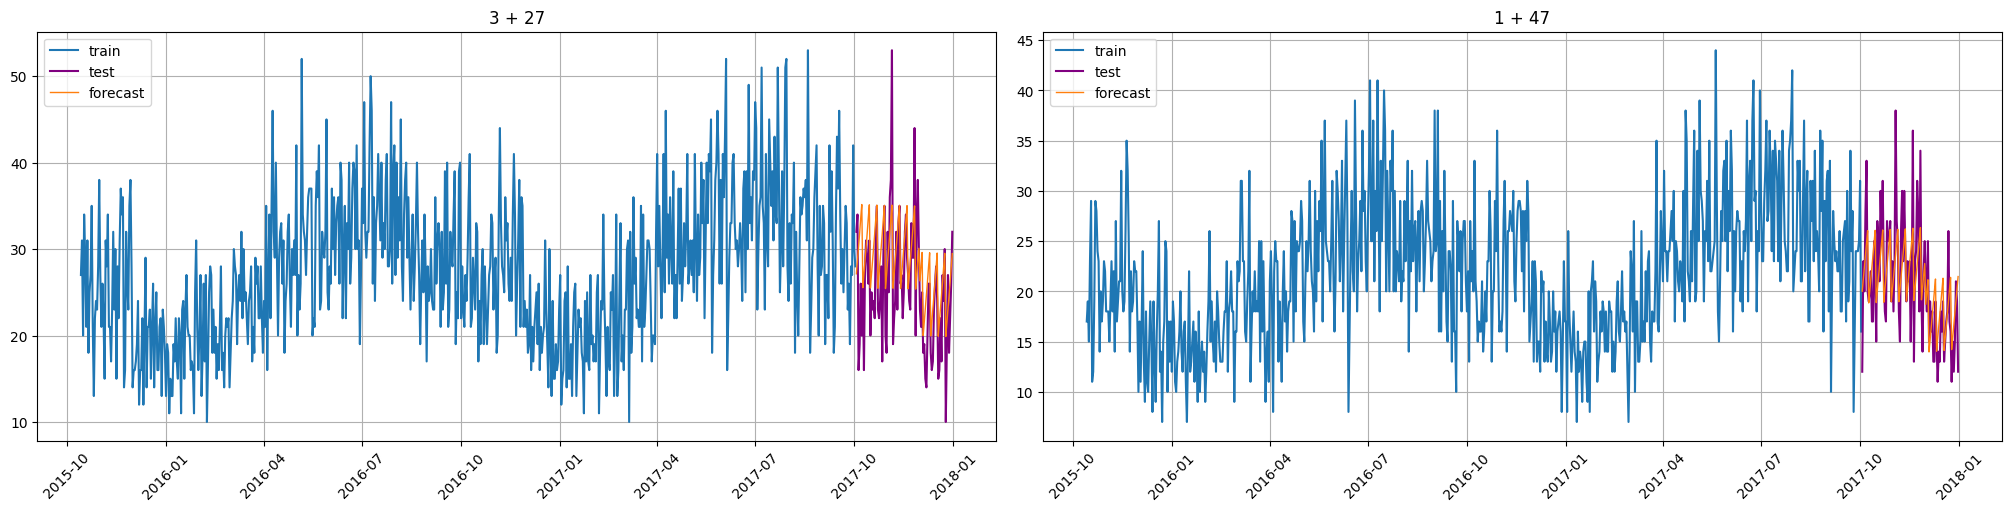

In [68]:
sarimax = train_and_evaluate_model(
    ts=ts_no_exog,
    model = SARIMAXModel(order=(1, 0, 1), # (p, d, q)
                      seasonal_order=(0, 0, 0, 7)), # (P, D, Q, s),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True
    )# 18.07

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95287D+00    |proj g|=  8.33185D-02


 This problem is unconstrained.



At iterate    5    f=  2.95271D+00    |proj g|=  2.19568D-01

At iterate   10    f=  2.94989D+00    |proj g|=  5.06935D-02

At iterate   15    f=  2.94973D+00    |proj g|=  1.05167D-01

At iterate   20    f=  2.94895D+00    |proj g|=  3.41685D-01

At iterate   25    f=  2.94443D+00    |proj g|=  4.42250D-02

At iterate   30    f=  2.93010D+00    |proj g|=  2.47741D-01

At iterate   35    f=  2.92187D+00    |proj g|=  2.80848D-02

At iterate   40    f=  2.92048D+00    |proj g|=  9.25476D-02

At iterate   45    f=  2.91922D+00    |proj g|=  6.33513D-02

At iterate   50    f=  2.91629D+00    |proj g|=  3.91134D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65028D+00    |proj g|=  6.14031D-02

At iterate    5    f=  3.64040D+00    |proj g|=  2.40834D-02

At iterate   10    f=  3.61691D+00    |proj g|=  6.48832D-02

At iterate   15    f=  3.61314D+00    |proj g|=  3.53385D-02

At iterate   20    f=  3.60667D+00    |proj g|=  2.08177D-02

At iterate   25    f=  3.60640D+00    |proj g|=  5.92113D-03

At iterate   30    f=  3.60607D+00    |proj g|=  6.03433D-02

At iterate   35    f=  3.60448D+00    |proj g|=  9.45585D-03

At iterate   40    f=  3.60420D+00    |proj g|=  1.43723D-02

At iterate   45    f=  3.60379D+00    |proj g|=  7.15401D-04

At iterate   50    f=  3.60375D+00    |proj g|=  2.82971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.57814D+00    |proj g|=  2.38298D-02

At iterate   10    f=  3.56474D+00    |proj g|=  3.64480D-02

At iterate   15    f=  3.55494D+00    |proj g|=  4.19716D-02

At iterate   20    f=  3.54956D+00    |proj g|=  4.33965D-03

At iterate   25    f=  3.54849D+00    |proj g|=  1.12457D-02

At iterate   30    f=  3.54784D+00    |proj g|=  8.52912D-03

At iterate   35    f=  3.54779D+00    |proj g|=  6.17331D-04

At iterate   40    f=  3.54774D+00    |proj g|=  2.02631D-02

At iterate   45    f=  3.54765D+00    |proj g|=  1.93724D-03

At iterate   50    f=  3.54764D+00    |proj g|=  6.19809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00612D+01    |proj g|=  1.37679D+01

At iterate    5    f=  3.75324D+00    |proj g|=  7.39980D-01

At iterate   10    f=  3.64710D+00    |proj g|=  5.82820D-02

At iterate   15    f=  3.58214D+00    |proj g|=  1.23171D-01

At iterate   20    f=  3.57713D+00    |proj g|=  6.53938D-02

At iterate   25    f=  3.57504D+00    |proj g|=  2.86538D-02

At iterate   30    f=  3.57373D+00    |proj g|=  1.55536D-01

At iterate   35    f=  3.57308D+00    |proj g|=  1.06130D-02

At iterate   40    f=  3.57292D+00    |proj g|=  1.31768D-02

At iterate   45    f=  3.57158D+00    |proj g|=  2.84851D-02

At iterate   50    f=  3.57138D+00    |proj g|=  9.71297D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.78251D+00    |proj g|=  8.03096D-01

At iterate   10    f=  3.76446D+00    |proj g|=  4.67400D-01

At iterate   15    f=  3.72422D+00    |proj g|=  5.66173D-01

At iterate   20    f=  3.68275D+00    |proj g|=  2.85455D-02

At iterate   25    f=  3.67206D+00    |proj g|=  9.03539D-02

At iterate   30    f=  3.66788D+00    |proj g|=  4.43315D-02

At iterate   35    f=  3.66757D+00    |proj g|=  3.19434D-03

At iterate   40    f=  3.66743D+00    |proj g|=  6.63713D-04

At iterate   45    f=  3.66735D+00    |proj g|=  4.75039D-03

At iterate   50    f=  3.66727D+00    |proj g|=  4.12926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52358D+00    |proj g|=  1.28411D-01

At iterate    5    f=  3.50229D+00    |proj g|=  1.26826D-01

At iterate   10    f=  3.49827D+00    |proj g|=  1.62676D-02

At iterate   15    f=  3.49535D+00    |proj g|=  4.18496D-03

At iterate   20    f=  3.49510D+00    |proj g|=  5.07565D-02

At iterate   25    f=  3.49019D+00    |proj g|=  1.37166D-01

At iterate   30    f=  3.48959D+00    |proj g|=  6.38826D-02

At iterate   35    f=  3.48711D+00    |proj g|=  5.37692D-02

At iterate   40    f=  3.48651D+00    |proj g|=  3.12476D-02

At iterate   45    f=  3.48564D+00    |proj g|=  2.34031D-02

At iterate   50    f=  3.48505D+00    |proj g|=  3.23783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.75067D+00    |proj g|=  1.68361D-02

At iterate   10    f=  3.73699D+00    |proj g|=  1.04799D-02

At iterate   15    f=  3.73414D+00    |proj g|=  4.89334D-02

At iterate   20    f=  3.73177D+00    |proj g|=  4.26098D-02

At iterate   25    f=  3.72784D+00    |proj g|=  5.49795D-03

At iterate   30    f=  3.72599D+00    |proj g|=  6.54230D-03

At iterate   35    f=  3.72495D+00    |proj g|=  3.01688D-02

At iterate   40    f=  3.72469D+00    |proj g|=  1.72065D-03

At iterate   45    f=  3.72453D+00    |proj g|=  3.60430D-02

At iterate   50    f=  3.72405D+00    |proj g|=  1.12086D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.05084D+00    |proj g|=  3.19982D-01

At iterate   10    f=  3.03911D+00    |proj g|=  2.02033D-02

At iterate   15    f=  3.03818D+00    |proj g|=  1.87561D-02

At iterate   20    f=  3.03815D+00    |proj g|=  2.98918D-02

At iterate   25    f=  3.03768D+00    |proj g|=  9.64874D-03

At iterate   30    f=  3.03672D+00    |proj g|=  2.25626D-02

At iterate   35    f=  3.03462D+00    |proj g|=  4.31370D-02

At iterate   40    f=  3.03383D+00    |proj g|=  5.07839D-03

At iterate   45    f=  3.03358D+00    |proj g|=  5.05423D-02

At iterate   50    f=  3.03195D+00    |proj g|=  1.78635D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.58504D+00    |proj g|=  4.93634D+00

At iterate   10    f=  3.19902D+00    |proj g|=  5.77522D-01

At iterate   15    f=  3.19754D+00    |proj g|=  4.20846D-02

At iterate   20    f=  3.18130D+00    |proj g|=  9.58585D-02

At iterate   25    f=  3.17277D+00    |proj g|=  6.96675D-02

At iterate   30    f=  3.15619D+00    |proj g|=  1.44590D-01

At iterate   35    f=  3.15247D+00    |proj g|=  6.66092D-02

At iterate   40    f=  3.15091D+00    |proj g|=  5.32744D-03

At iterate   45    f=  3.15058D+00    |proj g|=  3.46172D-02

At iterate   50    f=  3.15050D+00    |proj g|=  5.88084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.69915D+00    |proj g|=  3.88075D-02

At iterate   10    f=  3.69593D+00    |proj g|=  1.06806D-01

At iterate   15    f=  3.69538D+00    |proj g|=  1.99319D-02

At iterate   20    f=  3.69437D+00    |proj g|=  1.24109D-02

At iterate   25    f=  3.68940D+00    |proj g|=  1.05243D-02

At iterate   30    f=  3.68529D+00    |proj g|=  2.29055D-03

At iterate   35    f=  3.68502D+00    |proj g|=  3.45140D-02

At iterate   40    f=  3.68463D+00    |proj g|=  1.66452D-02

At iterate   45    f=  3.68438D+00    |proj g|=  1.14382D-02

At iterate   50    f=  3.68392D+00    |proj g|=  7.03644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.86050D+00    |proj g|=  1.77252D+01

At iterate   10    f=  3.36124D+00    |proj g|=  1.59700D+00

At iterate   15    f=  3.35436D+00    |proj g|=  1.18537D-01

At iterate   20    f=  3.32290D+00    |proj g|=  1.11404D+00

At iterate   25    f=  3.30774D+00    |proj g|=  3.12388D-02

At iterate   30    f=  3.30027D+00    |proj g|=  1.08034D-02

At iterate   35    f=  3.29730D+00    |proj g|=  1.71098D-02

At iterate   40    f=  3.29520D+00    |proj g|=  1.11598D-02

At iterate   45    f=  3.29500D+00    |proj g|=  1.95652D-03

At iterate   50    f=  3.29459D+00    |proj g|=  3.73677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.50884D+00    |proj g|=  2.48153D-01

At iterate   10    f=  3.49980D+00    |proj g|=  3.70677D-02

At iterate   15    f=  3.49768D+00    |proj g|=  4.66944D-03

At iterate   20    f=  3.49733D+00    |proj g|=  8.08812D-02

At iterate   25    f=  3.49350D+00    |proj g|=  2.28503D-01

At iterate   30    f=  3.49172D+00    |proj g|=  5.43143D-02

At iterate   35    f=  3.49005D+00    |proj g|=  3.13231D-03

At iterate   40    f=  3.48953D+00    |proj g|=  4.50428D-02

At iterate   45    f=  3.48798D+00    |proj g|=  1.80939D-02

At iterate   50    f=  3.48779D+00    |proj g|=  4.28536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.99303D+00    |proj g|=  2.37562D+01

At iterate   10    f=  3.40468D+00    |proj g|=  1.43742D+00

At iterate   15    f=  3.37988D+00    |proj g|=  3.63796D-02

At iterate   20    f=  3.36596D+00    |proj g|=  2.41982D-01

At iterate   25    f=  3.34898D+00    |proj g|=  3.02437D-02

At iterate   30    f=  3.34581D+00    |proj g|=  7.53844D-02

At iterate   35    f=  3.33594D+00    |proj g|=  3.04744D-02

At iterate   40    f=  3.33379D+00    |proj g|=  1.76599D-02

At iterate   45    f=  3.33278D+00    |proj g|=  9.92332D-03

At iterate   50    f=  3.33275D+00    |proj g|=  5.49935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30785D+00    |proj g|=  7.26029D-02

At iterate    5    f=  3.30287D+00    |proj g|=  1.38191D-02

At iterate   10    f=  3.29572D+00    |proj g|=  1.34127D-01

At iterate   15    f=  3.28001D+00    |proj g|=  2.87800D-02

At iterate   20    f=  3.27563D+00    |proj g|=  6.96747D-03

At iterate   25    f=  3.27500D+00    |proj g|=  5.21459D-02

At iterate   30    f=  3.27439D+00    |proj g|=  3.78472D-03

At iterate   35    f=  3.27357D+00    |proj g|=  5.68367D-02

At iterate   40    f=  3.27330D+00    |proj g|=  9.50916D-03

At iterate   45    f=  3.27326D+00    |proj g|=  6.31081D-03

At iterate   50    f=  3.27323D+00    |proj g|=  1.73411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.70525D+00    |proj g|=  1.02890D-02

At iterate   10    f=  3.70350D+00    |proj g|=  1.10337D-01

At iterate   15    f=  3.69662D+00    |proj g|=  3.03991D-02

At iterate   20    f=  3.69310D+00    |proj g|=  3.17890D-02

At iterate   25    f=  3.68399D+00    |proj g|=  1.89443D-02

At iterate   30    f=  3.68324D+00    |proj g|=  5.92117D-03

At iterate   35    f=  3.68289D+00    |proj g|=  3.16860D-03

At iterate   40    f=  3.68255D+00    |proj g|=  1.61625D-02

At iterate   45    f=  3.68222D+00    |proj g|=  1.57096D-02

At iterate   50    f=  3.68212D+00    |proj g|=  7.46476D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.26127D+00    |proj g|=  3.30439D+01

At iterate   10    f=  3.18128D+00    |proj g|=  2.02172D+00

At iterate   15    f=  3.16437D+00    |proj g|=  7.02306D-02

At iterate   20    f=  3.15857D+00    |proj g|=  5.33793D-02

At iterate   25    f=  3.15438D+00    |proj g|=  7.58222D-02

At iterate   30    f=  3.15288D+00    |proj g|=  9.45722D-02

At iterate   35    f=  3.13860D+00    |proj g|=  2.55866D-01

At iterate   40    f=  3.13045D+00    |proj g|=  2.89092D-01

At iterate   45    f=  3.12859D+00    |proj g|=  6.28854D-02

At iterate   50    f=  3.12842D+00    |proj g|=  2.22253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.64238D+00    |proj g|=  1.31436D-01

At iterate   10    f=  3.64061D+00    |proj g|=  2.67568D-01

At iterate   15    f=  3.61112D+00    |proj g|=  1.05955D+00

At iterate   20    f=  3.57804D+00    |proj g|=  4.46779D-02

At iterate   25    f=  3.57305D+00    |proj g|=  1.56909D-01

At iterate   30    f=  3.56459D+00    |proj g|=  1.95206D-01

At iterate   35    f=  3.55871D+00    |proj g|=  7.05250D-02

At iterate   40    f=  3.55762D+00    |proj g|=  2.24466D-03

At iterate   45    f=  3.55663D+00    |proj g|=  1.57132D-02

At iterate   50    f=  3.55644D+00    |proj g|=  5.59466D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.73326D+00    |proj g|=  1.26098D-01

At iterate   10    f=  3.70768D+00    |proj g|=  1.03671D-01

At iterate   15    f=  3.64825D+00    |proj g|=  7.28702D-02

At iterate   20    f=  3.64046D+00    |proj g|=  6.72703D-02

At iterate   25    f=  3.62461D+00    |proj g|=  8.13864D-02

At iterate   30    f=  3.62351D+00    |proj g|=  1.88330D-02

At iterate   35    f=  3.62275D+00    |proj g|=  2.24850D-03

At iterate   40    f=  3.62239D+00    |proj g|=  1.96581D-02

At iterate   45    f=  3.62138D+00    |proj g|=  2.17910D-02

At iterate   50    f=  3.62131D+00    |proj g|=  1.12337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39041D+00    |proj g|=  2.03641D-01

At iterate    5    f=  3.38097D+00    |proj g|=  3.50657D-01

At iterate   10    f=  3.37054D+00    |proj g|=  1.03445D-02

At iterate   15    f=  3.36934D+00    |proj g|=  7.67024D-02

At iterate   20    f=  3.36860D+00    |proj g|=  3.18900D-03

At iterate   25    f=  3.36842D+00    |proj g|=  6.35291D-02

At iterate   30    f=  3.36681D+00    |proj g|=  1.32872D-02

At iterate   35    f=  3.36568D+00    |proj g|=  5.20510D-02

At iterate   40    f=  3.36232D+00    |proj g|=  6.30593D-03

At iterate   45    f=  3.36230D+00    |proj g|=  4.21214D-03

At iterate   50    f=  3.36222D+00    |proj g|=  2.36511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  2.96652D+00    |proj g|=  3.72357D-01

At iterate   10    f=  2.95476D+00    |proj g|=  1.35393D-01

At iterate   15    f=  2.95192D+00    |proj g|=  1.90768D-01

At iterate   20    f=  2.95127D+00    |proj g|=  1.02379D-01

At iterate   25    f=  2.94903D+00    |proj g|=  5.36858D-03

At iterate   30    f=  2.94899D+00    |proj g|=  1.79577D-03

At iterate   35    f=  2.94891D+00    |proj g|=  8.31767D-03

At iterate   40    f=  2.94874D+00    |proj g|=  5.55324D-02

At iterate   45    f=  2.94814D+00    |proj g|=  1.13278D-01

At iterate   50    f=  2.94746D+00    |proj g|=  1.26179D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.72977D+00    |proj g|=  1.29472D-02

At iterate   10    f=  3.71866D+00    |proj g|=  2.40040D-02

At iterate   15    f=  3.71010D+00    |proj g|=  5.20410D-02

At iterate   20    f=  3.70162D+00    |proj g|=  5.41080D-02

At iterate   25    f=  3.70032D+00    |proj g|=  5.83560D-03

At iterate   30    f=  3.69997D+00    |proj g|=  2.37886D-02

At iterate   35    f=  3.69970D+00    |proj g|=  4.94405D-03

At iterate   40    f=  3.69910D+00    |proj g|=  1.97772D-02

At iterate   45    f=  3.69900D+00    |proj g|=  1.90369D-03

At iterate   50    f=  3.69900D+00    |proj g|=  6.20761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56044D+00    |proj g|=  8.64120D-02

At iterate    5    f=  3.53161D+00    |proj g|=  1.06744D-01

At iterate   10    f=  3.52574D+00    |proj g|=  1.08816D-02

At iterate   15    f=  3.52466D+00    |proj g|=  5.85376D-02

At iterate   20    f=  3.52462D+00    |proj g|=  9.45490D-04

At iterate   25    f=  3.52450D+00    |proj g|=  2.26900D-02

At iterate   30    f=  3.52435D+00    |proj g|=  8.24772D-03

At iterate   35    f=  3.52422D+00    |proj g|=  3.48340D-03

At iterate   40    f=  3.52407D+00    |proj g|=  8.95337D-03

At iterate   45    f=  3.52383D+00    |proj g|=  5.14719D-03

At iterate   50    f=  3.52376D+00    |proj g|=  7.92125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.25621D+00    |proj g|=  5.04954D-02

At iterate   10    f=  3.25040D+00    |proj g|=  1.27286D-01

At iterate   15    f=  3.24825D+00    |proj g|=  1.06452D-01

At iterate   20    f=  3.24095D+00    |proj g|=  2.60652D-01

At iterate   25    f=  3.23442D+00    |proj g|=  2.31481D-01

At iterate   30    f=  3.23350D+00    |proj g|=  3.36755D-02

At iterate   35    f=  3.23305D+00    |proj g|=  1.12671D-02

At iterate   40    f=  3.23273D+00    |proj g|=  5.10602D-02

At iterate   45    f=  3.23231D+00    |proj g|=  4.20112D-02

At iterate   50    f=  3.22914D+00    |proj g|=  1.06735D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30448D+00    |proj g|=  1.27235D-01

At iterate    5    f=  3.28518D+00    |proj g|=  9.21683D-02

At iterate   10    f=  3.28156D+00    |proj g|=  2.68863D-02

At iterate   15    f=  3.28049D+00    |proj g|=  2.28814D-02

At iterate   20    f=  3.27941D+00    |proj g|=  4.52005D-03

At iterate   25    f=  3.27724D+00    |proj g|=  3.74936D-02

At iterate   30    f=  3.27190D+00    |proj g|=  2.64229D-02

At iterate   35    f=  3.27147D+00    |proj g|=  1.04734D-02

At iterate   40    f=  3.27004D+00    |proj g|=  9.79572D-03

At iterate   45    f=  3.26995D+00    |proj g|=  2.73499D-03

At iterate   50    f=  3.26990D+00    |proj g|=  1.84446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.50081D+00    |proj g|=  1.70592D-02

At iterate   10    f=  3.48603D+00    |proj g|=  4.71523D-02

At iterate   15    f=  3.47917D+00    |proj g|=  2.21146D-02

At iterate   20    f=  3.47133D+00    |proj g|=  1.65687D-02

At iterate   25    f=  3.46756D+00    |proj g|=  8.53017D-03

At iterate   30    f=  3.46697D+00    |proj g|=  5.97829D-02

At iterate   35    f=  3.46604D+00    |proj g|=  1.34753D-01

At iterate   40    f=  3.46567D+00    |proj g|=  9.60143D-03

At iterate   45    f=  3.46565D+00    |proj g|=  5.70391D-03

At iterate   50    f=  3.46563D+00    |proj g|=  2.05772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.33964D+00    |proj g|=  1.74470D-01

At iterate   10    f=  3.33166D+00    |proj g|=  4.10036D-02

At iterate   15    f=  3.33061D+00    |proj g|=  4.11099D-02

At iterate   20    f=  3.32962D+00    |proj g|=  4.08369D-03

At iterate   25    f=  3.32838D+00    |proj g|=  2.34444D-02

At iterate   30    f=  3.32336D+00    |proj g|=  2.60941D-02

At iterate   35    f=  3.32324D+00    |proj g|=  4.00320D-03

At iterate   40    f=  3.32270D+00    |proj g|=  4.62906D-02

At iterate   45    f=  3.32209D+00    |proj g|=  3.59122D-02

At iterate   50    f=  3.32093D+00    |proj g|=  7.11602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60100D+00    |proj g|=  1.30478D-01

At iterate    5    f=  3.57942D+00    |proj g|=  2.79934D-01

At iterate   10    f=  3.57523D+00    |proj g|=  1.17550D-02

At iterate   15    f=  3.57334D+00    |proj g|=  3.04913D-03

At iterate   20    f=  3.57087D+00    |proj g|=  9.84538D-03

At iterate   25    f=  3.56908D+00    |proj g|=  5.88901D-02

At iterate   30    f=  3.56843D+00    |proj g|=  6.35548D-02

At iterate   35    f=  3.56768D+00    |proj g|=  2.30668D-03

At iterate   40    f=  3.56745D+00    |proj g|=  3.60671D-03

At iterate   45    f=  3.56711D+00    |proj g|=  3.70714D-02

At iterate   50    f=  3.56575D+00    |proj g|=  1.25201D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.03796D+00    |proj g|=  2.08264D-01

At iterate   10    f=  3.03642D+00    |proj g|=  2.83200D-01

At iterate   15    f=  3.03461D+00    |proj g|=  3.15452D-02

At iterate   20    f=  3.03444D+00    |proj g|=  2.88914D-02

At iterate   25    f=  3.03357D+00    |proj g|=  2.04261D-01

At iterate   30    f=  3.03255D+00    |proj g|=  1.23950D-02

At iterate   35    f=  3.03118D+00    |proj g|=  5.21963D-02

At iterate   40    f=  3.02159D+00    |proj g|=  4.25817D-02

At iterate   45    f=  3.01874D+00    |proj g|=  5.67118D-02

At iterate   50    f=  3.01821D+00    |proj g|=  3.40975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.55820D+00    |proj g|=  3.32937D-02

At iterate   10    f=  3.54972D+00    |proj g|=  4.24184D-02

At iterate   15    f=  3.54501D+00    |proj g|=  8.92161D-02

At iterate   20    f=  3.53298D+00    |proj g|=  1.59959D-02

At iterate   25    f=  3.53262D+00    |proj g|=  3.17849D-03

At iterate   30    f=  3.53258D+00    |proj g|=  7.72737D-03

At iterate   35    f=  3.53255D+00    |proj g|=  2.52444D-03

At iterate   40    f=  3.53247D+00    |proj g|=  3.81556D-03

At iterate   45    f=  3.53225D+00    |proj g|=  2.04271D-03

At iterate   50    f=  3.53224D+00    |proj g|=  1.46302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.71444D+00    |proj g|=  7.17584D-02

At iterate   10    f=  3.63624D+00    |proj g|=  2.65058D-01

At iterate   15    f=  3.61959D+00    |proj g|=  3.94396D-02

At iterate   20    f=  3.60906D+00    |proj g|=  9.76598D-02

At iterate   25    f=  3.60699D+00    |proj g|=  8.42011D-03

At iterate   30    f=  3.60493D+00    |proj g|=  2.12201D-02

At iterate   35    f=  3.60429D+00    |proj g|=  1.67267D-02

At iterate   40    f=  3.60421D+00    |proj g|=  1.24048D-03

At iterate   45    f=  3.60419D+00    |proj g|=  7.14595D-03

At iterate   50    f=  3.60417D+00    |proj g|=  1.26555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.12554D+00    |proj g|=  2.10632D-01

At iterate   10    f=  3.11741D+00    |proj g|=  1.23264D-02

At iterate   15    f=  3.11738D+00    |proj g|=  1.32808D-02

At iterate   20    f=  3.11556D+00    |proj g|=  6.25863D-02

At iterate   25    f=  3.11310D+00    |proj g|=  9.27031D-03

At iterate   30    f=  3.11159D+00    |proj g|=  2.71625D-02

At iterate   35    f=  3.11101D+00    |proj g|=  4.43819D-02

At iterate   40    f=  3.11014D+00    |proj g|=  2.48604D-02

At iterate   45    f=  3.10882D+00    |proj g|=  4.02014D-02

At iterate   50    f=  3.10787D+00    |proj g|=  9.44997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69805D+00    |proj g|=  1.02761D-01

At iterate    5    f=  3.69162D+00    |proj g|=  2.31548D-01

At iterate   10    f=  3.68573D+00    |proj g|=  1.89537D-02

At iterate   15    f=  3.67732D+00    |proj g|=  2.01643D-02

At iterate   20    f=  3.67315D+00    |proj g|=  6.12827D-02

At iterate   25    f=  3.66523D+00    |proj g|=  3.09654D-03

At iterate   30    f=  3.66476D+00    |proj g|=  8.85163D-03

At iterate   35    f=  3.66427D+00    |proj g|=  7.76279D-03

At iterate   40    f=  3.66415D+00    |proj g|=  1.73295D-03

At iterate   45    f=  3.66409D+00    |proj g|=  1.01152D-02

At iterate   50    f=  3.66407D+00    |proj g|=  3.27544D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.33142D+00    |proj g|=  2.73127D-01

At iterate   10    f=  3.32082D+00    |proj g|=  7.57880D-03

At iterate   15    f=  3.31994D+00    |proj g|=  1.81884D-02

At iterate   20    f=  3.31991D+00    |proj g|=  1.64040D-02

At iterate   25    f=  3.31934D+00    |proj g|=  3.45053D-02

At iterate   30    f=  3.31716D+00    |proj g|=  3.38228D-02

At iterate   35    f=  3.31663D+00    |proj g|=  2.66744D-03

At iterate   40    f=  3.31628D+00    |proj g|=  3.60514D-02

At iterate   45    f=  3.31513D+00    |proj g|=  2.85023D-02

At iterate   50    f=  3.31457D+00    |proj g|=  3.92193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.97223D+00    |proj g|=  1.71640D-01

At iterate   10    f=  2.97059D+00    |proj g|=  1.76863D-01

At iterate   15    f=  2.96952D+00    |proj g|=  9.09819D-03

At iterate   20    f=  2.96921D+00    |proj g|=  1.61813D-01

At iterate   25    f=  2.96777D+00    |proj g|=  6.04010D-02

At iterate   30    f=  2.96305D+00    |proj g|=  6.38134D-02

At iterate   35    f=  2.95665D+00    |proj g|=  6.94479D-02

At iterate   40    f=  2.95351D+00    |proj g|=  1.38400D-01

At iterate   45    f=  2.95194D+00    |proj g|=  5.86942D-02

At iterate   50    f=  2.95130D+00    |proj g|=  9.05668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09716D+00    |proj g|=  5.05842D-02

At iterate    5    f=  3.09095D+00    |proj g|=  1.84413D-01

At iterate   10    f=  3.09080D+00    |proj g|=  6.00885D-02

At iterate   15    f=  3.08865D+00    |proj g|=  1.79395D-01

At iterate   20    f=  3.08806D+00    |proj g|=  1.37403D-02

At iterate   25    f=  3.08676D+00    |proj g|=  4.37543D-01

At iterate   30    f=  3.07617D+00    |proj g|=  3.63787D-01

At iterate   35    f=  3.07327D+00    |proj g|=  7.97583D-02

At iterate   40    f=  3.06954D+00    |proj g|=  9.06782D-02

At iterate   45    f=  3.06741D+00    |proj g|=  2.03105D-02

At iterate   50    f=  3.06678D+00    |proj g|=  3.10530D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01777D+00    |proj g|=  1.40925D-01

At iterate    5    f=  3.00928D+00    |proj g|=  7.62431D-03

At iterate   10    f=  3.00917D+00    |proj g|=  1.39357D-01

At iterate   15    f=  3.00660D+00    |proj g|=  4.75767D-01

At iterate   20    f=  3.00627D+00    |proj g|=  1.09412D-01

At iterate   25    f=  3.00594D+00    |proj g|=  5.09447D-01

At iterate   30    f=  2.98945D+00    |proj g|=  1.50792D+00

At iterate   35    f=  2.97257D+00    |proj g|=  1.04042D-01

At iterate   40    f=  2.94591D+00    |proj g|=  5.33334D-01

At iterate   45    f=  2.94077D+00    |proj g|=  5.63891D-02

At iterate   50    f=  2.94046D+00    |proj g|=  1.10509D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.19128D+00    |proj g|=  1.09070D-01

At iterate   10    f=  3.19020D+00    |proj g|=  5.22950D-02

At iterate   15    f=  3.18582D+00    |proj g|=  1.15079D-02

At iterate   20    f=  3.17748D+00    |proj g|=  9.58982D-02

At iterate   25    f=  3.17025D+00    |proj g|=  4.71972D-02

At iterate   30    f=  3.17013D+00    |proj g|=  4.49041D-03

At iterate   35    f=  3.16988D+00    |proj g|=  2.28255D-02

At iterate   40    f=  3.16931D+00    |proj g|=  1.22795D-02

At iterate   45    f=  3.16930D+00    |proj g|=  3.85689D-03

At iterate   50    f=  3.16928D+00    |proj g|=  3.20933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41733D+00    |proj g|=  1.07271D-01

At iterate    5    f=  3.41410D+00    |proj g|=  2.74859D-01

At iterate   10    f=  3.40659D+00    |proj g|=  8.32258D-03

At iterate   15    f=  3.40394D+00    |proj g|=  8.63067D-02

At iterate   20    f=  3.40221D+00    |proj g|=  5.17519D-02

At iterate   25    f=  3.39452D+00    |proj g|=  3.76117D-02

At iterate   30    f=  3.38943D+00    |proj g|=  1.38685D-02

At iterate   35    f=  3.38847D+00    |proj g|=  4.76973D-03

At iterate   40    f=  3.38820D+00    |proj g|=  2.56491D-02

At iterate   45    f=  3.38789D+00    |proj g|=  2.31933D-02

At iterate   50    f=  3.38707D+00    |proj g|=  5.26435D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.55486D+00    |proj g|=  4.31795D+00

At iterate   10    f=  3.35911D+00    |proj g|=  8.75518D-01

At iterate   15    f=  3.15509D+00    |proj g|=  1.70869D-01

At iterate   20    f=  3.13611D+00    |proj g|=  3.70500D-02

At iterate   25    f=  3.12485D+00    |proj g|=  1.35229D-01

At iterate   30    f=  3.11330D+00    |proj g|=  3.40303D-02

At iterate   35    f=  3.10523D+00    |proj g|=  2.95286D-02

At iterate   40    f=  3.09831D+00    |proj g|=  9.95503D-02

At iterate   45    f=  3.09716D+00    |proj g|=  1.23386D-02

At iterate   50    f=  3.09600D+00    |proj g|=  1.21368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.66119D+00    |proj g|=  1.42410D-02

At iterate   10    f=  3.65854D+00    |proj g|=  3.01873D-02

At iterate   15    f=  3.65636D+00    |proj g|=  1.50504D-02

At iterate   20    f=  3.64779D+00    |proj g|=  3.59991D-02

At iterate   25    f=  3.64326D+00    |proj g|=  3.90350D-02

At iterate   30    f=  3.64297D+00    |proj g|=  2.66478D-02

At iterate   35    f=  3.64275D+00    |proj g|=  1.86591D-02

At iterate   40    f=  3.64265D+00    |proj g|=  3.07144D-03

At iterate   45    f=  3.64251D+00    |proj g|=  5.56993D-03

At iterate   50    f=  3.64232D+00    |proj g|=  1.06493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.49632D+00    |proj g|=  3.10659D-01

At iterate   10    f=  3.48629D+00    |proj g|=  4.23968D-02

At iterate   15    f=  3.48564D+00    |proj g|=  3.68277D-02

At iterate   20    f=  3.48388D+00    |proj g|=  1.61947D-02

At iterate   25    f=  3.48335D+00    |proj g|=  4.19626D-02

At iterate   30    f=  3.48092D+00    |proj g|=  1.51246D-02

At iterate   35    f=  3.47888D+00    |proj g|=  2.26467D-01

At iterate   40    f=  3.47555D+00    |proj g|=  5.50663D-02

At iterate   45    f=  3.47481D+00    |proj g|=  2.74428D-03

At iterate   50    f=  3.47473D+00    |proj g|=  3.38432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.93327D+00    |proj g|=  3.19416D-01

At iterate   10    f=  2.92639D+00    |proj g|=  4.19993D-01

At iterate   15    f=  2.92182D+00    |proj g|=  4.36559D-03

At iterate   20    f=  2.92157D+00    |proj g|=  5.92016D-02

At iterate   25    f=  2.91986D+00    |proj g|=  1.77613D-01

At iterate   30    f=  2.91918D+00    |proj g|=  7.59095D-02

At iterate   35    f=  2.91658D+00    |proj g|=  4.40615D-02

At iterate   40    f=  2.91613D+00    |proj g|=  1.35352D-02

At iterate   45    f=  2.91565D+00    |proj g|=  9.41257D-02

At iterate   50    f=  2.91492D+00    |proj g|=  1.08947D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.42599D+00    |proj g|=  3.28161D-01

At iterate   10    f=  3.40698D+00    |proj g|=  6.97030D-02

At iterate   15    f=  3.40650D+00    |proj g|=  1.55158D-02

At iterate   20    f=  3.40644D+00    |proj g|=  1.14485D-03

At iterate   25    f=  3.40635D+00    |proj g|=  2.67316D-02

At iterate   30    f=  3.40620D+00    |proj g|=  2.59550D-02

At iterate   35    f=  3.40613D+00    |proj g|=  6.77003D-04

At iterate   40    f=  3.40613D+00    |proj g|=  7.39224D-03

At iterate   45    f=  3.40612D+00    |proj g|=  4.54118D-03

At iterate   50    f=  3.40607D+00    |proj g|=  1.04418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.59200D+00    |proj g|=  3.71985D+00

At iterate   10    f=  3.13016D+00    |proj g|=  3.48449D-01

At iterate   15    f=  3.11579D+00    |proj g|=  4.31300D-02

At iterate   20    f=  3.10536D+00    |proj g|=  1.67136D-01

At iterate   25    f=  3.10075D+00    |proj g|=  1.12071D-01

At iterate   30    f=  3.09327D+00    |proj g|=  1.15795D-01

At iterate   35    f=  3.08660D+00    |proj g|=  6.67352D-02

At iterate   40    f=  3.08633D+00    |proj g|=  5.51313D-03

At iterate   45    f=  3.08567D+00    |proj g|=  1.13010D-02

At iterate   50    f=  3.08557D+00    |proj g|=  4.55027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76142D+01    |proj g|=  2.99920D+01

At iterate    5    f=  3.72660D+00    |proj g|=  2.99442D+01

At iterate   10    f=  2.87649D+00    |proj g|=  1.68592D+00

At iterate   15    f=  2.86406D+00    |proj g|=  7.41497D-02

At iterate   20    f=  2.85675D+00    |proj g|=  2.31691D-01

At iterate   25    f=  2.85231D+00    |proj g|=  2.46729D-01

At iterate   30    f=  2.83538D+00    |proj g|=  7.38425D-02

At iterate   35    f=  2.83522D+00    |proj g|=  1.34030D-02

At iterate   40    f=  2.83236D+00    |proj g|=  1.64998D-01

At iterate   45    f=  2.83126D+00    |proj g|=  2.30470D-02

At iterate   50    f=  2.83097D+00    |proj g|=  7.91447D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57128D+00    |proj g|=  1.32838D-01

At iterate    5    f=  3.55117D+00    |proj g|=  6.72503D-02

At iterate   10    f=  3.54759D+00    |proj g|=  9.62244D-03

At iterate   15    f=  3.54519D+00    |proj g|=  4.46420D-03

At iterate   20    f=  3.54383D+00    |proj g|=  1.04608D-01

At iterate   25    f=  3.54019D+00    |proj g|=  5.39810D-02

At iterate   30    f=  3.53873D+00    |proj g|=  1.29570D-02

At iterate   35    f=  3.53769D+00    |proj g|=  3.42215D-03

At iterate   40    f=  3.53740D+00    |proj g|=  7.42718D-03

At iterate   45    f=  3.53627D+00    |proj g|=  8.29288D-03

At iterate   50    f=  3.53611D+00    |proj g|=  2.64887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05996D+01    |proj g|=  1.46563D+01

At iterate    5    f=  3.55545D+00    |proj g|=  2.02066D-01

At iterate   10    f=  3.55269D+00    |proj g|=  5.14773D-02

At iterate   15    f=  3.54294D+00    |proj g|=  1.26036D+00

At iterate   20    f=  3.49937D+00    |proj g|=  6.38343D-01

At iterate   25    f=  3.48574D+00    |proj g|=  1.92500D-02

At iterate   30    f=  3.47495D+00    |proj g|=  2.74120D-01

At iterate   35    f=  3.46860D+00    |proj g|=  2.27977D-02

At iterate   40    f=  3.46568D+00    |proj g|=  9.73682D-03

At iterate   45    f=  3.46567D+00    |proj g|=  3.69568D-03

At iterate   50    f=  3.46551D+00    |proj g|=  3.13084D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50894D+00    |proj g|=  7.47033D-02

At iterate    5    f=  3.50768D+00    |proj g|=  2.26227D-01

At iterate   10    f=  3.50423D+00    |proj g|=  4.40780D-02

At iterate   15    f=  3.50181D+00    |proj g|=  2.03229D-01

At iterate   20    f=  3.49253D+00    |proj g|=  1.59664D-02

At iterate   25    f=  3.47808D+00    |proj g|=  4.78142D-02

At iterate   30    f=  3.47398D+00    |proj g|=  1.73141D-01

At iterate   35    f=  3.47220D+00    |proj g|=  6.26815D-03

At iterate   40    f=  3.47190D+00    |proj g|=  2.55511D-02

At iterate   45    f=  3.47177D+00    |proj g|=  8.81478D-03

At iterate   50    f=  3.47140D+00    |proj g|=  9.76883D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.62954D+00    |proj g|=  1.22465D-02

At iterate   10    f=  3.62792D+00    |proj g|=  3.18907D-02

At iterate   15    f=  3.62464D+00    |proj g|=  6.08172D-02

At iterate   20    f=  3.61890D+00    |proj g|=  1.23647D-01

At iterate   25    f=  3.61714D+00    |proj g|=  1.30241D-01

At iterate   30    f=  3.61474D+00    |proj g|=  8.30720D-03

At iterate   35    f=  3.61446D+00    |proj g|=  1.03884D-02

At iterate   40    f=  3.61271D+00    |proj g|=  1.22479D-02

At iterate   45    f=  3.61264D+00    |proj g|=  6.83666D-03

At iterate   50    f=  3.61264D+00    |proj g|=  3.40669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41388D+00    |proj g|=  5.83620D-02

At iterate    5    f=  3.39361D+00    |proj g|=  1.47717D-01

At iterate   10    f=  3.39309D+00    |proj g|=  5.45941D-02

At iterate   15    f=  3.39116D+00    |proj g|=  6.60932D-03

At iterate   20    f=  3.39080D+00    |proj g|=  6.10822D-02

At iterate   25    f=  3.38163D+00    |proj g|=  5.14197D-02

At iterate   30    f=  3.37918D+00    |proj g|=  1.39136D-01

At iterate   35    f=  3.37853D+00    |proj g|=  1.90768D-02

At iterate   40    f=  3.37806D+00    |proj g|=  3.82185D-02

At iterate   45    f=  3.37669D+00    |proj g|=  6.99604D-02

At iterate   50    f=  3.37617D+00    |proj g|=  1.25519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.15517D+00    |proj g|=  1.04793D+00

At iterate   10    f=  3.15337D+00    |proj g|=  2.16728D-02

At iterate   15    f=  3.15249D+00    |proj g|=  5.96111D-01

At iterate   20    f=  3.12787D+00    |proj g|=  9.06191D-01

At iterate   25    f=  3.11924D+00    |proj g|=  2.67489D-02

At iterate   30    f=  3.11344D+00    |proj g|=  1.69476D-01

At iterate   35    f=  3.10504D+00    |proj g|=  7.27718D-02

At iterate   40    f=  3.10067D+00    |proj g|=  3.40611D-02

At iterate   45    f=  3.09836D+00    |proj g|=  1.01849D-01

At iterate   50    f=  3.09312D+00    |proj g|=  3.04701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82661D+00    |proj g|=  7.74061D-02

At iterate    5    f=  3.80083D+00    |proj g|=  2.71872D-02

At iterate   10    f=  3.79800D+00    |proj g|=  1.69814D-02

At iterate   15    f=  3.79640D+00    |proj g|=  2.04094D-03

At iterate   20    f=  3.79621D+00    |proj g|=  1.48992D-03

At iterate   25    f=  3.79617D+00    |proj g|=  9.46137D-03

At iterate   30    f=  3.79615D+00    |proj g|=  3.64602D-03

At iterate   35    f=  3.79600D+00    |proj g|=  3.26765D-03

At iterate   40    f=  3.79591D+00    |proj g|=  7.32970D-04

At iterate   45    f=  3.79589D+00    |proj g|=  9.55598D-04

At iterate   50    f=  3.79585D+00    |proj g|=  2.17171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.77357D+00    |proj g|=  1.79959D-01

At iterate   10    f=  3.76757D+00    |proj g|=  6.46497D-02

At iterate   15    f=  3.76141D+00    |proj g|=  7.80269D-03

At iterate   20    f=  3.75594D+00    |proj g|=  1.17223D-02

At iterate   25    f=  3.75254D+00    |proj g|=  1.32634D-02

At iterate   30    f=  3.75105D+00    |proj g|=  5.80421D-03

At iterate   35    f=  3.75030D+00    |proj g|=  2.10989D-03

At iterate   40    f=  3.75026D+00    |proj g|=  2.63810D-03

At iterate   45    f=  3.74997D+00    |proj g|=  2.51892D-02

At iterate   50    f=  3.74984D+00    |proj g|=  1.02338D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.79160D+00    |proj g|=  8.79550D-03

At iterate   10    f=  3.78733D+00    |proj g|=  1.76009D-02

At iterate   15    f=  3.78663D+00    |proj g|=  1.00437D-01

At iterate   20    f=  3.78396D+00    |proj g|=  1.72836D-02

At iterate   25    f=  3.78012D+00    |proj g|=  6.19129D-02

At iterate   30    f=  3.77780D+00    |proj g|=  1.29504D-02

At iterate   35    f=  3.77752D+00    |proj g|=  3.95412D-02

At iterate   40    f=  3.77715D+00    |proj g|=  2.11240D-02

At iterate   45    f=  3.77637D+00    |proj g|=  2.59962D-03

At iterate   50    f=  3.77624D+00    |proj g|=  1.60712D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.88914D+00    |proj g|=  9.02745D-03

At iterate   10    f=  3.87988D+00    |proj g|=  2.90006D-02

At iterate   15    f=  3.87500D+00    |proj g|=  3.48069D-02

At iterate   20    f=  3.87205D+00    |proj g|=  1.43289D-02

At iterate   25    f=  3.86958D+00    |proj g|=  5.79660D-03

At iterate   30    f=  3.86877D+00    |proj g|=  1.23842D-03

At iterate   35    f=  3.86870D+00    |proj g|=  2.99954D-03

At iterate   40    f=  3.86847D+00    |proj g|=  3.97928D-03

At iterate   45    f=  3.86837D+00    |proj g|=  1.93465D-03

At iterate   50    f=  3.86835D+00    |proj g|=  2.48987D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69788D+00    |proj g|=  7.17099D-02

At iterate    5    f=  3.68465D+00    |proj g|=  1.10235D-02

At iterate   10    f=  3.67678D+00    |proj g|=  5.27529D-02

At iterate   15    f=  3.67413D+00    |proj g|=  1.46953D-01

At iterate   20    f=  3.67284D+00    |proj g|=  7.93594D-02

At iterate   25    f=  3.66808D+00    |proj g|=  7.55225D-02

At iterate   30    f=  3.66308D+00    |proj g|=  4.65691D-02

At iterate   35    f=  3.65838D+00    |proj g|=  1.50933D-02

At iterate   40    f=  3.65707D+00    |proj g|=  4.99270D-03

At iterate   45    f=  3.65659D+00    |proj g|=  1.53865D-02

At iterate   50    f=  3.65646D+00    |proj g|=  1.57005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95474D+00    |proj g|=  7.74844D-02

At iterate    5    f=  3.94089D+00    |proj g|=  1.36130D-02

At iterate   10    f=  3.93482D+00    |proj g|=  2.27751D-01

At iterate   15    f=  3.92555D+00    |proj g|=  8.03774D-02

At iterate   20    f=  3.92127D+00    |proj g|=  9.68286D-03

At iterate   25    f=  3.91958D+00    |proj g|=  5.45749D-02

At iterate   30    f=  3.91630D+00    |proj g|=  5.72331D-02

At iterate   35    f=  3.91431D+00    |proj g|=  8.74470D-03

At iterate   40    f=  3.91294D+00    |proj g|=  2.25570D-02

At iterate   45    f=  3.91235D+00    |proj g|=  3.75113D-03

At iterate   50    f=  3.91234D+00    |proj g|=  9.48392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.26607D+00    |proj g|=  1.15430D+00

At iterate   10    f=  3.26235D+00    |proj g|=  1.06127D-01

At iterate   15    f=  3.25591D+00    |proj g|=  5.06934D-01

At iterate   20    f=  3.22426D+00    |proj g|=  2.96777D-02

At iterate   25    f=  3.21658D+00    |proj g|=  1.86142D-02

At iterate   30    f=  3.21292D+00    |proj g|=  3.92725D-02

At iterate   35    f=  3.21145D+00    |proj g|=  1.47147D-02

At iterate   40    f=  3.21101D+00    |proj g|=  2.03914D-02

At iterate   45    f=  3.21066D+00    |proj g|=  1.09992D-02

At iterate   50    f=  3.21044D+00    |proj g|=  3.53052D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.64803D+00    |proj g|=  5.06071D+00

At iterate   10    f=  3.43195D+00    |proj g|=  9.38388D-01

At iterate   15    f=  3.42791D+00    |proj g|=  2.63483D-01

At iterate   20    f=  3.39752D+00    |proj g|=  4.44877D-01

At iterate   25    f=  3.37462D+00    |proj g|=  1.24820D-01

At iterate   30    f=  3.36875D+00    |proj g|=  6.10037D-02

At iterate   35    f=  3.36612D+00    |proj g|=  1.24090D-02

At iterate   40    f=  3.36592D+00    |proj g|=  3.99401D-03

At iterate   45    f=  3.36510D+00    |proj g|=  2.63991D-02

At iterate   50    f=  3.36509D+00    |proj g|=  3.78862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.90392D+00    |proj g|=  1.05364D-01

At iterate   10    f=  3.90115D+00    |proj g|=  2.75993D-02

At iterate   15    f=  3.89423D+00    |proj g|=  6.37600D-03

At iterate   20    f=  3.89364D+00    |proj g|=  1.73885D-02

At iterate   25    f=  3.89012D+00    |proj g|=  1.53108D-02

At iterate   30    f=  3.88705D+00    |proj g|=  3.52252D-02

At iterate   35    f=  3.88636D+00    |proj g|=  8.42615D-03

At iterate   40    f=  3.88603D+00    |proj g|=  8.89311D-04

At iterate   45    f=  3.88598D+00    |proj g|=  1.13148D-03

At iterate   50    f=  3.88574D+00    |proj g|=  2.80197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.45664D+00    |proj g|=  1.61801D-01

At iterate   10    f=  3.45461D+00    |proj g|=  1.83179D-02

At iterate   15    f=  3.44941D+00    |proj g|=  2.17790D-02

At iterate   20    f=  3.44294D+00    |proj g|=  7.55018D-03

At iterate   25    f=  3.44279D+00    |proj g|=  6.87391D-03

At iterate   30    f=  3.44264D+00    |proj g|=  2.62692D-03

At iterate   35    f=  3.44259D+00    |proj g|=  1.80489D-03

At iterate   40    f=  3.44248D+00    |proj g|=  1.98711D-02

At iterate   45    f=  3.44238D+00    |proj g|=  9.02474D-04

At iterate   50    f=  3.44231D+00    |proj g|=  1.54168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02671D+01    |proj g|=  1.39563D+01

At iterate    5    f=  3.80745D+00    |proj g|=  6.68408D-02

At iterate   10    f=  3.71676D+00    |proj g|=  8.07649D-02

At iterate   15    f=  3.70516D+00    |proj g|=  1.16690D-02

At iterate   20    f=  3.69738D+00    |proj g|=  4.47168D-03

At iterate   25    f=  3.69542D+00    |proj g|=  1.35623D-03

At iterate   30    f=  3.69537D+00    |proj g|=  1.24714D-02

At iterate   35    f=  3.69523D+00    |proj g|=  2.19995D-02

At iterate   40    f=  3.69493D+00    |proj g|=  4.73161D-03

At iterate   45    f=  3.69492D+00    |proj g|=  9.69042D-04

At iterate   50    f=  3.69491D+00    |proj g|=  5.51918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56726D+00    |proj g|=  1.48209D-01

At iterate    5    f=  3.53704D+00    |proj g|=  3.48897D-02

At iterate   10    f=  3.52877D+00    |proj g|=  1.21962D-02

At iterate   15    f=  3.52693D+00    |proj g|=  5.57446D-02

At iterate   20    f=  3.52658D+00    |proj g|=  4.51122D-03

At iterate   25    f=  3.52650D+00    |proj g|=  8.83240D-03

At iterate   30    f=  3.52634D+00    |proj g|=  6.38891D-03

At iterate   35    f=  3.52603D+00    |proj g|=  1.15487D-02

At iterate   40    f=  3.52592D+00    |proj g|=  4.72957D-02

At iterate   45    f=  3.52552D+00    |proj g|=  4.13917D-03

At iterate   50    f=  3.52549D+00    |proj g|=  1.45523D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.48909D+00    |proj g|=  2.70545D-01

At iterate   10    f=  3.47202D+00    |proj g|=  9.85878D-02

At iterate   15    f=  3.47188D+00    |proj g|=  3.80758D-03

At iterate   20    f=  3.47180D+00    |proj g|=  2.92049D-02

At iterate   25    f=  3.47175D+00    |proj g|=  3.74713D-03

At iterate   30    f=  3.47166D+00    |proj g|=  2.85024D-03

At iterate   35    f=  3.47145D+00    |proj g|=  1.40423D-03

At iterate   40    f=  3.47139D+00    |proj g|=  8.44398D-03

At iterate   45    f=  3.47136D+00    |proj g|=  3.86627D-03

At iterate   50    f=  3.47134D+00    |proj g|=  4.33739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87662D+00    |proj g|=  7.19328D-02

At iterate    5    f=  3.84829D+00    |proj g|=  9.68748D-02

At iterate   10    f=  3.84671D+00    |proj g|=  9.95630D-02

At iterate   15    f=  3.84503D+00    |proj g|=  7.39177D-03

At iterate   20    f=  3.84472D+00    |proj g|=  2.10913D-03

At iterate   25    f=  3.84339D+00    |proj g|=  4.43733D-02

At iterate   30    f=  3.84157D+00    |proj g|=  1.05689D-02

At iterate   35    f=  3.84025D+00    |proj g|=  7.35649D-03

At iterate   40    f=  3.84021D+00    |proj g|=  5.01620D-03

At iterate   45    f=  3.83985D+00    |proj g|=  1.67371D-03

At iterate   50    f=  3.83975D+00    |proj g|=  2.71815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.34770D+00    |proj g|=  3.58861D-01

At iterate   10    f=  3.34520D+00    |proj g|=  1.41647D-02

At iterate   15    f=  3.34318D+00    |proj g|=  2.63480D-01

At iterate   20    f=  3.33755D+00    |proj g|=  1.03970D-01

At iterate   25    f=  3.33730D+00    |proj g|=  7.85042D-02

At iterate   30    f=  3.33583D+00    |proj g|=  4.19251D-02

At iterate   35    f=  3.33352D+00    |proj g|=  6.21618D-02

At iterate   40    f=  3.32153D+00    |proj g|=  1.59360D-01

At iterate   45    f=  3.32009D+00    |proj g|=  2.47291D-02

At iterate   50    f=  3.31857D+00    |proj g|=  1.68581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.75310D+00    |proj g|=  2.10468D-01

At iterate   10    f=  3.74478D+00    |proj g|=  1.61946D-02

At iterate   15    f=  3.74112D+00    |proj g|=  8.53791D-03

At iterate   20    f=  3.73684D+00    |proj g|=  8.42733D-02

At iterate   25    f=  3.73391D+00    |proj g|=  3.23765D-02

At iterate   30    f=  3.73117D+00    |proj g|=  1.24461D-02

At iterate   35    f=  3.73060D+00    |proj g|=  1.61575D-02

At iterate   40    f=  3.72998D+00    |proj g|=  1.23351D-02

At iterate   45    f=  3.72951D+00    |proj g|=  1.90060D-02

At iterate   50    f=  3.72873D+00    |proj g|=  4.29969D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85185D+00    |proj g|=  3.90654D-02

At iterate   10    f=  3.84848D+00    |proj g|=  1.19074D-02

At iterate   15    f=  3.84708D+00    |proj g|=  1.84201D-03

At iterate   20    f=  3.84694D+00    |proj g|=  9.36592D-04

At iterate   25    f=  3.84686D+00    |proj g|=  5.05339D-03

At iterate   30    f=  3.84684D+00    |proj g|=  5.04174D-04

At iterate   35    f=  3.84683D+00    |proj g|=  3.77730D-04

At iterate   40    f=  3.84677D+00    |proj g|=  2.49575D-03

At iterate   45    f=  3.84676D+00    |proj g|=  1.26624D-03

At iterate   50    f=  3.84675D+00    |proj g|=  1.73501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.55134D+00    |proj g|=  6.37474D-02

At iterate   10    f=  3.54799D+00    |proj g|=  6.80358D-02

At iterate   15    f=  3.54629D+00    |proj g|=  2.80265D-02

At iterate   20    f=  3.54520D+00    |proj g|=  3.40473D-02

At iterate   25    f=  3.53825D+00    |proj g|=  2.47315D-02

At iterate   30    f=  3.53608D+00    |proj g|=  8.80375D-03

At iterate   35    f=  3.53603D+00    |proj g|=  9.35499D-03

At iterate   40    f=  3.53568D+00    |proj g|=  3.35087D-03

At iterate   45    f=  3.53563D+00    |proj g|=  4.84773D-03

At iterate   50    f=  3.53554D+00    |proj g|=  8.05866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.17652D+00    |proj g|=  7.63193D-02

At iterate   10    f=  3.17552D+00    |proj g|=  2.05942D-02

At iterate   15    f=  3.17515D+00    |proj g|=  6.82182D-02

At iterate   20    f=  3.17476D+00    |proj g|=  9.99091D-02

At iterate   25    f=  3.17208D+00    |proj g|=  1.05335D-02

At iterate   30    f=  3.17167D+00    |proj g|=  1.22494D-01

At iterate   35    f=  3.16236D+00    |proj g|=  4.64856D-01

At iterate   40    f=  3.15752D+00    |proj g|=  8.07592D-02

At iterate   45    f=  3.15690D+00    |proj g|=  1.90142D-02

At iterate   50    f=  3.15630D+00    |proj g|=  1.60665D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.90462D+00    |proj g|=  8.09132D-03

At iterate   10    f=  3.89941D+00    |proj g|=  2.37020D-02

At iterate   15    f=  3.89668D+00    |proj g|=  3.70311D-02

At iterate   20    f=  3.89299D+00    |proj g|=  4.90150D-03

At iterate   25    f=  3.89190D+00    |proj g|=  2.84045D-03

At iterate   30    f=  3.89152D+00    |proj g|=  4.97075D-03

At iterate   35    f=  3.89138D+00    |proj g|=  4.23309D-03

At iterate   40    f=  3.89130D+00    |proj g|=  1.06782D-03

At iterate   45    f=  3.89119D+00    |proj g|=  4.99774D-03

At iterate   50    f=  3.89094D+00    |proj g|=  8.94684D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77453D+00    |proj g|=  1.13506D-01

At iterate    5    f=  3.74640D+00    |proj g|=  4.61639D-02

At iterate   10    f=  3.74468D+00    |proj g|=  2.39401D-02

At iterate   15    f=  3.74253D+00    |proj g|=  4.20582D-03

At iterate   20    f=  3.74247D+00    |proj g|=  1.18288D-03

At iterate   25    f=  3.74236D+00    |proj g|=  1.30748D-02

At iterate   30    f=  3.74181D+00    |proj g|=  1.64225D-02

At iterate   35    f=  3.74090D+00    |proj g|=  3.70828D-02

At iterate   40    f=  3.73986D+00    |proj g|=  3.67109D-03

At iterate   45    f=  3.73960D+00    |proj g|=  1.85367D-03

At iterate   50    f=  3.73947D+00    |proj g|=  5.14962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43570D+00    |proj g|=  1.07815D-01

At iterate    5    f=  3.43225D+00    |proj g|=  3.03433D-01

At iterate   10    f=  3.42383D+00    |proj g|=  5.25906D-02

At iterate   15    f=  3.41904D+00    |proj g|=  1.70273D-01

At iterate   20    f=  3.41791D+00    |proj g|=  5.92274D-02

At iterate   25    f=  3.41190D+00    |proj g|=  4.05058D-01

At iterate   30    f=  3.40943D+00    |proj g|=  2.26436D-02

At iterate   35    f=  3.40796D+00    |proj g|=  1.73110D-01

At iterate   40    f=  3.40109D+00    |proj g|=  2.40466D-01

At iterate   45    f=  3.40008D+00    |proj g|=  8.81656D-03

At iterate   50    f=  3.39844D+00    |proj g|=  3.76727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.48993D+00    |proj g|=  1.51582D-01

At iterate   10    f=  3.48774D+00    |proj g|=  1.00357D-02

At iterate   15    f=  3.48654D+00    |proj g|=  2.89792D-03

At iterate   20    f=  3.48619D+00    |proj g|=  6.95731D-02

At iterate   25    f=  3.48375D+00    |proj g|=  2.01435D-02

At iterate   30    f=  3.48081D+00    |proj g|=  2.47459D-03

At iterate   35    f=  3.48051D+00    |proj g|=  6.72512D-03

At iterate   40    f=  3.48025D+00    |proj g|=  1.80177D-02

At iterate   45    f=  3.48020D+00    |proj g|=  1.68665D-03

At iterate   50    f=  3.48006D+00    |proj g|=  1.67875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71083D+00    |proj g|=  1.26804D-01

At iterate    5    f=  3.70022D+00    |proj g|=  2.63698D-01

At iterate   10    f=  3.69334D+00    |proj g|=  4.11483D-02

At iterate   15    f=  3.68899D+00    |proj g|=  4.55407D-02

At iterate   20    f=  3.68437D+00    |proj g|=  2.98875D-02

At iterate   25    f=  3.68053D+00    |proj g|=  4.74887D-02

At iterate   30    f=  3.67495D+00    |proj g|=  6.61384D-03

At iterate   35    f=  3.67422D+00    |proj g|=  1.89117D-03

At iterate   40    f=  3.67413D+00    |proj g|=  2.68313D-03

At iterate   45    f=  3.67399D+00    |proj g|=  6.86829D-03

At iterate   50    f=  3.67377D+00    |proj g|=  3.97519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15700D+01    |proj g|=  1.65007D+01

At iterate    5    f=  3.60255D+00    |proj g|=  9.89399D-01

At iterate   10    f=  3.59320D+00    |proj g|=  2.46309D-01

At iterate   15    f=  3.57387D+00    |proj g|=  1.21004D+00

At iterate   20    f=  3.54089D+00    |proj g|=  3.21574D-01

At iterate   25    f=  3.53234D+00    |proj g|=  2.06836D-01

At iterate   30    f=  3.52670D+00    |proj g|=  2.27425D-02

At iterate   35    f=  3.52104D+00    |proj g|=  4.26457D-02

At iterate   40    f=  3.51956D+00    |proj g|=  5.22563D-02

At iterate   45    f=  3.51934D+00    |proj g|=  1.15168D-03

At iterate   50    f=  3.51902D+00    |proj g|=  1.46815D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.80624D+00    |proj g|=  2.93577D-02

At iterate   10    f=  3.78974D+00    |proj g|=  2.71012D-02

At iterate   15    f=  3.78611D+00    |proj g|=  1.33997D-02

At iterate   20    f=  3.78175D+00    |proj g|=  1.07578D-02

At iterate   25    f=  3.78002D+00    |proj g|=  1.21775D-02

At iterate   30    f=  3.77986D+00    |proj g|=  5.11095D-03

At iterate   35    f=  3.77981D+00    |proj g|=  3.65666D-03

At iterate   40    f=  3.77981D+00    |proj g|=  3.94296D-03

At iterate   45    f=  3.77980D+00    |proj g|=  7.09892D-04

At iterate   50    f=  3.77977D+00    |proj g|=  1.31869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23954D+00    |proj g|=  2.00313D-01

At iterate    5    f=  3.23366D+00    |proj g|=  3.84078D-01

At iterate   10    f=  3.21680D+00    |proj g|=  1.08295D-01

At iterate   15    f=  3.21572D+00    |proj g|=  1.39700D-01

At iterate   20    f=  3.21507D+00    |proj g|=  2.71584D-03

At iterate   25    f=  3.21495D+00    |proj g|=  3.35319D-03

At iterate   30    f=  3.21491D+00    |proj g|=  3.53671D-02

At iterate   35    f=  3.21474D+00    |proj g|=  2.66592D-03

At iterate   40    f=  3.21458D+00    |proj g|=  9.24789D-03

At iterate   45    f=  3.21449D+00    |proj g|=  2.09006D-02

At iterate   50    f=  3.21445D+00    |proj g|=  3.04694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75811D+00    |proj g|=  9.75181D-02

At iterate    5    f=  3.72646D+00    |proj g|=  6.07369D-02

At iterate   10    f=  3.72191D+00    |proj g|=  6.28004D-03

At iterate   15    f=  3.72049D+00    |proj g|=  3.70924D-03

At iterate   20    f=  3.72048D+00    |proj g|=  5.84035D-03

At iterate   25    f=  3.72046D+00    |proj g|=  1.69857D-02

At iterate   30    f=  3.72030D+00    |proj g|=  9.31359D-03

At iterate   35    f=  3.72021D+00    |proj g|=  3.49217D-03

At iterate   40    f=  3.72018D+00    |proj g|=  4.41392D-04

At iterate   45    f=  3.72017D+00    |proj g|=  2.96923D-03

At iterate   50    f=  3.72008D+00    |proj g|=  2.57074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86675D+00    |proj g|=  7.20597D-02

At iterate    5    f=  3.84146D+00    |proj g|=  5.03244D-02

At iterate   10    f=  3.83823D+00    |proj g|=  1.53393D-02

At iterate   15    f=  3.83487D+00    |proj g|=  6.90905D-03

At iterate   20    f=  3.82952D+00    |proj g|=  7.31108D-02

At iterate   25    f=  3.82466D+00    |proj g|=  8.52635D-02

At iterate   30    f=  3.82402D+00    |proj g|=  1.03054D-02

At iterate   35    f=  3.82375D+00    |proj g|=  3.70910D-03

At iterate   40    f=  3.82301D+00    |proj g|=  6.61984D-03

At iterate   45    f=  3.82289D+00    |proj g|=  1.96607D-03

At iterate   50    f=  3.82282D+00    |proj g|=  4.62575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.72134D+00    |proj g|=  9.09308D+00

At iterate   10    f=  3.32631D+00    |proj g|=  1.06977D+00

At iterate   15    f=  3.32266D+00    |proj g|=  1.87650D-01

At iterate   20    f=  3.30476D+00    |proj g|=  1.17221D-01

At iterate   25    f=  3.27630D+00    |proj g|=  2.00244D-02

At iterate   30    f=  3.26606D+00    |proj g|=  2.63857D-02

At iterate   35    f=  3.26399D+00    |proj g|=  5.16966D-02

At iterate   40    f=  3.26317D+00    |proj g|=  7.94081D-03

At iterate   45    f=  3.26265D+00    |proj g|=  1.04941D-01

At iterate   50    f=  3.26184D+00    |proj g|=  1.23599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87315D+00    |proj g|=  7.40843D-02

At iterate    5    f=  3.85994D+00    |proj g|=  1.37144D-02

At iterate   10    f=  3.85189D+00    |proj g|=  6.75686D-02

At iterate   15    f=  3.83970D+00    |proj g|=  3.30691D-02

At iterate   20    f=  3.83201D+00    |proj g|=  3.55126D-03

At iterate   25    f=  3.83148D+00    |proj g|=  1.40628D-02

At iterate   30    f=  3.83131D+00    |proj g|=  2.00817D-02

At iterate   35    f=  3.83120D+00    |proj g|=  2.99753D-03

At iterate   40    f=  3.83112D+00    |proj g|=  8.82964D-03

At iterate   45    f=  3.83098D+00    |proj g|=  2.59683D-03

At iterate   50    f=  3.83095D+00    |proj g|=  9.18021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.60190D+00    |proj g|=  6.41227D-01

At iterate   10    f=  3.59876D+00    |proj g|=  7.67110D-02

At iterate   15    f=  3.58112D+00    |proj g|=  9.96837D-02

At iterate   20    f=  3.53695D+00    |proj g|=  1.14549D-01

At iterate   25    f=  3.51811D+00    |proj g|=  5.25538D-02

At iterate   30    f=  3.51655D+00    |proj g|=  7.93631D-03

At iterate   35    f=  3.51504D+00    |proj g|=  4.43757D-02

At iterate   40    f=  3.51485D+00    |proj g|=  2.97631D-02

At iterate   45    f=  3.51401D+00    |proj g|=  1.66600D-02

At iterate   50    f=  3.51394D+00    |proj g|=  2.07741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.38529D+00    |proj g|=  1.16850D+01

At iterate   10    f=  3.17089D+00    |proj g|=  1.85008D+00

At iterate   15    f=  3.16619D+00    |proj g|=  4.95362D-02

At iterate   20    f=  3.16433D+00    |proj g|=  5.21307D-01

At iterate   25    f=  3.14372D+00    |proj g|=  5.36735D-01

At iterate   30    f=  3.13679D+00    |proj g|=  2.74623D-01

At iterate   35    f=  3.13202D+00    |proj g|=  6.11536D-01

At iterate   40    f=  3.12405D+00    |proj g|=  4.17801D-02

At iterate   45    f=  3.11875D+00    |proj g|=  3.07823D-01

At iterate   50    f=  3.10638D+00    |proj g|=  6.06135D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31234D+00    |proj g|=  1.83909D-01

At iterate    5    f=  3.30921D+00    |proj g|=  3.33303D-01

At iterate   10    f=  3.30463D+00    |proj g|=  2.45909D-01

At iterate   15    f=  3.30305D+00    |proj g|=  8.16102D-03

At iterate   20    f=  3.30165D+00    |proj g|=  1.19336D-01

At iterate   25    f=  3.30072D+00    |proj g|=  4.44611D-02

At iterate   30    f=  3.29922D+00    |proj g|=  1.86396D-01

At iterate   35    f=  3.29259D+00    |proj g|=  1.36643D-01

At iterate   40    f=  3.29097D+00    |proj g|=  1.23038D-02

At iterate   45    f=  3.29053D+00    |proj g|=  1.51915D-02

At iterate   50    f=  3.29033D+00    |proj g|=  5.34328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07190D+01    |proj g|=  1.56547D+01

At iterate    5    f=  3.42340D+00    |proj g|=  4.78022D+00

At iterate   10    f=  3.15656D+00    |proj g|=  7.05385D-01

At iterate   15    f=  3.15232D+00    |proj g|=  1.98475D-01

At iterate   20    f=  3.11912D+00    |proj g|=  1.16382D-01

At iterate   25    f=  3.10733D+00    |proj g|=  7.52571D-02

At iterate   30    f=  3.10295D+00    |proj g|=  1.70025D-01

At iterate   35    f=  3.09162D+00    |proj g|=  1.49159D-02

At iterate   40    f=  3.09128D+00    |proj g|=  5.80540D-03

At iterate   45    f=  3.09094D+00    |proj g|=  1.93587D-02

At iterate   50    f=  3.09089D+00    |proj g|=  5.34603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.44426D+00    |proj g|=  3.46608D-01

At iterate   10    f=  3.43559D+00    |proj g|=  1.30848D-01

At iterate   15    f=  3.43442D+00    |proj g|=  1.26759D-01

At iterate   20    f=  3.42901D+00    |proj g|=  7.90139D-02

At iterate   25    f=  3.42764D+00    |proj g|=  3.08678D-02

At iterate   30    f=  3.41360D+00    |proj g|=  7.18438D-03

At iterate   35    f=  3.41032D+00    |proj g|=  3.72677D-02

At iterate   40    f=  3.40947D+00    |proj g|=  5.02754D-03

At iterate   45    f=  3.40919D+00    |proj g|=  7.08275D-02

At iterate   50    f=  3.40826D+00    |proj g|=  1.64018D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.59339D+00    |proj g|=  5.81274D-02

At iterate   10    f=  3.58877D+00    |proj g|=  1.67497D-02

At iterate   15    f=  3.58733D+00    |proj g|=  5.04620D-03

At iterate   20    f=  3.58722D+00    |proj g|=  1.10085D-02

At iterate   25    f=  3.58649D+00    |proj g|=  2.32548D-02

At iterate   30    f=  3.58637D+00    |proj g|=  3.29966D-03

At iterate   35    f=  3.58620D+00    |proj g|=  8.68939D-03

At iterate   40    f=  3.58554D+00    |proj g|=  4.21290D-03

At iterate   45    f=  3.58545D+00    |proj g|=  1.14541D-03

At iterate   50    f=  3.58539D+00    |proj g|=  2.76814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.35296D+00    |proj g|=  2.81080D+00

At iterate   10    f=  3.33473D+00    |proj g|=  4.60004D-01

At iterate   15    f=  3.33226D+00    |proj g|=  2.18837D-01

At iterate   20    f=  3.32773D+00    |proj g|=  5.22090D-01

At iterate   25    f=  3.30924D+00    |proj g|=  9.49595D-01

At iterate   30    f=  3.29973D+00    |proj g|=  2.93242D-02

At iterate   35    f=  3.29241D+00    |proj g|=  1.89843D-02

At iterate   40    f=  3.28759D+00    |proj g|=  2.11909D-02

At iterate   45    f=  3.28529D+00    |proj g|=  1.52576D-02

At iterate   50    f=  3.28009D+00    |proj g|=  3.67109D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89159D+00    |proj g|=  8.76963D-02

At iterate    5    f=  3.85968D+00    |proj g|=  1.31480D-01

At iterate   10    f=  3.85850D+00    |proj g|=  7.62842D-02

At iterate   15    f=  3.85583D+00    |proj g|=  1.01058D-02

At iterate   20    f=  3.85547D+00    |proj g|=  7.53714D-03

At iterate   25    f=  3.85405D+00    |proj g|=  7.38139D-02

At iterate   30    f=  3.85147D+00    |proj g|=  1.55740D-02

At iterate   35    f=  3.84932D+00    |proj g|=  4.29979D-02

At iterate   40    f=  3.84759D+00    |proj g|=  2.44644D-03

At iterate   45    f=  3.84670D+00    |proj g|=  6.01505D-03

At iterate   50    f=  3.84658D+00    |proj g|=  6.39574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72614D+00    |proj g|=  7.03457D-02

At iterate    5    f=  3.71735D+00    |proj g|=  2.25417D-01

At iterate   10    f=  3.70989D+00    |proj g|=  4.28397D-02

At iterate   15    f=  3.70833D+00    |proj g|=  9.08367D-02

At iterate   20    f=  3.70523D+00    |proj g|=  1.75553D-02

At iterate   25    f=  3.70333D+00    |proj g|=  7.16616D-02

At iterate   30    f=  3.69633D+00    |proj g|=  2.19362D-02

At iterate   35    f=  3.69501D+00    |proj g|=  1.74348D-02

At iterate   40    f=  3.69403D+00    |proj g|=  5.23850D-03

At iterate   45    f=  3.69391D+00    |proj g|=  5.07079D-03

At iterate   50    f=  3.69389D+00    |proj g|=  4.12310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13613D+00    |proj g|=  1.29298D-01

At iterate    5    f=  3.13040D+00    |proj g|=  4.91533D-01

At iterate   10    f=  3.12851D+00    |proj g|=  5.24468D-02

At iterate   15    f=  3.12831D+00    |proj g|=  5.77702D-02

At iterate   20    f=  3.12646D+00    |proj g|=  3.00473D-01

At iterate   25    f=  3.12523D+00    |proj g|=  1.43412D-02

At iterate   30    f=  3.12340D+00    |proj g|=  5.10586D-02

At iterate   35    f=  3.11189D+00    |proj g|=  9.79353D-02

At iterate   40    f=  3.10817D+00    |proj g|=  2.23116D-02

At iterate   45    f=  3.10487D+00    |proj g|=  4.24514D-02

At iterate   50    f=  3.10422D+00    |proj g|=  2.33303D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.59608D+00    |proj g|=  5.06384D-02

At iterate   10    f=  3.59124D+00    |proj g|=  1.26294D-01

At iterate   15    f=  3.58638D+00    |proj g|=  1.53119D-02

At iterate   20    f=  3.58532D+00    |proj g|=  1.25357D-01

At iterate   25    f=  3.57713D+00    |proj g|=  5.87730D-02

At iterate   30    f=  3.57168D+00    |proj g|=  1.65565D-02

At iterate   35    f=  3.57057D+00    |proj g|=  6.67473D-03

At iterate   40    f=  3.57052D+00    |proj g|=  3.00010D-03

At iterate   45    f=  3.57018D+00    |proj g|=  1.32114D-02

At iterate   50    f=  3.57010D+00    |proj g|=  1.41489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01234D+01    |proj g|=  1.41195D+01

At iterate    5    f=  3.54916D+00    |proj g|=  5.79766D+00

At iterate   10    f=  3.33794D+00    |proj g|=  9.58363D-01

At iterate   15    f=  3.33466D+00    |proj g|=  4.57751D-02

At iterate   20    f=  3.29127D+00    |proj g|=  1.08927D-01

At iterate   25    f=  3.27671D+00    |proj g|=  1.85952D-02

At iterate   30    f=  3.27251D+00    |proj g|=  3.30341D-02

At iterate   35    f=  3.27212D+00    |proj g|=  3.69777D-02

At iterate   40    f=  3.27103D+00    |proj g|=  4.74616D-03

At iterate   45    f=  3.27087D+00    |proj g|=  1.41754D-02

At iterate   50    f=  3.27085D+00    |proj g|=  1.34683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.43821D+00    |proj g|=  1.13684D+01

At iterate   10    f=  3.08118D+00    |proj g|=  1.24823D+00

At iterate   15    f=  3.07818D+00    |proj g|=  6.50345D-02

At iterate   20    f=  3.06423D+00    |proj g|=  1.48293D-01

At iterate   25    f=  3.06262D+00    |proj g|=  3.26594D-01

At iterate   30    f=  3.05525D+00    |proj g|=  4.58093D-02

At iterate   35    f=  3.04872D+00    |proj g|=  8.55667D-02

At iterate   40    f=  3.04100D+00    |proj g|=  6.75852D-02

At iterate   45    f=  3.04055D+00    |proj g|=  1.75040D-02

At iterate   50    f=  3.04053D+00    |proj g|=  2.66237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.77053D+00    |proj g|=  6.47538D-02

At iterate   10    f=  3.76892D+00    |proj g|=  2.65129D-02

At iterate   15    f=  3.76691D+00    |proj g|=  1.08833D-01

At iterate   20    f=  3.76647D+00    |proj g|=  3.87340D-03

At iterate   25    f=  3.76639D+00    |proj g|=  2.17365D-02

At iterate   30    f=  3.76569D+00    |proj g|=  1.85525D-02

At iterate   35    f=  3.76456D+00    |proj g|=  9.22112D-03

At iterate   40    f=  3.76419D+00    |proj g|=  6.47576D-03

At iterate   45    f=  3.76404D+00    |proj g|=  4.45535D-03

At iterate   50    f=  3.76288D+00    |proj g|=  1.51906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69680D+00    |proj g|=  1.10174D-01

At iterate    5    f=  3.67723D+00    |proj g|=  4.34737D-02

At iterate   10    f=  3.67557D+00    |proj g|=  1.44507D-02

At iterate   15    f=  3.67044D+00    |proj g|=  2.94444D-02

At iterate   20    f=  3.66851D+00    |proj g|=  2.31059D-02

At iterate   25    f=  3.66191D+00    |proj g|=  9.84251D-02

At iterate   30    f=  3.66044D+00    |proj g|=  6.90144D-03

At iterate   35    f=  3.66002D+00    |proj g|=  1.39668D-02

At iterate   40    f=  3.65924D+00    |proj g|=  1.57151D-02

At iterate   45    f=  3.65886D+00    |proj g|=  5.81228D-02

At iterate   50    f=  3.65798D+00    |proj g|=  1.75247D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.69787D+00    |proj g|=  6.46161D-02

At iterate   10    f=  3.69360D+00    |proj g|=  3.58993D-02

At iterate   15    f=  3.69242D+00    |proj g|=  1.53922D-02

At iterate   20    f=  3.69082D+00    |proj g|=  1.74259D-02

At iterate   25    f=  3.68929D+00    |proj g|=  1.98139D-02

At iterate   30    f=  3.68766D+00    |proj g|=  1.06220D-02

At iterate   35    f=  3.68715D+00    |proj g|=  4.36158D-03

At iterate   40    f=  3.68531D+00    |proj g|=  3.22023D-02

At iterate   45    f=  3.68515D+00    |proj g|=  3.55671D-03

At iterate   50    f=  3.68510D+00    |proj g|=  2.33840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86952D+00    |proj g|=  7.18337D-02

At iterate    5    f=  3.85389D+00    |proj g|=  8.20142D-03

At iterate   10    f=  3.84749D+00    |proj g|=  7.25741D-03

At iterate   15    f=  3.84047D+00    |proj g|=  6.36457D-02

At iterate   20    f=  3.83622D+00    |proj g|=  6.22009D-03

At iterate   25    f=  3.83525D+00    |proj g|=  1.13876D-02

At iterate   30    f=  3.83496D+00    |proj g|=  1.72651D-03

At iterate   35    f=  3.83459D+00    |proj g|=  1.05490D-02

At iterate   40    f=  3.83439D+00    |proj g|=  4.98478D-04

At iterate   45    f=  3.83435D+00    |proj g|=  1.35807D-03

At iterate   50    f=  3.83432D+00    |proj g|=  5.00095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.70144D+00    |proj g|=  5.85536D-01

At iterate   10    f=  3.69759D+00    |proj g|=  2.01312D-01

At iterate   15    f=  3.66410D+00    |proj g|=  1.07387D-01

At iterate   20    f=  3.63094D+00    |proj g|=  2.55741D-01

At iterate   25    f=  3.61952D+00    |proj g|=  4.14748D-02

At iterate   30    f=  3.61495D+00    |proj g|=  6.32319D-02

At iterate   35    f=  3.61445D+00    |proj g|=  7.39077D-03

At iterate   40    f=  3.61437D+00    |proj g|=  6.13251D-03

At iterate   45    f=  3.61429D+00    |proj g|=  6.27218D-03

At iterate   50    f=  3.61416D+00    |proj g|=  2.57934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99275D+01    |proj g|=  3.41530D+01

At iterate    5    f=  3.86874D+00    |proj g|=  1.18415D+01

At iterate   10    f=  3.10914D+00    |proj g|=  8.50774D-01

At iterate   15    f=  3.10263D+00    |proj g|=  3.09174D-02

At iterate   20    f=  3.08574D+00    |proj g|=  7.99505D-02

At iterate   25    f=  3.07471D+00    |proj g|=  2.95797D-02

At iterate   30    f=  3.06602D+00    |proj g|=  3.11733D-02

At iterate   35    f=  3.06188D+00    |proj g|=  4.60067D-02

At iterate   40    f=  3.05936D+00    |proj g|=  1.20607D-02

At iterate   45    f=  3.05801D+00    |proj g|=  8.22964D-02

At iterate   50    f=  3.05776D+00    |proj g|=  1.33748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74581D+00    |proj g|=  1.00197D-01

At iterate    5    f=  3.71756D+00    |proj g|=  8.38674D-02

At iterate   10    f=  3.71071D+00    |proj g|=  5.00405D-02

At iterate   15    f=  3.70982D+00    |proj g|=  2.54425D-03

At iterate   20    f=  3.70975D+00    |proj g|=  2.87575D-02

At iterate   25    f=  3.70955D+00    |proj g|=  1.61100D-02

At iterate   30    f=  3.70936D+00    |proj g|=  4.63409D-03

At iterate   35    f=  3.70933D+00    |proj g|=  8.77062D-04

At iterate   40    f=  3.70932D+00    |proj g|=  4.18615D-03

At iterate   45    f=  3.70925D+00    |proj g|=  1.82462D-02

At iterate   50    f=  3.70922D+00    |proj g|=  4.27984D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75224D+00    |proj g|=  7.53806D-02

At iterate    5    f=  3.73336D+00    |proj g|=  1.51811D-02

At iterate   10    f=  3.73187D+00    |proj g|=  2.20480D-01

At iterate   15    f=  3.72484D+00    |proj g|=  3.42167D-02

At iterate   20    f=  3.72351D+00    |proj g|=  1.61502D-01

At iterate   25    f=  3.71871D+00    |proj g|=  1.39908D-02

At iterate   30    f=  3.71578D+00    |proj g|=  1.19085D-01

At iterate   35    f=  3.70892D+00    |proj g|=  7.25114D-03

At iterate   40    f=  3.70849D+00    |proj g|=  4.02971D-02

At iterate   45    f=  3.70478D+00    |proj g|=  6.90015D-02

At iterate   50    f=  3.70440D+00    |proj g|=  1.92143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.71694D+00    |proj g|=  2.00868D-02

At iterate   10    f=  3.69834D+00    |proj g|=  9.19645D-03

At iterate   15    f=  3.69643D+00    |proj g|=  6.52421D-02

At iterate   20    f=  3.69119D+00    |proj g|=  6.67681D-02

At iterate   25    f=  3.68727D+00    |proj g|=  6.15626D-03

At iterate   30    f=  3.68613D+00    |proj g|=  4.42584D-02

At iterate   35    f=  3.68334D+00    |proj g|=  1.13195D-01

At iterate   40    f=  3.68160D+00    |proj g|=  1.08991D-02

At iterate   45    f=  3.68152D+00    |proj g|=  2.61691D-03

At iterate   50    f=  3.68138D+00    |proj g|=  4.11279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.85321D+00    |proj g|=  1.30243D-02

At iterate   10    f=  3.84934D+00    |proj g|=  3.01475D-02

At iterate   15    f=  3.84625D+00    |proj g|=  3.88475D-02

At iterate   20    f=  3.84436D+00    |proj g|=  7.90808D-03

At iterate   25    f=  3.83957D+00    |proj g|=  4.09032D-03

At iterate   30    f=  3.83852D+00    |proj g|=  2.77229D-02

At iterate   35    f=  3.83829D+00    |proj g|=  1.93885D-02

At iterate   40    f=  3.83807D+00    |proj g|=  1.88947D-02

At iterate   45    f=  3.83791D+00    |proj g|=  6.36107D-03

At iterate   50    f=  3.83673D+00    |proj g|=  1.64368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.58109D+00    |proj g|=  5.48864D-02

At iterate   10    f=  3.57901D+00    |proj g|=  1.30082D-01

At iterate   15    f=  3.57853D+00    |proj g|=  5.11743D-02

At iterate   20    f=  3.57674D+00    |proj g|=  5.67979D-02

At iterate   25    f=  3.57616D+00    |proj g|=  7.21112D-02

At iterate   30    f=  3.57161D+00    |proj g|=  7.69892D-03

At iterate   35    f=  3.56730D+00    |proj g|=  4.04507D-02

At iterate   40    f=  3.56639D+00    |proj g|=  4.64318D-02

At iterate   45    f=  3.56543D+00    |proj g|=  1.79344D-02

At iterate   50    f=  3.56452D+00    |proj g|=  5.77366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.81992D+00    |proj g|=  1.36603D-01

At iterate   10    f=  3.81456D+00    |proj g|=  1.55529D-02

At iterate   15    f=  3.81142D+00    |proj g|=  7.39732D-03

At iterate   20    f=  3.80869D+00    |proj g|=  5.99534D-03

At iterate   25    f=  3.80582D+00    |proj g|=  2.79738D-03

At iterate   30    f=  3.80499D+00    |proj g|=  1.74787D-03

At iterate   35    f=  3.80493D+00    |proj g|=  3.78492D-04

At iterate   40    f=  3.80491D+00    |proj g|=  1.04431D-02

At iterate   45    f=  3.80482D+00    |proj g|=  5.76400D-04

At iterate   50    f=  3.80480D+00    |proj g|=  4.95395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.15167D+00    |proj g|=  1.47666D-02

At iterate   10    f=  3.14454D+00    |proj g|=  7.08299D-02

At iterate   15    f=  3.14313D+00    |proj g|=  3.15552D-01

At iterate   20    f=  3.14094D+00    |proj g|=  3.00668D-01

At iterate   25    f=  3.13107D+00    |proj g|=  1.15444D-01

At iterate   30    f=  3.12831D+00    |proj g|=  2.52929D-02

At iterate   35    f=  3.12756D+00    |proj g|=  6.24811D-03

At iterate   40    f=  3.12728D+00    |proj g|=  3.96898D-02

At iterate   45    f=  3.12621D+00    |proj g|=  1.08814D-01

At iterate   50    f=  3.12603D+00    |proj g|=  4.34690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.47114D+00    |proj g|=  1.81899D+00

At iterate   10    f=  3.32942D+00    |proj g|=  3.22701D-01

At iterate   15    f=  3.32044D+00    |proj g|=  2.97632D-01

At iterate   20    f=  3.29764D+00    |proj g|=  1.49120D-01

At iterate   25    f=  3.29332D+00    |proj g|=  3.40991D-01

At iterate   30    f=  3.29161D+00    |proj g|=  8.02185D-02

At iterate   35    f=  3.28029D+00    |proj g|=  1.86883D-02

At iterate   40    f=  3.27871D+00    |proj g|=  1.63488D-02

At iterate   45    f=  3.27748D+00    |proj g|=  5.78736D-03

At iterate   50    f=  3.27711D+00    |proj g|=  1.12832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.78742D+00    |proj g|=  2.07473D-02

At iterate   10    f=  3.78153D+00    |proj g|=  5.36022D-03

At iterate   15    f=  3.78051D+00    |proj g|=  7.45861D-02

At iterate   20    f=  3.78040D+00    |proj g|=  4.67945D-03

At iterate   25    f=  3.78010D+00    |proj g|=  6.24515D-03

At iterate   30    f=  3.77995D+00    |proj g|=  4.56066D-03

At iterate   35    f=  3.77995D+00    |proj g|=  2.07691D-03

At iterate   40    f=  3.77994D+00    |proj g|=  7.45804D-03

At iterate   45    f=  3.77991D+00    |proj g|=  8.48590D-03

At iterate   50    f=  3.77989D+00    |proj g|=  8.48378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40827D+00    |proj g|=  1.01581D-01

At iterate    5    f=  3.39830D+00    |proj g|=  2.67631D-01

At iterate   10    f=  3.39688D+00    |proj g|=  3.50776D-02

At iterate   15    f=  3.39520D+00    |proj g|=  3.20703D-02

At iterate   20    f=  3.39461D+00    |proj g|=  3.59690D-02

At iterate   25    f=  3.39361D+00    |proj g|=  4.53005D-02

At iterate   30    f=  3.38995D+00    |proj g|=  2.77538D-01

At iterate   35    f=  3.38719D+00    |proj g|=  3.90848D-02

At iterate   40    f=  3.38497D+00    |proj g|=  2.23387D-02

At iterate   45    f=  3.38484D+00    |proj g|=  4.92059D-02

At iterate   50    f=  3.38456D+00    |proj g|=  3.73934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65764D+00    |proj g|=  8.87682D-02

At iterate    5    f=  3.63722D+00    |proj g|=  3.80512D-02

At iterate   10    f=  3.63283D+00    |proj g|=  5.67339D-03

At iterate   15    f=  3.63215D+00    |proj g|=  9.63060D-03

At iterate   20    f=  3.63210D+00    |proj g|=  3.85809D-03

At iterate   25    f=  3.63205D+00    |proj g|=  9.04986D-03

At iterate   30    f=  3.63191D+00    |proj g|=  4.01666D-03

At iterate   35    f=  3.63187D+00    |proj g|=  4.93982D-03

At iterate   40    f=  3.63177D+00    |proj g|=  1.46909D-02

At iterate   45    f=  3.63170D+00    |proj g|=  7.52560D-04

At iterate   50    f=  3.63170D+00    |proj g|=  1.24670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.57501D+00    |proj g|=  2.75289D-01

At iterate   10    f=  3.56557D+00    |proj g|=  6.96685D-01

At iterate   15    f=  3.52277D+00    |proj g|=  3.31561D-01

At iterate   20    f=  3.50576D+00    |proj g|=  1.84719D-02

At iterate   25    f=  3.49069D+00    |proj g|=  2.10474D-02

At iterate   30    f=  3.48897D+00    |proj g|=  1.12889D-02

At iterate   35    f=  3.48875D+00    |proj g|=  1.65035D-03

At iterate   40    f=  3.48835D+00    |proj g|=  2.27575D-02

At iterate   45    f=  3.48815D+00    |proj g|=  1.78470D-03

At iterate   50    f=  3.48815D+00    |proj g|=  2.34091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.48905D+00    |proj g|=  1.26958D+00

At iterate   10    f=  3.45841D+00    |proj g|=  1.72146D-01

At iterate   15    f=  3.45200D+00    |proj g|=  5.91517D-01

At iterate   20    f=  3.42969D+00    |proj g|=  7.39931D-01

At iterate   25    f=  3.41000D+00    |proj g|=  1.64110D-01

At iterate   30    f=  3.39191D+00    |proj g|=  1.20645D-01

At iterate   35    f=  3.39053D+00    |proj g|=  6.30025D-02

At iterate   40    f=  3.38919D+00    |proj g|=  8.56175D-02

At iterate   45    f=  3.38877D+00    |proj g|=  2.72214D-02

At iterate   50    f=  3.38661D+00    |proj g|=  3.41980D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.78910D+00    |proj g|=  3.35019D-02

At iterate   10    f=  3.78806D+00    |proj g|=  9.60367D-02

At iterate   15    f=  3.78550D+00    |proj g|=  8.17407D-02

At iterate   20    f=  3.78508D+00    |proj g|=  2.61228D-02

At iterate   25    f=  3.78239D+00    |proj g|=  1.39775D-01

At iterate   30    f=  3.77850D+00    |proj g|=  9.99510D-03

At iterate   35    f=  3.77639D+00    |proj g|=  3.54135D-02

At iterate   40    f=  3.77568D+00    |proj g|=  3.08486D-02

At iterate   45    f=  3.77533D+00    |proj g|=  1.21720D-02

At iterate   50    f=  3.77521D+00    |proj g|=  1.87787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.56077D+00    |proj g|=  4.64185D+00

At iterate   10    f=  3.25366D+00    |proj g|=  6.78930D-01

At iterate   15    f=  3.23566D+00    |proj g|=  1.86586D-01

At iterate   20    f=  3.20587D+00    |proj g|=  2.76251D-01

At iterate   25    f=  3.20158D+00    |proj g|=  1.87116D-02

At iterate   30    f=  3.19637D+00    |proj g|=  1.76166D-01

At iterate   35    f=  3.19394D+00    |proj g|=  8.65649D-02

At iterate   40    f=  3.19028D+00    |proj g|=  6.71161D-03

At iterate   45    f=  3.19026D+00    |proj g|=  6.10574D-03

At iterate   50    f=  3.18989D+00    |proj g|=  7.02698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68756D+00    |proj g|=  9.13233D-02

At iterate    5    f=  3.65889D+00    |proj g|=  1.44133D-01

At iterate   10    f=  3.65792D+00    |proj g|=  6.49571D-02

At iterate   15    f=  3.65596D+00    |proj g|=  2.54506D-02

At iterate   20    f=  3.65578D+00    |proj g|=  5.15171D-03

At iterate   25    f=  3.65369D+00    |proj g|=  4.68275D-02

At iterate   30    f=  3.65101D+00    |proj g|=  4.51444D-02

At iterate   35    f=  3.64971D+00    |proj g|=  6.23552D-03

At iterate   40    f=  3.64935D+00    |proj g|=  2.24261D-03

At iterate   45    f=  3.64922D+00    |proj g|=  8.88159D-03

At iterate   50    f=  3.64878D+00    |proj g|=  3.58345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04509D+01    |proj g|=  1.49503D+01

At iterate    5    f=  3.91109D+00    |proj g|=  4.15154D-01

At iterate   10    f=  3.83812D+00    |proj g|=  6.73057D-01

At iterate   15    f=  3.79859D+00    |proj g|=  3.04686D-02

At iterate   20    f=  3.79291D+00    |proj g|=  1.29815D-01

At iterate   25    f=  3.78183D+00    |proj g|=  1.76853D-02

At iterate   30    f=  3.78123D+00    |proj g|=  5.05990D-03

At iterate   35    f=  3.78096D+00    |proj g|=  5.48253D-03

At iterate   40    f=  3.78054D+00    |proj g|=  2.24875D-03

At iterate   45    f=  3.78050D+00    |proj g|=  1.60473D-03

At iterate   50    f=  3.78048D+00    |proj g|=  2.26193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54482D+00    |proj g|=  2.18967D-01

At iterate    5    f=  3.53345D+00    |proj g|=  2.64350D-01

At iterate   10    f=  3.52398D+00    |proj g|=  2.25049D-02

At iterate   15    f=  3.52315D+00    |proj g|=  8.97914D-03

At iterate   20    f=  3.52237D+00    |proj g|=  2.07314D-02

At iterate   25    f=  3.52234D+00    |proj g|=  1.72764D-02

At iterate   30    f=  3.52205D+00    |proj g|=  5.34834D-02

At iterate   35    f=  3.52122D+00    |proj g|=  2.21941D-02

At iterate   40    f=  3.52011D+00    |proj g|=  7.93847D-03

At iterate   45    f=  3.51892D+00    |proj g|=  6.19836D-03

At iterate   50    f=  3.51867D+00    |proj g|=  3.21901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.10833D+00    |proj g|=  5.18416D-02

At iterate   10    f=  3.10414D+00    |proj g|=  4.87640D-02

At iterate   15    f=  3.09973D+00    |proj g|=  1.36635D-01

At iterate   20    f=  3.08683D+00    |proj g|=  9.10244D-02

At iterate   25    f=  3.08273D+00    |proj g|=  4.81957D-01

At iterate   30    f=  3.07285D+00    |proj g|=  1.11276D-01

At iterate   35    f=  3.06080D+00    |proj g|=  6.69597D-02

At iterate   40    f=  3.06031D+00    |proj g|=  1.88320D-02

At iterate   45    f=  3.05738D+00    |proj g|=  4.40130D-02

At iterate   50    f=  3.05528D+00    |proj g|=  3.81296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.83684D+00    |proj g|=  6.28961D-02

At iterate   10    f=  3.83481D+00    |proj g|=  1.29743D-02

At iterate   15    f=  3.83152D+00    |proj g|=  3.13833D-03

At iterate   20    f=  3.83093D+00    |proj g|=  2.47390D-02

At iterate   25    f=  3.82602D+00    |proj g|=  4.49275D-03

At iterate   30    f=  3.82551D+00    |proj g|=  6.84818D-03

At iterate   35    f=  3.82503D+00    |proj g|=  4.33920D-03

At iterate   40    f=  3.82493D+00    |proj g|=  4.76555D-03

At iterate   45    f=  3.82491D+00    |proj g|=  4.44496D-03

At iterate   50    f=  3.82490D+00    |proj g|=  5.38095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.71440D+00    |proj g|=  3.32720D-02

At iterate   10    f=  3.70968D+00    |proj g|=  3.80363D-02

At iterate   15    f=  3.70812D+00    |proj g|=  1.06045D-02

At iterate   20    f=  3.70501D+00    |proj g|=  4.64703D-02

At iterate   25    f=  3.70101D+00    |proj g|=  7.71723D-02

At iterate   30    f=  3.69924D+00    |proj g|=  7.53553D-03

At iterate   35    f=  3.69868D+00    |proj g|=  2.68966D-02

At iterate   40    f=  3.69788D+00    |proj g|=  6.44854D-03

At iterate   45    f=  3.69758D+00    |proj g|=  1.75432D-02

At iterate   50    f=  3.69755D+00    |proj g|=  7.77489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35963D+00    |proj g|=  5.92681D-02

At iterate    5    f=  3.35352D+00    |proj g|=  1.84282D-02

At iterate   10    f=  3.34735D+00    |proj g|=  3.18261D-02

At iterate   15    f=  3.33617D+00    |proj g|=  1.01309D-01

At iterate   20    f=  3.33187D+00    |proj g|=  9.81212D-02

At iterate   25    f=  3.33125D+00    |proj g|=  2.23079D-02

At iterate   30    f=  3.32966D+00    |proj g|=  1.03840D-01

At iterate   35    f=  3.32838D+00    |proj g|=  1.17201D-03

At iterate   40    f=  3.32837D+00    |proj g|=  9.39011D-03

At iterate   45    f=  3.32832D+00    |proj g|=  1.01450D-02

At iterate   50    f=  3.32801D+00    |proj g|=  4.13972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42629D+00    |proj g|=  6.18151D-02

At iterate    5    f=  3.41776D+00    |proj g|=  1.07108D-02

At iterate   10    f=  3.41435D+00    |proj g|=  5.30068D-02

At iterate   15    f=  3.41296D+00    |proj g|=  1.49279D-02

At iterate   20    f=  3.39988D+00    |proj g|=  1.79657D-01

At iterate   25    f=  3.39843D+00    |proj g|=  8.34924D-03

At iterate   30    f=  3.39801D+00    |proj g|=  3.72426D-02

At iterate   35    f=  3.39783D+00    |proj g|=  3.53077D-02

At iterate   40    f=  3.39625D+00    |proj g|=  1.38204D-02

At iterate   45    f=  3.39584D+00    |proj g|=  3.99610D-03

At iterate   50    f=  3.39571D+00    |proj g|=  1.21979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65752D+00    |proj g|=  1.45903D-01

At iterate    5    f=  3.63711D+00    |proj g|=  8.36378D-02

At iterate   10    f=  3.63380D+00    |proj g|=  2.16273D-02

At iterate   15    f=  3.63251D+00    |proj g|=  7.99514D-02

At iterate   20    f=  3.63052D+00    |proj g|=  3.07801D-03

At iterate   25    f=  3.62902D+00    |proj g|=  4.62764D-02

At iterate   30    f=  3.62685D+00    |proj g|=  9.43539D-03

At iterate   35    f=  3.62471D+00    |proj g|=  5.03138D-03

At iterate   40    f=  3.62448D+00    |proj g|=  1.59338D-02

At iterate   45    f=  3.62441D+00    |proj g|=  1.09093D-02

At iterate   50    f=  3.62424D+00    |proj g|=  1.96251D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.45398D+00    |proj g|=  1.85544D-01

At iterate   10    f=  3.45076D+00    |proj g|=  4.88260D-02

At iterate   15    f=  3.45039D+00    |proj g|=  2.91355D-02

At iterate   20    f=  3.44919D+00    |proj g|=  4.18509D-02

At iterate   25    f=  3.44895D+00    |proj g|=  4.80412D-02

At iterate   30    f=  3.44652D+00    |proj g|=  1.27980D-01

At iterate   35    f=  3.44445D+00    |proj g|=  1.41170D-02

At iterate   40    f=  3.44200D+00    |proj g|=  1.37204D-01

At iterate   45    f=  3.44169D+00    |proj g|=  2.02065D-02

At iterate   50    f=  3.44138D+00    |proj g|=  1.98300D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70098D+00    |proj g|=  1.04982D-01

At iterate    5    f=  3.68048D+00    |proj g|=  9.07002D-02

At iterate   10    f=  3.67974D+00    |proj g|=  5.11035D-02

At iterate   15    f=  3.67809D+00    |proj g|=  1.66118D-02

At iterate   20    f=  3.67642D+00    |proj g|=  4.02425D-02

At iterate   25    f=  3.67344D+00    |proj g|=  1.94183D-02

At iterate   30    f=  3.67238D+00    |proj g|=  2.96575D-03

At iterate   35    f=  3.67229D+00    |proj g|=  3.26450D-03

At iterate   40    f=  3.67141D+00    |proj g|=  2.18980D-02

At iterate   45    f=  3.67086D+00    |proj g|=  4.63355D-03

At iterate   50    f=  3.67072D+00    |proj g|=  2.72638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15007D+00    |proj g|=  1.65154D-01

At iterate    5    f=  3.14770D+00    |proj g|=  3.82476D-01

At iterate   10    f=  3.14071D+00    |proj g|=  5.16651D-02

At iterate   15    f=  3.13879D+00    |proj g|=  5.37418D-02

At iterate   20    f=  3.13798D+00    |proj g|=  1.31318D-02

At iterate   25    f=  3.13728D+00    |proj g|=  1.52380D-01

At iterate   30    f=  3.13331D+00    |proj g|=  2.82960D-01

At iterate   35    f=  3.12979D+00    |proj g|=  4.74119D-02

At iterate   40    f=  3.12969D+00    |proj g|=  5.40670D-02

At iterate   45    f=  3.12767D+00    |proj g|=  8.69902D-02

At iterate   50    f=  3.12708D+00    |proj g|=  2.10055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.66196D+00    |proj g|=  3.71738D-02

At iterate   10    f=  3.66039D+00    |proj g|=  1.00246D-01

At iterate   15    f=  3.65901D+00    |proj g|=  1.32868D-02

At iterate   20    f=  3.65844D+00    |proj g|=  2.22209D-02

At iterate   25    f=  3.65775D+00    |proj g|=  9.55235D-03

At iterate   30    f=  3.65342D+00    |proj g|=  5.53316D-02

At iterate   35    f=  3.65104D+00    |proj g|=  1.22702D-02

At iterate   40    f=  3.64861D+00    |proj g|=  2.39120D-02

At iterate   45    f=  3.64812D+00    |proj g|=  1.75567D-03

At iterate   50    f=  3.64805D+00    |proj g|=  7.75580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.89499D+00    |proj g|=  8.91521D-01

At iterate   10    f=  3.86944D+00    |proj g|=  4.57955D-01

At iterate   15    f=  3.82801D+00    |proj g|=  6.45833D-01

At iterate   20    f=  3.78339D+00    |proj g|=  1.56901D-01

At iterate   25    f=  3.77660D+00    |proj g|=  6.13127D-02

At iterate   30    f=  3.77163D+00    |proj g|=  3.58726D-02

At iterate   35    f=  3.77116D+00    |proj g|=  3.29216D-02

At iterate   40    f=  3.77104D+00    |proj g|=  8.14353D-03

At iterate   45    f=  3.77082D+00    |proj g|=  2.69489D-03

At iterate   50    f=  3.77037D+00    |proj g|=  6.18055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.63861D+00    |proj g|=  6.74314D+00

At iterate   10    f=  3.29225D+00    |proj g|=  9.04759D-01

At iterate   15    f=  3.28224D+00    |proj g|=  2.84735D-01

At iterate   20    f=  3.23300D+00    |proj g|=  1.37415D-01

At iterate   25    f=  3.23108D+00    |proj g|=  1.69940D-01

At iterate   30    f=  3.22767D+00    |proj g|=  1.49399D-02

At iterate   35    f=  3.22687D+00    |proj g|=  1.37225D-01

At iterate   40    f=  3.22293D+00    |proj g|=  1.97257D-02

At iterate   45    f=  3.22289D+00    |proj g|=  1.73528D-02

At iterate   50    f=  3.22256D+00    |proj g|=  4.64788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83787D+00    |proj g|=  8.47696D-02

At iterate    5    f=  3.81663D+00    |proj g|=  1.26890D-01

At iterate   10    f=  3.81097D+00    |proj g|=  5.35191D-03

At iterate   15    f=  3.80322D+00    |proj g|=  1.41640D-02

At iterate   20    f=  3.80124D+00    |proj g|=  2.56997D-03

At iterate   25    f=  3.80030D+00    |proj g|=  1.65268D-02

At iterate   30    f=  3.80012D+00    |proj g|=  2.60067D-03

At iterate   35    f=  3.80000D+00    |proj g|=  3.28863D-03

At iterate   40    f=  3.79989D+00    |proj g|=  1.30975D-03

At iterate   45    f=  3.79987D+00    |proj g|=  4.95974D-04

At iterate   50    f=  3.79982D+00    |proj g|=  2.77126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.47202D+00    |proj g|=  4.10049D-02

At iterate   10    f=  3.47098D+00    |proj g|=  4.09033D-02

At iterate   15    f=  3.47009D+00    |proj g|=  5.11492D-02

At iterate   20    f=  3.46990D+00    |proj g|=  2.31770D-03

At iterate   25    f=  3.46979D+00    |proj g|=  1.45376D-02

At iterate   30    f=  3.46926D+00    |proj g|=  6.34412D-02

At iterate   35    f=  3.46834D+00    |proj g|=  8.25303D-02

At iterate   40    f=  3.46749D+00    |proj g|=  2.70903D-02

At iterate   45    f=  3.46712D+00    |proj g|=  1.21396D-02

At iterate   50    f=  3.46682D+00    |proj g|=  1.09162D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.06596D+00    |proj g|=  3.80368D-01

At iterate   10    f=  3.06189D+00    |proj g|=  2.80973D-01

At iterate   15    f=  3.06095D+00    |proj g|=  1.51047D-01

At iterate   20    f=  3.05855D+00    |proj g|=  5.16799D-01

At iterate   25    f=  3.05748D+00    |proj g|=  1.42003D-02

At iterate   30    f=  3.05511D+00    |proj g|=  4.40796D-01

At iterate   35    f=  3.04554D+00    |proj g|=  5.71692D-02

At iterate   40    f=  3.04206D+00    |proj g|=  3.37384D-01

At iterate   45    f=  3.04024D+00    |proj g|=  1.27445D-02

At iterate   50    f=  3.03900D+00    |proj g|=  7.18525D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.25253D+00    |proj g|=  3.15699D-01

At iterate   10    f=  3.22598D+00    |proj g|=  4.94679D-02

At iterate   15    f=  3.22548D+00    |proj g|=  2.98633D-03

At iterate   20    f=  3.22540D+00    |proj g|=  6.25782D-03

At iterate   25    f=  3.22527D+00    |proj g|=  1.38220D-03

At iterate   30    f=  3.22523D+00    |proj g|=  7.99033D-04

At iterate   35    f=  3.22523D+00    |proj g|=  4.30165D-04

At iterate   40    f=  3.22521D+00    |proj g|=  2.67672D-03

At iterate   45    f=  3.22521D+00    |proj g|=  3.63463D-04

At iterate   50    f=  3.22521D+00    |proj g|=  1.36925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.06643D+00    |proj g|=  6.03494D-01

At iterate   10    f=  3.05265D+00    |proj g|=  3.28653D-01

At iterate   15    f=  3.05075D+00    |proj g|=  2.79733D-03

At iterate   20    f=  3.05071D+00    |proj g|=  5.30752D-02

At iterate   25    f=  3.05039D+00    |proj g|=  4.25481D-02

At iterate   30    f=  3.05034D+00    |proj g|=  4.87408D-02

At iterate   35    f=  3.04977D+00    |proj g|=  1.12304D-01

At iterate   40    f=  3.04953D+00    |proj g|=  1.95185D-02

At iterate   45    f=  3.04909D+00    |proj g|=  3.92483D-02

At iterate   50    f=  3.04820D+00    |proj g|=  1.16304D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.37714D+00    |proj g|=  4.68500D-02

At iterate   10    f=  3.37486D+00    |proj g|=  1.01975D-01

At iterate   15    f=  3.37312D+00    |proj g|=  6.98854D-03

At iterate   20    f=  3.36284D+00    |proj g|=  2.48146D-02

At iterate   25    f=  3.35804D+00    |proj g|=  3.40503D-02

At iterate   30    f=  3.35537D+00    |proj g|=  1.04431D-02

At iterate   35    f=  3.35509D+00    |proj g|=  1.27145D-02

At iterate   40    f=  3.35493D+00    |proj g|=  1.41595D-02

At iterate   45    f=  3.35488D+00    |proj g|=  5.86061D-03

At iterate   50    f=  3.35488D+00    |proj g|=  8.43570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54199D+00    |proj g|=  1.30280D-01

At iterate    5    f=  3.52011D+00    |proj g|=  2.74319D-02

At iterate   10    f=  3.51850D+00    |proj g|=  1.22018D-02

At iterate   15    f=  3.51657D+00    |proj g|=  7.40680D-03

At iterate   20    f=  3.51361D+00    |proj g|=  5.23887D-02

At iterate   25    f=  3.50898D+00    |proj g|=  7.54831D-02

At iterate   30    f=  3.50762D+00    |proj g|=  4.28859D-03

At iterate   35    f=  3.50750D+00    |proj g|=  5.21156D-03

At iterate   40    f=  3.50730D+00    |proj g|=  1.19832D-02

At iterate   45    f=  3.50730D+00    |proj g|=  2.63210D-03

At iterate   50    f=  3.50729D+00    |proj g|=  7.79214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25808D+00    |proj g|=  1.11929D-01

At iterate    5    f=  3.24715D+00    |proj g|=  1.62688D-01

At iterate   10    f=  3.24309D+00    |proj g|=  5.05583D-02

At iterate   15    f=  3.24276D+00    |proj g|=  5.67043D-02

At iterate   20    f=  3.24129D+00    |proj g|=  1.26082D-01

At iterate   25    f=  3.24092D+00    |proj g|=  3.05231D-02

At iterate   30    f=  3.23729D+00    |proj g|=  9.03276D-02

At iterate   35    f=  3.23097D+00    |proj g|=  5.78425D-02

At iterate   40    f=  3.22847D+00    |proj g|=  1.06818D-02

At iterate   45    f=  3.22806D+00    |proj g|=  1.51133D-02

At iterate   50    f=  3.22785D+00    |proj g|=  9.43395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.77054D+00    |proj g|=  1.36682D-01

At iterate   10    f=  3.76530D+00    |proj g|=  7.00041D-03

At iterate   15    f=  3.76393D+00    |proj g|=  4.70046D-02

At iterate   20    f=  3.76352D+00    |proj g|=  2.86702D-03

At iterate   25    f=  3.76347D+00    |proj g|=  8.57281D-03

At iterate   30    f=  3.76336D+00    |proj g|=  2.41471D-03

At iterate   35    f=  3.76317D+00    |proj g|=  1.78746D-02

At iterate   40    f=  3.76312D+00    |proj g|=  1.10147D-03

At iterate   45    f=  3.76310D+00    |proj g|=  2.65666D-03

At iterate   50    f=  3.76306D+00    |proj g|=  1.06195D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.09915D+00    |proj g|=  1.77081D+00

At iterate   10    f=  3.67713D+00    |proj g|=  5.18713D-01

At iterate   15    f=  3.62553D+00    |proj g|=  2.15746D-02

At iterate   20    f=  3.60688D+00    |proj g|=  1.37957D-01

At iterate   25    f=  3.59139D+00    |proj g|=  2.91037D-02

At iterate   30    f=  3.58640D+00    |proj g|=  2.53607D-02

At iterate   35    f=  3.58606D+00    |proj g|=  2.81700D-02

At iterate   40    f=  3.58534D+00    |proj g|=  2.16016D-02

At iterate   45    f=  3.58468D+00    |proj g|=  9.44151D-04

At iterate   50    f=  3.58461D+00    |proj g|=  4.55129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77572D+01    |proj g|=  2.98270D+01

At iterate    5    f=  3.74642D+00    |proj g|=  1.02312D+01

At iterate   10    f=  3.09498D+00    |proj g|=  7.59371D-01

At iterate   15    f=  3.08074D+00    |proj g|=  3.77852D-01

At iterate   20    f=  3.07910D+00    |proj g|=  3.90746D-02

At iterate   25    f=  3.07725D+00    |proj g|=  1.12894D-01

At iterate   30    f=  3.06768D+00    |proj g|=  2.56402D-01

At iterate   35    f=  3.05242D+00    |proj g|=  1.07810D-02

At iterate   40    f=  3.05208D+00    |proj g|=  4.60476D-02

At iterate   45    f=  3.05169D+00    |proj g|=  7.01882D-02

At iterate   50    f=  3.05066D+00    |proj g|=  3.98299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.56201D+00    |proj g|=  1.92953D-02

At iterate   10    f=  3.56055D+00    |proj g|=  2.77337D-02

At iterate   15    f=  3.55452D+00    |proj g|=  2.66840D-02

At iterate   20    f=  3.55335D+00    |proj g|=  7.68006D-02

At iterate   25    f=  3.54275D+00    |proj g|=  1.01489D-01

At iterate   30    f=  3.54121D+00    |proj g|=  9.14344D-03

At iterate   35    f=  3.53959D+00    |proj g|=  1.11740D-02

At iterate   40    f=  3.53952D+00    |proj g|=  1.84019D-03

At iterate   45    f=  3.53946D+00    |proj g|=  3.60530D-02

At iterate   50    f=  3.53903D+00    |proj g|=  7.93403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.26489D+00    |proj g|=  1.44992D-01

At iterate   10    f=  3.25998D+00    |proj g|=  2.25554D-02

At iterate   15    f=  3.25992D+00    |proj g|=  4.98602D-02

At iterate   20    f=  3.25941D+00    |proj g|=  1.53613D-02

At iterate   25    f=  3.25931D+00    |proj g|=  5.06874D-02

At iterate   30    f=  3.25829D+00    |proj g|=  3.42510D-02

At iterate   35    f=  3.25756D+00    |proj g|=  2.26413D-02

At iterate   40    f=  3.25621D+00    |proj g|=  4.41753D-02

At iterate   45    f=  3.25607D+00    |proj g|=  4.04057D-03

At iterate   50    f=  3.25330D+00    |proj g|=  4.72477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99760D+00    |proj g|=  3.69732D-02

At iterate    5    f=  2.99535D+00    |proj g|=  8.19519D-02

At iterate   10    f=  2.99483D+00    |proj g|=  3.34643D-02

At iterate   15    f=  2.99424D+00    |proj g|=  5.09355D-01

At iterate   20    f=  2.99233D+00    |proj g|=  1.55586D-01

At iterate   25    f=  2.99196D+00    |proj g|=  1.49109D-01

At iterate   30    f=  2.98455D+00    |proj g|=  8.31266D-01

At iterate   35    f=  2.97618D+00    |proj g|=  1.09414D-01

At iterate   40    f=  2.97566D+00    |proj g|=  1.70791D-02

At iterate   45    f=  2.97418D+00    |proj g|=  2.23845D-02

At iterate   50    f=  2.97347D+00    |proj g|=  1.03168D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68518D+00    |proj g|=  6.27390D-02

At iterate    5    f=  3.67364D+00    |proj g|=  2.92104D-02

At iterate   10    f=  3.66924D+00    |proj g|=  6.13344D-02

At iterate   15    f=  3.66196D+00    |proj g|=  9.41154D-03

At iterate   20    f=  3.65475D+00    |proj g|=  7.27103D-02

At iterate   25    f=  3.64797D+00    |proj g|=  4.05759D-03

At iterate   30    f=  3.64754D+00    |proj g|=  3.00209D-02

At iterate   35    f=  3.64737D+00    |proj g|=  3.15255D-02

At iterate   40    f=  3.64730D+00    |proj g|=  2.12609D-03

At iterate   45    f=  3.64718D+00    |proj g|=  1.47934D-02

At iterate   50    f=  3.64714D+00    |proj g|=  2.76662D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61948D+00    |proj g|=  1.07278D-01

At iterate    5    f=  3.59125D+00    |proj g|=  1.05474D-01

At iterate   10    f=  3.58719D+00    |proj g|=  1.19216D-02

At iterate   15    f=  3.58690D+00    |proj g|=  4.26712D-02

At iterate   20    f=  3.58651D+00    |proj g|=  3.55497D-03

At iterate   25    f=  3.58554D+00    |proj g|=  5.24229D-03

At iterate   30    f=  3.58474D+00    |proj g|=  1.12237D-03

At iterate   35    f=  3.58458D+00    |proj g|=  7.03793D-03

At iterate   40    f=  3.58428D+00    |proj g|=  2.18347D-02

At iterate   45    f=  3.58420D+00    |proj g|=  1.14860D-02

At iterate   50    f=  3.58374D+00    |proj g|=  2.68858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62967D+00    |proj g|=  1.23293D-01

At iterate    5    f=  3.61405D+00    |proj g|=  1.54340D-02

At iterate   10    f=  3.60199D+00    |proj g|=  1.88720D-01

At iterate   15    f=  3.59952D+00    |proj g|=  2.01624D-01

At iterate   20    f=  3.59402D+00    |proj g|=  8.57791D-02

At iterate   25    f=  3.58675D+00    |proj g|=  5.75017D-02

At iterate   30    f=  3.58223D+00    |proj g|=  1.06955D-02

At iterate   35    f=  3.58205D+00    |proj g|=  2.35968D-03

At iterate   40    f=  3.58087D+00    |proj g|=  4.18057D-03

At iterate   45    f=  3.58072D+00    |proj g|=  1.73518D-03

At iterate   50    f=  3.58060D+00    |proj g|=  7.30919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.78410D+00    |proj g|=  1.89062D-01

At iterate   10    f=  3.77998D+00    |proj g|=  1.56689D-02

At iterate   15    f=  3.77048D+00    |proj g|=  1.47304D-02

At iterate   20    f=  3.76543D+00    |proj g|=  6.69011D-02

At iterate   25    f=  3.76122D+00    |proj g|=  2.65555D-02

At iterate   30    f=  3.75967D+00    |proj g|=  2.85491D-02

At iterate   35    f=  3.75942D+00    |proj g|=  4.70831D-03

At iterate   40    f=  3.75862D+00    |proj g|=  2.31366D-02

At iterate   45    f=  3.75843D+00    |proj g|=  1.13263D-03

At iterate   50    f=  3.75843D+00    |proj g|=  3.84236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.54352D+00    |proj g|=  1.78583D-02

At iterate   10    f=  3.53964D+00    |proj g|=  1.15043D-01

At iterate   15    f=  3.53248D+00    |proj g|=  2.60727D-01

At iterate   20    f=  3.52736D+00    |proj g|=  2.12102D-02

At iterate   25    f=  3.51853D+00    |proj g|=  2.88070D-02

At iterate   30    f=  3.51717D+00    |proj g|=  3.13545D-02

At iterate   35    f=  3.51662D+00    |proj g|=  3.22640D-03

At iterate   40    f=  3.51657D+00    |proj g|=  1.86629D-02

At iterate   45    f=  3.51623D+00    |proj g|=  1.08204D-02

At iterate   50    f=  3.51604D+00    |proj g|=  3.39519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

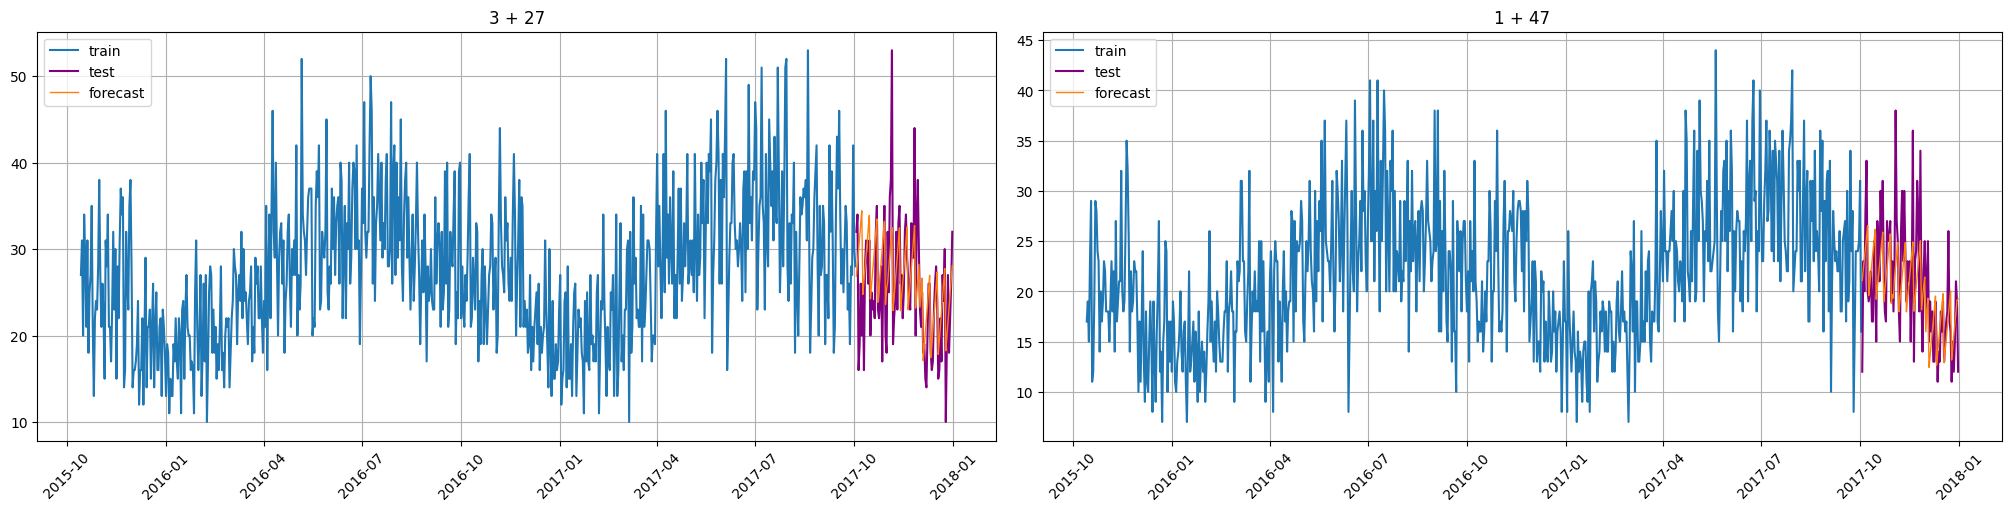

In [69]:
sarimax_exog = train_and_evaluate_model(
    ts=ts,
    model = SARIMAXModel(order=(1, 0, 1), # (p, d, q)
                      seasonal_order=(0, 0, 0, 7)), # (P, D, Q, s),
    transforms=transforms,
    horizon=HORIZON,
    metrics=smape,
    is_auto_regressive=False,
    print_metrics=True
    )# 18.07

In [70]:
# Сравнение результатов моделей
model_res = {
    'naive_model_recursive_metrics': naive_model_recursive_metrics,
    'linear_model_metrics': linear_model_metrics,
    'catboost_with_transform': catboost_with_transform,
    'catboost_no_exog': catboost_no_exog,
    'seasonal_moving_average': seasonal_moving_average,
    #'seasonal_no_exog': seasonal_no_exog,
    'prophet_no_exog_transform': prophet_no_exog_transform,
    'prophet_with_exog_transform': prophet_with_exog_transform,
    'sarimax': sarimax,
    'sarimax_exog': sarimax_exog
}

res = pd.DataFrame({'model': list(model_res.keys()),
                    'avg_metric': [model_res[model][1] for model in model_res.keys()],
                    'segment_metrics': [model_res[model][0] for model in model_res.keys()]})

res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   
4        seasonal_moving_average   19.875463   
5      prophet_no_exog_transform   11.969184   
6    prophet_with_exog_transform   11.995517   
7                        sarimax   12.765940   
8                   sarimax_exog   12.570155   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...  
4  1 + 1     28.479271
1 + 10    19.638362
1 + 11...  
5  1 + 1     19.591706
1 + 10    11.179655
1 + 11...  
6  1 + 1     19.668700
1 + 10    11.291183
1 + 11...  
7  1 + 1     19.605912
1 + 10    12.447214
1 + 11...  
8  1 + 1     19.682306
1 + 10    12.576417
1 + 11...

# Результаты и выводы.

эксперементальные результаты

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>model</th>
      <th>avg_metric</th>
      <th>segment_metrics</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>naive_model_recursive_metrics</td>
      <td>27.941743</td>
      <td>1 + 1     50.912771
1 + 10    19.040035
1 + 11...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>linear_model_metrics</td>
      <td>19.218795</td>
      <td>1 + 1     24.093211
1 + 10    18.726604
1 + 11...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>catboost_with_transform</td>
      <td>43.077667</td>
      <td>1 + 1     67.431599
1 + 10    39.676495
1 + 11...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>seasonal_moving_average</td>
      <td>19.875463</td>
      <td>1 + 1     28.479271
1 + 10    19.638362
1 + 11...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>seasonal_holidays</td>
      <td>19.875463</td>
      <td>1 + 1     28.479271
1 + 10    19.638362
1 + 11...</td>
    </tr>
    <tr>
      <th>5</th>
      <td>prophet_no_exog</td>
      <td>12.509260</td>
      <td>1 + 1     19.775924
1 + 10    11.709062
1 + 11...</td>
    </tr>
    <tr>
      <th>6</th>
      <td>prophet_holydays</td>
      <td>12.542388</td>
      <td>1 + 1     19.795037
1 + 10    11.680458
1 + 11...</td>
    </tr>
    <tr>
      <th>7</th>
      <td>prophet_transforms</td>
      <td>12.541600</td>
      <td>1 + 1     19.890843
1 + 10    11.639488
1 + 11...</td>
    </tr>
    <tr>
      <th>8</th>
      <td>prophet_final</td>
      <td>12.536930</td>
      <td>1 + 1     19.633929
1 + 10    11.605810
1 + 11...</td>
    </tr>
    <tr>
      <th>9</th>
      <td>sarimax</td>
      <td>18.073418</td>
      <td>1 + 1     22.872648
1 + 10    19.770109
1 + 11...</td>
    </tr>
  </tbody>
</table>
</div>

In [71]:
print('final_result')
res

final_result


model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   
4        seasonal_moving_average   19.875463   
5      prophet_no_exog_transform   11.969184   
6    prophet_with_exog_transform   11.995517   
7                        sarimax   12.765940   
8                   sarimax_exog   12.570155   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...  
4  1 + 1     28.479271
1 + 10    19.638362
1 + 11...  
5  1 + 1     19.591706
1 + 10    11.179655
1 + 11...  
6  1 + 1     19.668700
1 + 10    11.291183
1 + 11...  
7  1 + 1     19.605912
1 + 10    12.447214
1 + 11...  
8  1 + 1     19.682306
1 + 10    12.576417
1 + 11...

## Наилучшие результаты показали модели на основе Prophet:

prophet_no_exog_transform (средняя метрика: 11.969)

prophet_with_exog_transform (средняя метрика: 11.996)

Эти модели демонстрируют наименьшие значения средней метрики, что указывает на их высокую точность.

## Модели SARIMAX также показали хорошие результаты:

sarimax_exog (средняя метрика: 12.570)

sarimax (средняя метрика: 12.766)

## CatBoost показал неоднозначные результаты:

catboost_with_transform (средняя метрика: 38.808)

catboost_no_exog (средняя метрика: 43.495)

Эти модели имеют значительно более высокие значения средней метрики, что говорит о их меньшей точности по сравнению с Prophet и SARIMAX.

Несмотря на потенциально высокую гибкость, CatBoost показал худшие результаты, что может быть связано с переобучением или недостаточной настройкой гиперпараметров.

## Наивные модели и линейные модели:

naive_model_recursive_metrics (средняя метрика: 27.942)

linear_model_metrics (средняя метрика: 20.709)

Эти модели показали наихудшие результаты, что ожидаемо, так как они не учитывают сложные зависимости в данных.

## Для всех моделей наблюдается значительный разброс метрик по сегментам. Например:

Для naive_model_recursive_metrics метрика варьируется от 19.040 до 50.913.

Для prophet_no_exog_transform метрика варьируется от 11.180 до 19.592.

Это указывает на то, что некоторые сегменты данных сложнее для прогнозирования, чем другие.

## 

In [73]:
res

model  avg_metric  \
0  naive_model_recursive_metrics   27.941743   
1           linear_model_metrics   20.709193   
2        catboost_with_transform   38.807798   
3               catboost_no_exog   43.494930   
4        seasonal_moving_average   19.875463   
5      prophet_no_exog_transform   11.969184   
6    prophet_with_exog_transform   11.995517   
7                        sarimax   12.765940   
8                   sarimax_exog   12.570155   

                                     segment_metrics  
0  1 + 1     50.912771
1 + 10    19.040035
1 + 11...  
1  1 + 1     24.267748
1 + 10    20.691668
1 + 11...  
2  1 + 1     61.469545
1 + 10    34.434593
1 + 11...  
3  1 + 1     68.277917
1 + 10    40.190632
1 + 11...  
4  1 + 1     28.479271
1 + 10    19.638362
1 + 11...  
5  1 + 1     19.591706
1 + 10    11.179655
1 + 11...  
6  1 + 1     19.668700
1 + 10    11.291183
1 + 11...  
7  1 + 1     19.605912
1 + 10    12.447214
1 + 11...  
8  1 + 1     19.682306
1 + 10    12.576417
1 + 11...

Резюме.

Лучшие модели: Модели на основе Prophet и SARIMAX с экзогенными переменными показали наилучшие результаты. 

Они демонстрируют стабильно низкие значения метрик как в среднем, так и по сегментам.